## Bosquejo de *approach* fuera de la API de keras
#### Autor: Francisco Mena

In [1]:
#imports
import keras, time,os,sys,gc
from keras.layers import *
from keras.models import Sequential,Model
from keras.models import clone_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from sklearn.cluster import AffinityPropagation, SpectralClustering,AgglomerativeClustering,DBSCAN,KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from code.utils import *
from code.representation import *

In [3]:
DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

### Load Data

In [4]:
""" WINE
#df_white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",sep=';')
df_red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",sep=';')

df_red["normal"] = df_red["quality"]==5
df_red["good"] = df_red["quality"]>5
df_red["bad"] = df_red["quality"]<5
df_red["qualities"] = 0*df_red["bad"]+df_red["normal"]+2*df_red["good"]
df_red.drop(['quality','normal','good','bad'],axis=1,inplace=True)

y_train = df_red.pop("qualities").values*1
X_train = df_red.values

y_obs = np.loadtxt("annotations_wine.csv",delimiter=',',dtype='int')
"""

#from keras.datasets import cifar10
#(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
#y_obs = np.loadtxt("../syntetic/annotations_cifar.csv",delimiter=',',dtype='int')

#""" Syntetic data
X_train = np.loadtxt("./synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt("./synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth
y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal.csv",delimiter=',',dtype='int')
#y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal_soft.csv",delimiter=',',dtype='int')


X_test = np.loadtxt("./synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt("./synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
#"""

groups_annot = np.loadtxt("../syntetic/simple/annotgroups_datasim_normal.csv",delimiter=',',dtype='int')
load_matrix = np.loadtxt('./synthetic/simple/matrix_datasim_normal.csv',delimiter=',')
rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
confe_matrix = real_conf_matrix[groups_annot]


N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Shape (data,annotators):  (2292, 100)
Classes:  3


In [4]:
path = "."
scenario = 2

In [6]:
from code.generate_data import SinteticData

X_train = np.loadtxt(path+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(path+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(path+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(path+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth


from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')
    #GenerateData.set_probas(asfile=False,file_matrix=aux1,file_groups =aux2)

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.6406186406186406
Shape (data,annotators):  (2457, 100)
Classes:  3


In [81]:
aux2 = [0.15,0.4,0.45]
aux1 = GenerateData.conf_matrix.copy()

In [7]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 1e-2 #tolerance for relative variation in params 3 is between --1 is for good fit (maybe overfitting)


TOL_LOSS = 1e-3 #tolerance for relative variation in log-likelihood ----REVISAAAR (ultima opcion) -- or

#number of groups is needed

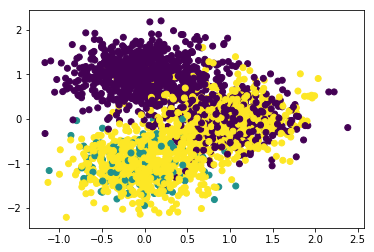

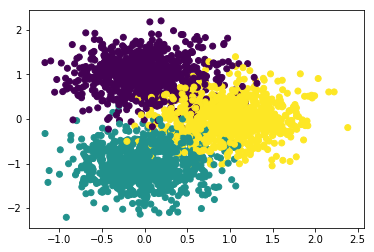

In [15]:
mv = majority_voting(y_obs,onehot=False,probas=False,repeats=False)
plt.scatter(X_train[:,0],X_train[:,1],c=mv)
plt.show()
plt.scatter(X_train[:,0],X_train[:,1],c=Z_train)

In [8]:
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

In [6]:
X_train = X_train.astype(DTYPE_OP)
X_test = X_test.astype(DTYPE_OP)
Xstd_train = X_train/255
Xstd_test = X_test/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

In [9]:
from code.representation import *
##transformar a repeat
r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)

vector of repeats:
 [[ 3  0  7]
 [ 1  3 10]
 [ 3  1  4]
 ...
 [ 4  0  6]
 [12  0  1]
 [ 5  3  2]]


In [10]:
%%time
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
#has to executed always, to know a priori the number of clusters and choose
annotators_pca = project_and_cluster(y_obs,mode_project='pca')[0]
#M_f, annotators_pca, alphas_clusterized0 = project_and_cluster(y_obs,cluster=True,return_projected=True)
print(annotators_pca.shape)

Bayesian gaussian mixture say is 4 clusters 
DBSCAN say is 1 clusters
Affinity Propagation say is 4 clusters
(100, 4)
CPU times: user 7.91 s, sys: 872 ms, total: 8.79 s
Wall time: 1.41 s


In [ ]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
np.mean(aux)#*100

In [11]:
alphas_clusterized1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca) #clusteriza anotaciones de anotadoras
#alphas_clusterized2 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='loss',data=Xstd_train,model=gMixture.base_model) #clusteriza en base aloss
#alphas_clusterized3 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='net',data=Xstd_train) #clusteriza en base a pesos de red
alphas_clusterized1

Clustering Done!
Get init alphas in 0.008609 mins


array([[[3.3333334e-01, 1.8065021e-18, 6.6666669e-01],
        [3.9992812e-01, 2.2002076e-01, 3.8005108e-01],
        [8.5714287e-01, 1.4285715e-01, 2.4860534e-13]],

       [[0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
        [3.3333334e-01, 6.6666669e-01, 9.6752385e-17],
        [2.0000000e-01, 1.0000000e-01, 6.9999999e-01]],

       [[3.4919012e-18, 3.3333334e-01, 6.6666669e-01],
        [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
        [7.4822408e-01, 2.5051242e-01, 1.2635005e-03]],

       ...,

       [[1.9745153e-20, 5.0000000e-01, 5.0000000e-01],
        [3.9992812e-01, 2.2002076e-01, 3.8005108e-01],
        [8.3317274e-01, 1.6675933e-01, 6.7964422e-05]],

       [[2.5000000e-01, 3.3333334e-01, 4.1666666e-01],
        [3.9992812e-01, 2.2002076e-01, 3.8005108e-01],
        [1.0000000e+00, 5.2860250e-21, 7.5046325e-18]],

       [[4.0000001e-01, 4.0000001e-01, 2.0000000e-01],
        [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
        [5.0000000e-01, 5.0000000e-01, 5.6

In [12]:
#alphas_c1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax",l=50) 
alphas_c2 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax inv",l=0.005) 
alphas_c3 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="fuzzy") 
alphas_c4 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="hard") 

Clustering Done!
Get init alphas in 0.008813 mins


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: overflow encountered in power


Clustering Done!
Get init alphas in 0.007739 mins
Clustering Done!
Get init alphas in 0.008859 mins


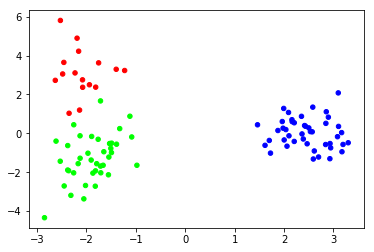

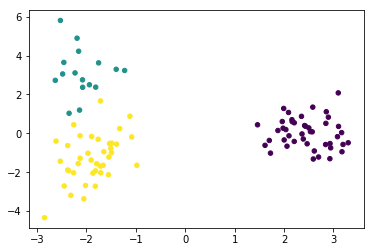

In [86]:
data_to_cluster = annotators_tpca.copy() #annotators_pca
std = StandardScaler()
data_to_cluster = std.fit_transform(data_to_cluster)

kmeans = KMeans(n_clusters=3, random_state=0,init='k-means++',n_jobs=-1)
kmeans.fit(data_to_cluster)

#proyect
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= groups_annot,s=20)
plt.show()
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= kmeans.labels_, s=20)
plt.show()

### Red Base (real)

In [12]:
#PENDIENTES POR AGREGAR---revisar en base a experimentacion con datos simulados
# 1-BatchNormalization en todas las capas
# 2-Dropout

def bloque_convolucional(layer1,units,kernel_size,stride,activation,BN=False):
    """As a ssuper-layer = followed layers"""
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(layer1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(f1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = MaxPool2D(pool_size=stride)(f1)
    return f1
        
def create_network(Kl,input_dim,tipo,info_net,infoextractor_network=None,embedding_info=None):
    #add batch norma y dropa..
    try:
        len(input_dim)
    except:
        input_dim = (input_dim,)
    input_tensor = Input(shape=input_dim,name="data")
    #arquitectura
    if tipo == "CNN": #classic convolutional: deep-CCP
        start_unit,kernel_size,stride,deep,activation = infoextractor_network
        units = start_unit 
        f1 = bloque_convolucional(input_tensor,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        for i in range(deep-1): #profundidad
            units = units*2
            f1 = bloque_convolucional(f1,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        f1 = Flatten()(f1)
            
    elif tipo == "RNN": #recurrent 
        units,deep =infoextractor_network
        #embedding for text datasets
        if embedding_info!=None:
            input_dim,output_dim =embedding_info
            emb = Embedding(input_dim,output_dim)(input_tensor)
            f1 = CuDNNGRU(units,return_sequences=True)(emb)
        else:
            f1 = CuDNNGRU(units,return_sequences=True)(input_tensor)
        for i in range(deep-1): #profundidad
            f1 = CuDNNGRU(units,return_sequences=True)(f1)
        f1 = CuDNNGRU(units,return_sequences=False)(f1) #alias to flatten in convolutional
        #f1 = GlobalMaxPool1D()(f1)
    
    ### classify with extracted features
    units,ff_deep,ff_activation =info_net
    if tipo == "FF": #classic Feed Forward
        d1 = Dense(units,activation=ff_activation)(input_tensor) #comes from input
    else:
        d1 = Dense(units,activation=ff_activation)(f1)
    for i in range(ff_deep-1): #all the deep layers
        units = units/2
        d1 = Dense(units,activation=ff_activation)(d1)
        
    output_soft = Dense(Kl,activation='softmax',name="output_soft")(d1) #softmax to probability p(z|xi)
    
    model = Model(inputs=input_tensor,outputs=output_soft)
    model.summary()
    return model

In [13]:
### Ejemplo CNN
start_units,kernel,strides,deep,activation = 32, 3, 2, 3, 'relu'
info_cnn = [start_units,kernel,strides,deep,activation] 

start_units,deep, activation = 512 , 2, 'relu' 
info = [start_units,deep,activation]  #feed forwad info
clases = 3
dimensiones_input = [50,50,3]
a = create_network(clases,dimensiones_input,"CNN",info,info_cnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [15]:
### Ejemplo RNN
start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [5,50]
a = create_network(clases,dimensiones_input,"RNN",info,info_rnn)

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 5, 50)             0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 5, 128)            69120     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 5, 128)            99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
out

In [16]:
### Ejemplo RNN con embedding
input_dim,output_dim = 1000,64
info_embedding = [input_dim,output_dim]

start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [10] #largo
a = create_network(clases,dimensiones_input,"RNN",info,infoextractor_network=info_rnn,embedding_info=info_embedding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            64000     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 10, 128)           74496     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 10, 128)           99072     
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
__________

<a id="sindato"></a>
### Training module  1
---
Here we implement the iteration between **E** and **M** steps of our formulation with group annotations $r_{ij}$.

In [12]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.MixtureofGroups import GroupMixtureOpt

In [37]:
M_itj = set_representation(y_obs,'onehot')
mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
mask_nan2 = M_itj.sum(axis=1) == 0

mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
M_itj[mask_nan] = 1
M_itj_norm = M_itj/np.sum(M_itj,axis=1)[:,None,:]
M_itj_norm = M_itj_norm.astype(DTYPE_OP)
        
alphas_init = np.tensordot(M_itj_norm,groups_annot, axes=[[1],[0]]) 
#alphas_init[mask_nan2] = 1/alphas_init.shape[-1]
alphas_init

array([[[0.        , 0.        , 1.        ],
        [1.        , 0.        , 0.        ],
        [0.        , 0.8571429 , 0.14285715]],

       [[0.18999997, 0.59      , 0.21999997],
        [0.375     , 0.625     , 0.        ],
        [0.        , 0.5555556 , 0.44444445]],

       [[0.        , 0.        , 1.        ],
        [0.18999997, 0.59      , 0.21999997],
        [0.14285715, 0.8571429 , 0.        ]],

       ...,

       [[1.        , 0.        , 0.        ],
        [0.18999997, 0.59      , 0.21999997],
        [0.125     , 0.875     , 0.        ]],

       [[0.        , 0.44444445, 0.5555556 ],
        [0.18999997, 0.59      , 0.21999997],
        [0.        , 1.        , 0.        ]],

       [[0.22222222, 0.33333334, 0.44444445],
        [0.18999997, 0.59      , 0.21999997],
        [0.25      , 0.5       , 0.25      ]]], dtype=float32)

In [16]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=0,dtype_op=DTYPE_OP) 
gMixture.define_model("keras_shallow")
#gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
#gMixture.define_model("default cnn")
gMixture.lambda_random=False

gMixture.set_alpha(alphas_clusterized1)

gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                           ,relative=True)

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.13 sec)	logL: -24700.957	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23863.382	Tol1: 0.03391	Tol2: 0.20788	Tol3: 0.05732	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23431.634	Tol1: 0.01809	Tol2: 0.15762	Tol3: 0.00473	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23065.227	Tol1: 0.01564	Tol2: 0.14423	Tol3: 0.00565	
Iter 5/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22739.786	Tol1: 0.01411	Tol2: 0.13413	Tol3: 0.00733	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22449.426	Tol1: 0.01277	Tol2: 0.12716	Tol3: 0.00678	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22186.078	Tol1: 0.01173	Tol2: 0.12211	Tol3: 0.00579	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	lo

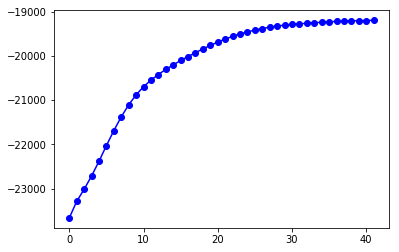

In [97]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

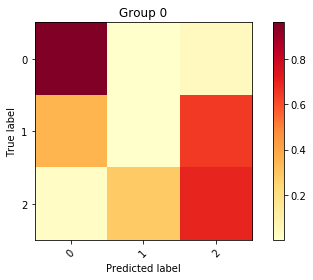

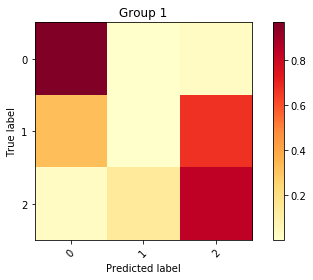

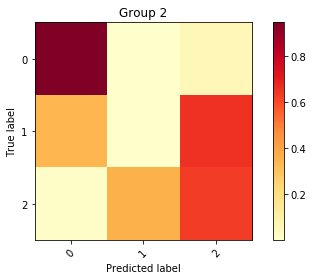

Inertia: 0.006220288497085373
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.521112   0.4988       0.552984    2.48958            0.604675
   1         1  0.197275   0.434452     0.602397    2.1225             0.636021
   2         2  0.281614   0.527459     0.525931    2.32546            0.588478
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.529915      0.529915
====  ======  ==========  ============


In [139]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

In [27]:
GenerateData.prob_groups

array([0.25, 0.55, 0.2 ])

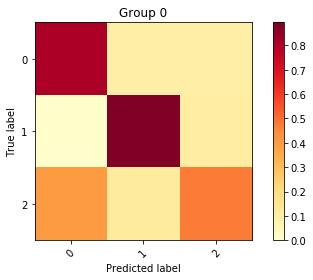

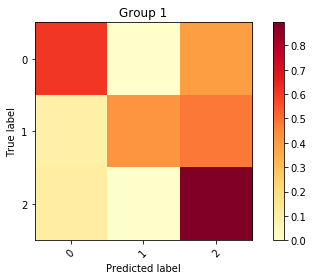

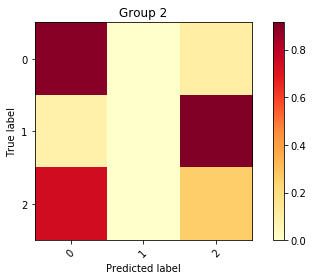

Inertia: 0.16202351067377893
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.189472   0.643653     0.72667    0.355134            0.83733
   1         1  0.588126   0.646593     0.641943   0.489447            0.779772
   2         2  0.222402   0.400478     0.384487   5.86044             0.468836
====  ========  ========  =========  ===========  =========  ==================


In [24]:
evaluate = Evaluation_metrics(gMixture,'our1') 
results = evaluate.calculate_metrics(conf_pred=real_conf_matrix)

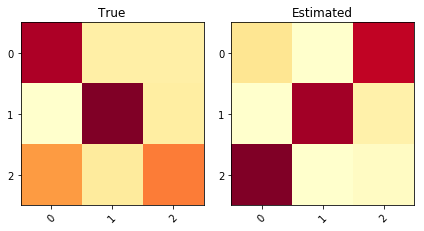

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


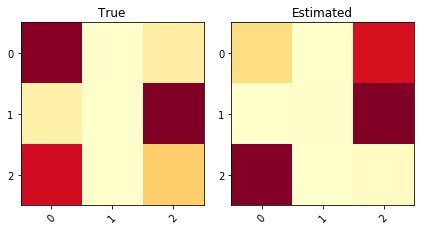

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


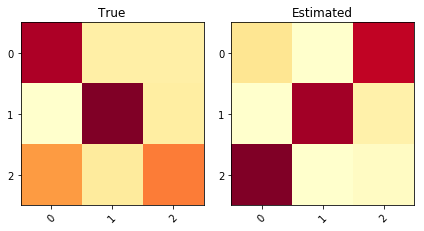

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


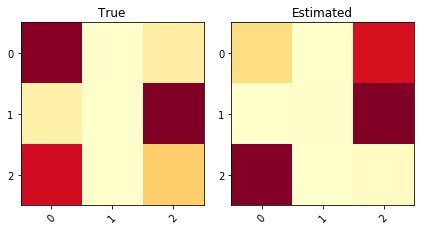

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


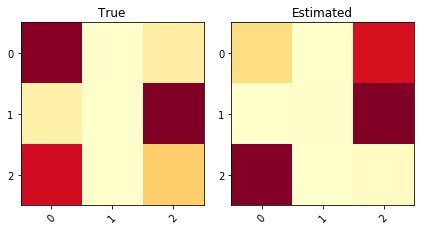

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


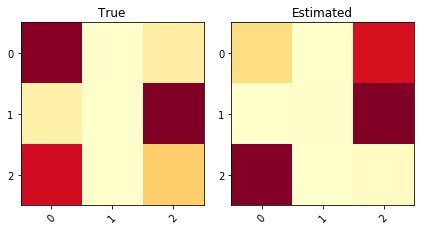

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


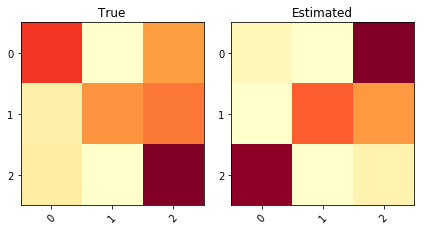

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


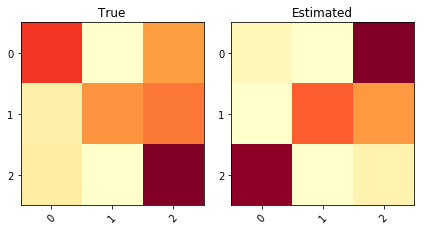

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


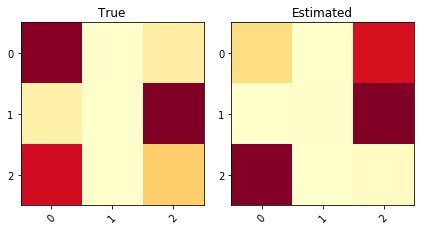

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


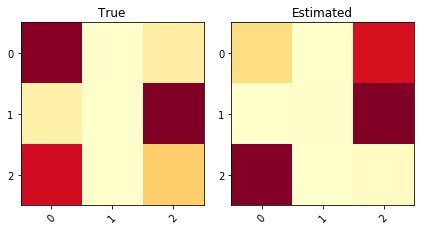

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


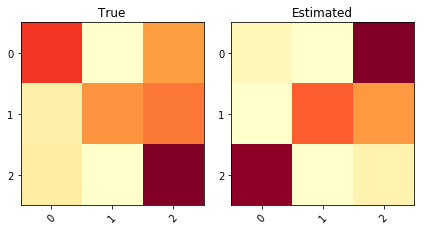

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


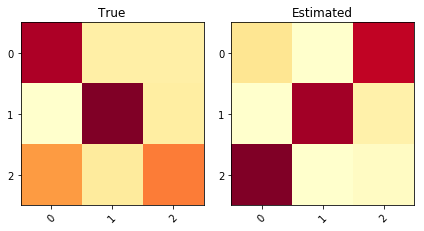

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


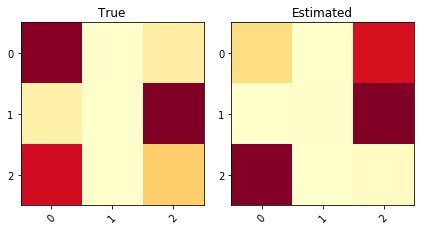

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


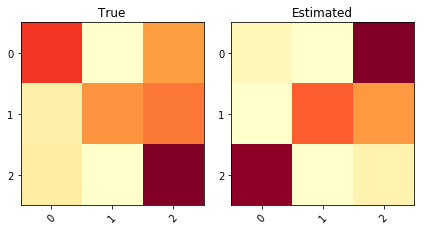

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


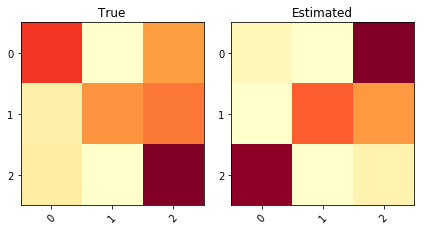

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.400488      0.400488      0.896207               0.234166
====  ======  ==========  ============  ============  =====================


In [17]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [13]:
from code.evaluation import Evaluation_metrics
from tabulate import tabulate
def get_mean_dataframes(df_values):
    if df_values[0].iloc[:,0].dtype == object:
        RT = pd.DataFrame(data=None,columns = df_values[0].columns[1:], index= df_values[0].index)
    else:
        RT = pd.DataFrame(data=None,columns = df_values[0].columns, index= df_values[0].index)
        
    data = []
    for df_value in df_values:
        if df_value.iloc[:,0].dtype == object:
            data.append( df_value.iloc[:,1:].values )
        else:
            data.append(df_value.values)
    RT[:] = np.mean(data,axis=0)
    
    if df_values[0].iloc[:,0].dtype == object:
        RT.insert(0, "", df_values[0].iloc[:,0].values )
    return RT

def run_experiment(pre_init_value):
    aux_test = []
    aux_testA = []
    aux_train = []
    for _ in range(10):
        gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=pre_init_value,dtype_op=DTYPE_OP) 
        gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
        gMixture.lambda_random=False
        gMixture.set_alpha(alphas_clusterized1)
        gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
        logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,relative=True)
        evaluate = Evaluation_metrics(gMixture,'our1',plot=False) 
        c_M = gMixture.get_confusionM()
        Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
        results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)
        aux_test.append(results[1])
        aux_testA.append(results[0])

        aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

        #Usuall train
        Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
        results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
        aux_train += results
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=pre_init_value,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    logL_hists,i = gMixture.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                       ,cluster=True,bulk_annotators=[y_obs,annotators_pca])
    print("**********************************MULTIPLES RUNS**********************************")
    evaluate = Evaluation_metrics(gMixture,'our1',plot=True) 
    c_M = gMixture.get_confusionM()
    Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
    results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

    aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
    predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

    #Usuall train
    Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
    results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
    
    print("**********************************Average Normal**********************************")
    print("A result\n",tabulate(get_mean_dataframes(aux_testA), headers='keys', tablefmt='rst'))
    print("A result\n",tabulate(get_mean_dataframes(aux_test), headers='keys', tablefmt='rst'))
    print("A result\n",tabulate(get_mean_dataframes(aux_train), headers='keys', tablefmt='rst'))

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 6.08 sec)	logL: -25355.522	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24950.650	Tol1: 0.01597	Tol2: 0.18546	Tol3: 0.01044	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24686.282	Tol1: 0.01060	Tol2: 0.11549	Tol3: 0.00694	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24488.267	Tol1: 0.00802	Tol2: 0.08380	Tol3: 0.00594	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24332.887	Tol1: 0.00635	Tol2: 0.06431	Tol3: 0.00549	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24210.909	Tol1: 0.00501	Tol2: 0.05006	Tol3: 0.00448	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24105.416	Tol1: 0.00436	Tol2: 0.04201	Tol3: 0.00330	
Iter 8/50
M step: 

M step: done,  E step: done //  (in 0.12 sec)	logL: -19898.590	Tol1: 0.00156	Tol2: 0.02600	Tol3: 0.00196	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19874.902	Tol1: 0.00119	Tol2: 0.02618	Tol3: 0.00229	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19850.862	Tol1: 0.00121	Tol2: 0.02282	Tol3: 0.00203	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19829.840	Tol1: 0.00106	Tol2: 0.02356	Tol3: 0.00198	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19811.513	Tol1: 0.00092	Tol2: 0.02440	Tol3: 0.00180	
Iter 23/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19792.424	Tol1: 0.00096	Tol2: 0.02601	Tol3: 0.00207	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19775.208	Tol1: 0.00087	Tol2: 0.02806	Tol3: 0.00221	
Iter 25/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19763.509	Tol1: 0.00059	Tol2: 0.03101	Tol3: 0.00259	
Iter 26/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19751.932	T

M step: done,  E step: done //  (in 6.10 sec)	logL: -25345.487	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24525.193	Tol1: 0.03236	Tol2: 0.26271	Tol3: 0.07994	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24317.411	Tol1: 0.00847	Tol2: 0.10749	Tol3: 0.01393	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24107.172	Tol1: 0.00865	Tol2: 0.09348	Tol3: 0.00354	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23887.238	Tol1: 0.00912	Tol2: 0.08114	Tol3: 0.00319	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23651.892	Tol1: 0.00985	Tol2: 0.07302	Tol3: 0.00356	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23391.440	Tol1: 0.01101	Tol2: 0.07024	Tol3: 0.00365	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23107.826	Tol1: 0.01212	Tol2: 0.07268	Tol3: 0.00368	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22808.972	Tol1: 0.01293	Tol2: 0.07783	Tol3: 0.00351	
Iter 10/

M step: done,  E step: done //  (in 0.12 sec)	logL: -19580.482	Tol1: 0.00089	Tol2: 0.02230	Tol3: 0.00201	
Iter 39/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19565.414	Tol1: 0.00077	Tol2: 0.02032	Tol3: 0.00158	
Iter 40/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19550.456	Tol1: 0.00076	Tol2: 0.01926	Tol3: 0.00187	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.90 sec)	logL: -23704.505	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22976.083	Tol1: 0.03073	Tol2: 0.24210	Tol3: 0.07752	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22685.110	Tol1: 0.01266	Tol2: 0.12224	Tol3: 0.01483	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22401.932	Tol1: 0.01248	Tol2: 0.10962	Tol3: 0.00400	
Iter 5/

M step: done,  E step: done //  (in 0.20 sec)	logL: -20361.562	Tol1: 0.00950	Tol2: 0.08707	Tol3: 0.00242	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20218.464	Tol1: 0.00703	Tol2: 0.07546	Tol3: 0.00291	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20119.015	Tol1: 0.00492	Tol2: 0.06679	Tol3: 0.00318	
Iter 27/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20037.276	Tol1: 0.00406	Tol2: 0.05954	Tol3: 0.00320	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19978.704	Tol1: 0.00292	Tol2: 0.05336	Tol3: 0.00338	
Iter 29/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19935.843	Tol1: 0.00215	Tol2: 0.04697	Tol3: 0.00307	
Iter 30/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19896.846	Tol1: 0.00196	Tol2: 0.04282	Tol3: 0.00360	
Iter 31/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19859.302	Tol1: 0.00189	Tol2: 0.04424	Tol3: 0.00427	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19832.530	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -19463.767	Tol1: 0.00015	Tol2: 0.01872	Tol3: 0.00164	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.99 sec)	logL: -24958.893	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24121.836	Tol1: 0.03354	Tol2: 0.20238	Tol3: 0.03553	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23591.345	Tol1: 0.02199	Tol2: 0.17403	Tol3: 0.00426	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23164.477	Tol1: 0.01809	Tol2: 0.14357	Tol3: 0.00342	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22802.630	Tol1: 0.01562	Tol2: 0.12196	Tol3: 0.00285	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22483.828	Tol1: 0.01398	Tol2: 0.10971	Tol3: 0.00214	
Iter 7/50

Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 7.77 sec)	logL: -25181.308	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24584.659	Tol1: 0.02369	Tol2: 0.23060	Tol3: 0.06200	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24402.813	Tol1: 0.00740	Tol2: 0.09552	Tol3: 0.00673	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24216.417	Tol1: 0.00764	Tol2: 0.08205	Tol3: 0.00310	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24008.606	Tol1: 0.00858	Tol2: 0.07520	Tol3: 0.00442	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23775.447	Tol1: 0.00971	Tol2: 0.07319	Tol3: 0.00438	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23515.792	Tol1: 0.01092	Tol2: 0.07799	Tol3: 0.00450	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23235.243	Tol1: 0.

M step: done,  E step: done //  (in 0.13 sec)	logL: -19739.683	Tol1: 0.00105	Tol2: 0.03182	Tol3: 0.00086	
Iter 19/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19720.181	Tol1: 0.00099	Tol2: 0.03006	Tol3: 0.00103	
Iter 20/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19702.740	Tol1: 0.00088	Tol2: 0.02785	Tol3: 0.00121	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19685.717	Tol1: 0.00086	Tol2: 0.02609	Tol3: 0.00102	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19672.041	Tol1: 0.00069	Tol2: 0.02491	Tol3: 0.00146	
Iter 23/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19657.100	Tol1: 0.00076	Tol2: 0.02318	Tol3: 0.00217	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19644.470	Tol1: 0.00064	Tol2: 0.02199	Tol3: 0.00207	
Iter 25/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19632.757	Tol1: 0.00060	Tol2: 0.02199	Tol3: 0.00144	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19620.938	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -19898.890	Tol1: 0.00334	Tol2: 0.05787	Tol3: 0.00118	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19839.341	Tol1: 0.00299	Tol2: 0.05476	Tol3: 0.00125	
Iter 25/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19787.243	Tol1: 0.00263	Tol2: 0.05091	Tol3: 0.00163	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19742.238	Tol1: 0.00227	Tol2: 0.04687	Tol3: 0.00171	
Iter 27/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19702.232	Tol1: 0.00203	Tol2: 0.04405	Tol3: 0.00202	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19666.155	Tol1: 0.00183	Tol2: 0.04002	Tol3: 0.00192	
Iter 29/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19638.435	Tol1: 0.00141	Tol2: 0.03605	Tol3: 0.00196	
Iter 30/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19613.370	Tol1: 0.00128	Tol2: 0.03350	Tol3: 0.00238	
Iter 31/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19592.989	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -20412.595	Tol1: 0.00345	Tol2: 0.05220	Tol3: 0.00728	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20344.018	Tol1: 0.00336	Tol2: 0.04975	Tol3: 0.00717	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20279.366	Tol1: 0.00318	Tol2: 0.04761	Tol3: 0.00711	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20221.263	Tol1: 0.00287	Tol2: 0.04578	Tol3: 0.00697	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20168.543	Tol1: 0.00261	Tol2: 0.04271	Tol3: 0.00670	
Iter 25/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20118.238	Tol1: 0.00249	Tol2: 0.03855	Tol3: 0.00616	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20073.608	Tol1: 0.00222	Tol2: 0.03500	Tol3: 0.00551	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20030.845	Tol1: 0.00213	Tol2: 0.03271	Tol3: 0.00549	
Iter 28/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19990.751	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -22051.689	Tol1: 0.01000	Tol2: 0.08141	Tol3: 0.00023	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21839.303	Tol1: 0.00963	Tol2: 0.07739	Tol3: 0.00128	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21648.753	Tol1: 0.00873	Tol2: 0.07259	Tol3: 0.00266	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21477.691	Tol1: 0.00790	Tol2: 0.06567	Tol3: 0.00374	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21320.243	Tol1: 0.00733	Tol2: 0.05654	Tol3: 0.00445	
Iter 15/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21176.938	Tol1: 0.00672	Tol2: 0.04696	Tol3: 0.00493	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21056.023	Tol1: 0.00571	Tol2: 0.03904	Tol3: 0.00580	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20947.948	Tol1: 0.00513	Tol2: 0.03159	Tol3: 0.00602	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20844.636	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -19615.390	Tol1: 0.00080	Tol2: 0.03027	Tol3: 0.00301	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19603.272	Tol1: 0.00062	Tol2: 0.02978	Tol3: 0.00341	
Iter 30/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19590.929	Tol1: 0.00063	Tol2: 0.02745	Tol3: 0.00320	
Iter 31/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19580.579	Tol1: 0.00053	Tol2: 0.02515	Tol3: 0.00313	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19570.963	Tol1: 0.00049	Tol2: 0.02364	Tol3: 0.00301	
Iter 33/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19558.213	Tol1: 0.00065	Tol2: 0.02298	Tol3: 0.00310	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19548.452	Tol1: 0.00050	Tol2: 0.02658	Tol3: 0.00370	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19536.959	Tol1: 0.00059	Tol2: 0.02482	Tol3: 0.00415	
Iter 36/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19528.011	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -19687.423	Tol1: 0.00064	Tol2: 0.02492	Tol3: 0.00145	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19668.805	Tol1: 0.00095	Tol2: 0.02292	Tol3: 0.00134	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19656.261	Tol1: 0.00064	Tol2: 0.02428	Tol3: 0.00155	
Iter 38/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19643.367	Tol1: 0.00066	Tol2: 0.02312	Tol3: 0.00116	
Iter 39/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19633.467	Tol1: 0.00050	Tol2: 0.02262	Tol3: 0.00131	
Iter 40/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19622.821	Tol1: 0.00054	Tol2: 0.02042	Tol3: 0.00111	
Iter 41/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19614.557	Tol1: 0.00042	Tol2: 0.01968	Tol3: 0.00102	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
I

M step: done,  E step: done //  (in 0.13 sec)	logL: -21473.946	Tol1: 0.00952	Tol2: 0.07321	Tol3: 0.00254	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21291.734	Tol1: 0.00849	Tol2: 0.06599	Tol3: 0.00121	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21128.492	Tol1: 0.00767	Tol2: 0.06055	Tol3: 0.00050	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20981.589	Tol1: 0.00695	Tol2: 0.05676	Tol3: 0.00088	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20853.017	Tol1: 0.00613	Tol2: 0.05494	Tol3: 0.00141	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20741.366	Tol1: 0.00535	Tol2: 0.05199	Tol3: 0.00193	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20641.792	Tol1: 0.00480	Tol2: 0.04904	Tol3: 0.00197	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20553.084	Tol1: 0.00430	Tol2: 0.04431	Tol3: 0.00231	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20472.651	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -19517.573	Tol1: 0.00045	Tol2: 0.02400	Tol3: 0.00210	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19509.338	Tol1: 0.00042	Tol2: 0.02257	Tol3: 0.00167	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19498.531	Tol1: 0.00055	Tol2: 0.02199	Tol3: 0.00144	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19492.596	Tol1: 0.00030	Tol2: 0.02305	Tol3: 0.00126	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19485.369	Tol1: 0.00037	Tol2: 0.02095	Tol3: 0.00139	
Iter 38/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19480.135	Tol1: 0.00027	Tol2: 0.02104	Tol3: 0.00141	
Iter 39/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19473.416	Tol1: 0.00034	Tol2: 0.01855	Tol3: 0.00178	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
I

M step: done,  E step: done //  (in 0.15 sec)	logL: -20438.697	Tol1: 0.00823	Tol2: 0.08575	Tol3: 0.00149	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20308.875	Tol1: 0.00635	Tol2: 0.07298	Tol3: 0.00145	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20207.114	Tol1: 0.00501	Tol2: 0.06006	Tol3: 0.00112	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20122.589	Tol1: 0.00418	Tol2: 0.04801	Tol3: 0.00105	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20062.141	Tol1: 0.00300	Tol2: 0.04005	Tol3: 0.00115	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20010.297	Tol1: 0.00258	Tol2: 0.03610	Tol3: 0.00104	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19966.617	Tol1: 0.00218	Tol2: 0.03192	Tol3: 0.00100	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19933.498	Tol1: 0.00166	Tol2: 0.03006	Tol3: 0.00135	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19903.613	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -21703.045	Tol1: 0.01612	Tol2: 0.11190	Tol3: 0.00103	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21383.954	Tol1: 0.01470	Tol2: 0.11139	Tol3: 0.00160	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21094.207	Tol1: 0.01355	Tol2: 0.10747	Tol3: 0.00110	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20846.301	Tol1: 0.01175	Tol2: 0.09992	Tol3: 0.00116	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20640.502	Tol1: 0.00987	Tol2: 0.09152	Tol3: 0.00112	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20474.165	Tol1: 0.00806	Tol2: 0.08192	Tol3: 0.00086	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20328.902	Tol1: 0.00709	Tol2: 0.07104	Tol3: 0.00067	
Iter 15/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20218.105	Tol1: 0.00545	Tol2: 0.05956	Tol3: 0.00103	
Iter 16/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20123.543	To

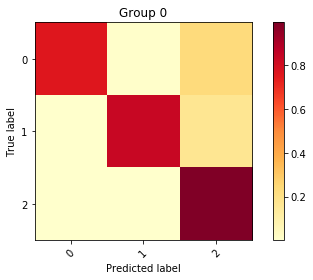

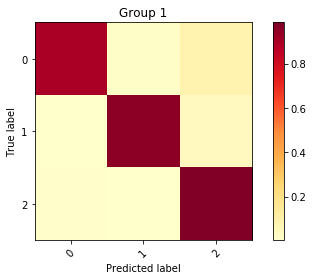

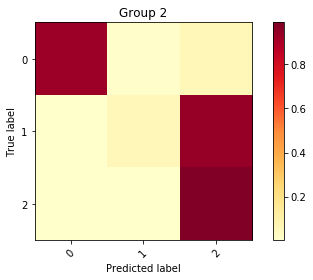

Inertia: 0.10389069421216846
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.438012   0.365735     0.860957  0.156076             0.924594
   1         1  0.228779   0.214695     0.947237  0.0549446            0.972845
   2         2  0.333208   0.189752     0.658737  0.995257             0.705047
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.789988      0.789988
====  ======  ==========  ============


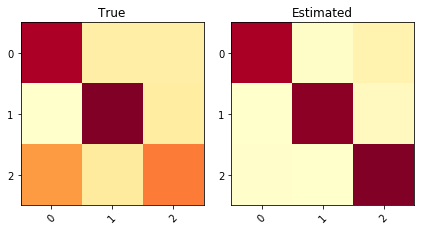

KL divergence: 0.5797	Pearson Correlation between diagonals: -0.6187


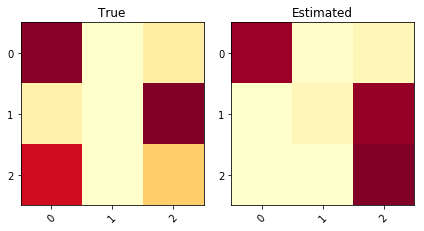

KL divergence: 1.1880	Pearson Correlation between diagonals: 0.6828


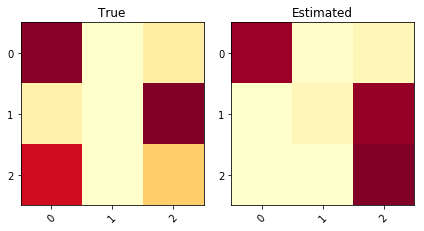

KL divergence: 1.1880	Pearson Correlation between diagonals: 0.6828


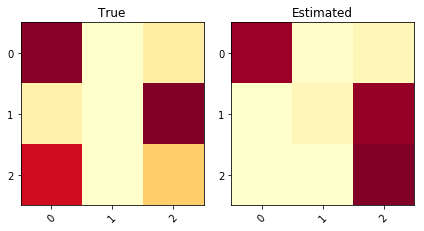

KL divergence: 1.1880	Pearson Correlation between diagonals: 0.6828


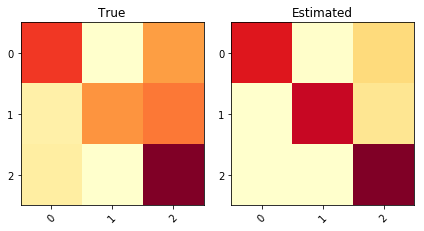

KL divergence: 0.3087	Pearson Correlation between diagonals: 0.7617


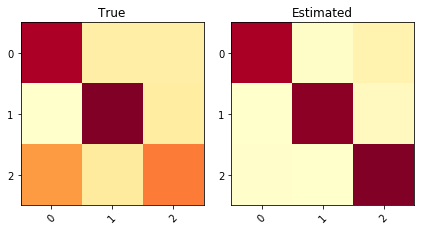

KL divergence: 0.5797	Pearson Correlation between diagonals: -0.6187


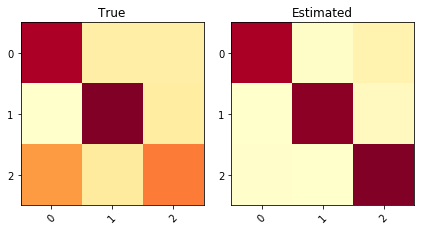

KL divergence: 0.5797	Pearson Correlation between diagonals: -0.6187


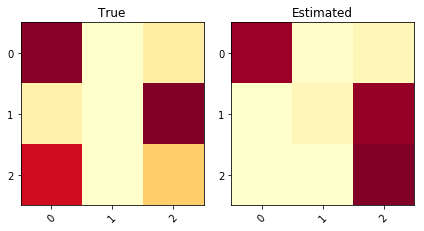

KL divergence: 1.1880	Pearson Correlation between diagonals: 0.6828


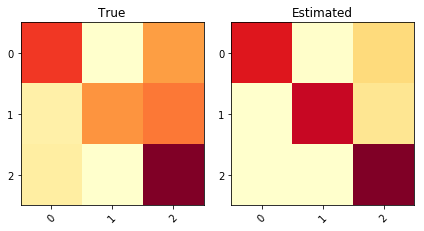

KL divergence: 0.3087	Pearson Correlation between diagonals: 0.7617


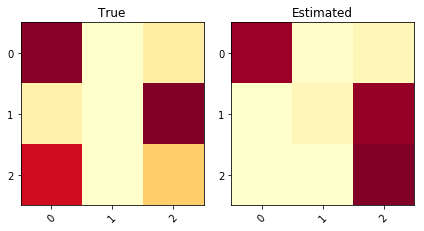

KL divergence: 1.1880	Pearson Correlation between diagonals: 0.6828


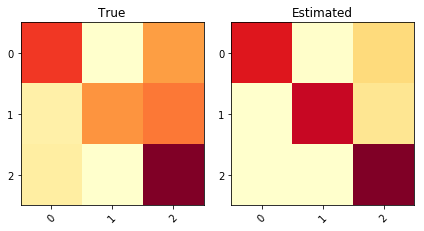

KL divergence: 0.3087	Pearson Correlation between diagonals: 0.7617


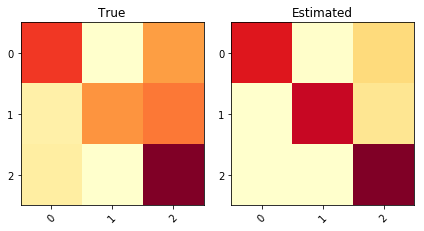

KL divergence: 0.3087	Pearson Correlation between diagonals: 0.7617


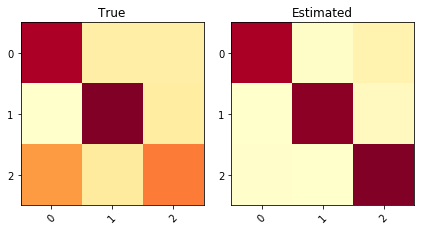

KL divergence: 0.5797	Pearson Correlation between diagonals: -0.6187


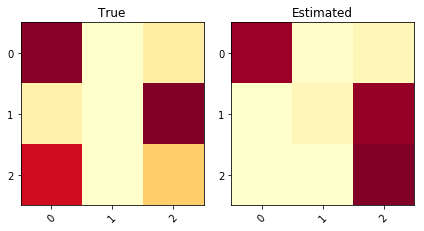

KL divergence: 1.1880	Pearson Correlation between diagonals: 0.6828


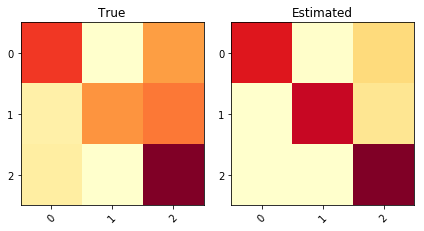

KL divergence: 0.3087	Pearson Correlation between diagonals: 0.7617
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.771266      0.771266      0.702457               0.428048
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.407829   0.463484     0.522301    1.39276            0.628628
   1         1  0.214323   0.345541     0.604269    1.27139            0.672661
   2         2  0.377849   0.282429     0.416605 

In [18]:
#con pre-entrenar 0
run_experiment(0) #funca bien con multiples runs (deja explorar mejor) -- escoje el peor con un bad MV

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 2.66 sec)	logL: -26942.479	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25685.131	Tol1: 0.04667	Tol2: 0.35564	Tol3: 0.05509	
Iter 3/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -25057.679	Tol1: 0.02443	Tol2: 0.22540	Tol3: 0.01180	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24576.014	Tol1: 0.01922	Tol2: 0.18266	Tol3: 0.01150	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24189.141	Tol1: 0.01574	Tol2: 0.15061	Tol3: 0.01137	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23858.203	Tol1: 0.01368	Tol2: 0.13354	Tol3: 0.01211	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23560.301	Tol1: 0.01249	Tol2: 0.12433	Tol3: 0.01356	
Iter 8/50
M step: 

M step: done,  E step: done //  (in 0.10 sec)	logL: -19677.217	Tol1: 0.00101	Tol2: 0.02311	Tol3: 0.00212	
Iter 27/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19657.624	Tol1: 0.00100	Tol2: 0.02073	Tol3: 0.00144	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19641.099	Tol1: 0.00084	Tol2: 0.01915	Tol3: 0.00120	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.24 sec)	logL: -25367.518	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24668.375	Tol1: 0.02756	Tol2: 0.25682	Tol3: 0.05916	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24474.885	Tol1: 0.00784	Tol2: 0.09857	Tol3: 0.00769	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24313.039	Tol1: 0.00661	Tol2: 0.07204	Tol3: 0.00459	
Iter 5/

M step: done,  E step: done //  (in 0.11 sec)	logL: -20500.536	Tol1: 0.00828	Tol2: 0.07568	Tol3: 0.00468	
Iter 16/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20353.295	Tol1: 0.00718	Tol2: 0.06150	Tol3: 0.00395	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20242.161	Tol1: 0.00546	Tol2: 0.04761	Tol3: 0.00320	
Iter 18/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20151.350	Tol1: 0.00449	Tol2: 0.03762	Tol3: 0.00248	
Iter 19/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20074.123	Tol1: 0.00383	Tol2: 0.02911	Tol3: 0.00167	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20012.801	Tol1: 0.00305	Tol2: 0.02684	Tol3: 0.00100	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19961.653	Tol1: 0.00256	Tol2: 0.03003	Tol3: 0.00054	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19917.064	Tol1: 0.00223	Tol2: 0.03575	Tol3: 0.00052	
Iter 23/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19883.619	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -20082.615	Tol1: 0.00096	Tol2: 0.03043	Tol3: 0.00053	
Iter 39/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20058.750	Tol1: 0.00119	Tol2: 0.02830	Tol3: 0.00100	
Iter 40/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20038.186	Tol1: 0.00103	Tol2: 0.02648	Tol3: 0.00041	
Iter 41/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20016.676	Tol1: 0.00107	Tol2: 0.02497	Tol3: 0.00108	
Iter 42/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19994.985	Tol1: 0.00108	Tol2: 0.02340	Tol3: 0.00089	
Iter 43/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19976.232	Tol1: 0.00094	Tol2: 0.02144	Tol3: 0.00076	
Iter 44/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19958.917	Tol1: 0.00087	Tol2: 0.01892	Tol3: 0.00049	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  

M step: done,  E step: done //  (in 0.10 sec)	logL: -19949.429	Tol1: 0.00205	Tol2: 0.03745	Tol3: 0.00198	
Iter 27/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19910.994	Tol1: 0.00193	Tol2: 0.03350	Tol3: 0.00150	
Iter 28/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19875.309	Tol1: 0.00179	Tol2: 0.03078	Tol3: 0.00121	
Iter 29/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19842.620	Tol1: 0.00164	Tol2: 0.02785	Tol3: 0.00074	
Iter 30/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19816.375	Tol1: 0.00132	Tol2: 0.02563	Tol3: 0.00042	
Iter 31/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19792.939	Tol1: 0.00118	Tol2: 0.02341	Tol3: 0.00056	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19765.587	Tol1: 0.00138	Tol2: 0.02286	Tol3: 0.00099	
Iter 33/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19736.594	Tol1: 0.00147	Tol2: 0.02060	Tol3: 0.00062	
Iter 34/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19712.488	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -19903.925	Tol1: 0.00043	Tol2: 0.03052	Tol3: 0.00051	
Iter 31/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19892.382	Tol1: 0.00058	Tol2: 0.02915	Tol3: 0.00025	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19886.274	Tol1: 0.00031	Tol2: 0.02907	Tol3: 0.00030	
Iter 33/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19878.042	Tol1: 0.00041	Tol2: 0.02649	Tol3: 0.00011	
Iter 34/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19870.911	Tol1: 0.00036	Tol2: 0.02544	Tol3: 0.00014	
Iter 35/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19866.502	Tol1: 0.00022	Tol2: 0.02371	Tol3: 0.00049	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19864.890	Tol1: 0.00008	Tol2: 0.02182	Tol3: 0.00033	
Iter 37/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19855.485	Tol1: 0.00047	Tol2: 0.01912	Tol3: 0.00069	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new

M step: done,  E step: done //  (in 0.11 sec)	logL: -24260.235	Tol1: 0.01913	Tol2: 0.14661	Tol3: 0.00304	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23822.634	Tol1: 0.01804	Tol2: 0.12639	Tol3: 0.00180	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23409.830	Tol1: 0.01733	Tol2: 0.11495	Tol3: 0.00256	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23005.486	Tol1: 0.01727	Tol2: 0.10919	Tol3: 0.00293	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22609.193	Tol1: 0.01723	Tol2: 0.11214	Tol3: 0.00317	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22224.209	Tol1: 0.01703	Tol2: 0.11633	Tol3: 0.00335	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21854.391	Tol1: 0.01664	Tol2: 0.11892	Tol3: 0.00377	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21523.436	Tol1: 0.01514	Tol2: 0.11970	Tol3: 0.00377	
Iter 11/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21230.201	Tol1: 0

M step: done,  E step: done //  (in 0.11 sec)	logL: -20055.050	Tol1: 0.00276	Tol2: 0.04378	Tol3: 0.00238	
Iter 35/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20001.411	Tol1: 0.00267	Tol2: 0.04435	Tol3: 0.00283	
Iter 36/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19952.107	Tol1: 0.00247	Tol2: 0.04246	Tol3: 0.00263	
Iter 37/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19901.707	Tol1: 0.00253	Tol2: 0.04443	Tol3: 0.00350	
Iter 38/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19853.834	Tol1: 0.00241	Tol2: 0.04493	Tol3: 0.00341	
Iter 39/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19808.730	Tol1: 0.00227	Tol2: 0.04556	Tol3: 0.00321	
Iter 40/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19768.203	Tol1: 0.00205	Tol2: 0.04520	Tol3: 0.00318	
Iter 41/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19731.475	Tol1: 0.00186	Tol2: 0.04415	Tol3: 0.00318	
Iter 42/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19700.991	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -20015.336	Tol1: 0.00108	Tol2: 0.03422	Tol3: 0.00163	
Iter 33/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19995.556	Tol1: 0.00099	Tol2: 0.03147	Tol3: 0.00170	
Iter 34/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19975.135	Tol1: 0.00102	Tol2: 0.02900	Tol3: 0.00168	
Iter 35/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19958.851	Tol1: 0.00082	Tol2: 0.02665	Tol3: 0.00171	
Iter 36/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19933.265	Tol1: 0.00128	Tol2: 0.02484	Tol3: 0.00138	
Iter 37/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19916.386	Tol1: 0.00085	Tol2: 0.02393	Tol3: 0.00080	
Iter 38/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19899.341	Tol1: 0.00086	Tol2: 0.02193	Tol3: 0.00136	
Iter 39/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19872.547	Tol1: 0.00135	Tol2: 0.02001	Tol3: 0.00146	
Iter 40/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19854.878	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -19846.024	Tol1: 0.00117	Tol2: 0.03378	Tol3: 0.00145	
Iter 31/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19825.113	Tol1: 0.00105	Tol2: 0.03227	Tol3: 0.00126	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19803.755	Tol1: 0.00108	Tol2: 0.02978	Tol3: 0.00095	
Iter 33/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19786.189	Tol1: 0.00089	Tol2: 0.02835	Tol3: 0.00104	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19770.565	Tol1: 0.00079	Tol2: 0.02589	Tol3: 0.00134	
Iter 35/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19751.839	Tol1: 0.00095	Tol2: 0.02280	Tol3: 0.00121	
Iter 36/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19737.524	Tol1: 0.00072	Tol2: 0.02009	Tol3: 0.00064	
Iter 37/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19727.675	Tol1: 0.00050	Tol2: 0.01714	Tol3: 0.00041	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... 

M step: done,  E step: done //  (in 0.15 sec)	logL: -21679.327	Tol1: 0.00814	Tol2: 0.07680	Tol3: 0.00332	
Iter 14/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21516.555	Tol1: 0.00751	Tol2: 0.06999	Tol3: 0.00321	
Iter 15/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21364.223	Tol1: 0.00708	Tol2: 0.06331	Tol3: 0.00312	
Iter 16/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21228.235	Tol1: 0.00637	Tol2: 0.05638	Tol3: 0.00281	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21097.373	Tol1: 0.00616	Tol2: 0.05092	Tol3: 0.00289	
Iter 18/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20979.268	Tol1: 0.00560	Tol2: 0.04568	Tol3: 0.00260	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20869.006	Tol1: 0.00526	Tol2: 0.04205	Tol3: 0.00262	
Iter 20/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20768.829	Tol1: 0.00480	Tol2: 0.03851	Tol3: 0.00243	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20670.736	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -20165.201	Tol1: 0.00073	Tol2: 0.03226	Tol3: 0.00021	
Iter 39/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20148.791	Tol1: 0.00081	Tol2: 0.03142	Tol3: 0.00022	
Iter 40/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20132.998	Tol1: 0.00078	Tol2: 0.03125	Tol3: 0.00017	
Iter 41/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20113.247	Tol1: 0.00098	Tol2: 0.02954	Tol3: 0.00040	
Iter 42/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20092.833	Tol1: 0.00101	Tol2: 0.03027	Tol3: 0.00037	
Iter 43/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20071.224	Tol1: 0.00108	Tol2: 0.03204	Tol3: 0.00064	
Iter 44/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20049.167	Tol1: 0.00110	Tol2: 0.03284	Tol3: 0.00049	
Iter 45/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20027.288	Tol1: 0.00109	Tol2: 0.03301	Tol3: 0.00068	
Iter 46/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20004.053	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -22467.177	Tol1: 0.01484	Tol2: 0.09458	Tol3: 0.00298	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22106.322	Tol1: 0.01606	Tol2: 0.10186	Tol3: 0.00380	
Iter 10/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21746.535	Tol1: 0.01628	Tol2: 0.10583	Tol3: 0.00410	
Iter 11/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21407.571	Tol1: 0.01559	Tol2: 0.10531	Tol3: 0.00425	
Iter 12/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21084.873	Tol1: 0.01507	Tol2: 0.10044	Tol3: 0.00497	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20803.488	Tol1: 0.01335	Tol2: 0.09202	Tol3: 0.00438	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20556.832	Tol1: 0.01186	Tol2: 0.08251	Tol3: 0.00374	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20359.584	Tol1: 0.00960	Tol2: 0.07307	Tol3: 0.00441	
Iter 16/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20200.986	To

M step: done,  E step: done //  (in 0.12 sec)	logL: -19644.089	Tol1: 0.00094	Tol2: 0.02729	Tol3: 0.00095	
Iter 33/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19627.433	Tol1: 0.00085	Tol2: 0.02804	Tol3: 0.00163	
Iter 34/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19614.999	Tol1: 0.00063	Tol2: 0.02722	Tol3: 0.00203	
Iter 35/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19603.676	Tol1: 0.00058	Tol2: 0.02474	Tol3: 0.00156	
Iter 36/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19589.888	Tol1: 0.00070	Tol2: 0.02415	Tol3: 0.00156	
Iter 37/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19581.799	Tol1: 0.00041	Tol2: 0.02403	Tol3: 0.00157	
Iter 38/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19571.277	Tol1: 0.00054	Tol2: 0.02409	Tol3: 0.00215	
Iter 39/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19562.588	Tol1: 0.00044	Tol2: 0.02337	Tol3: 0.00190	
Iter 40/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19555.942	T

M step: done,  E step: done //  (in 0.19 sec)	logL: -21812.616	Tol1: 0.01508	Tol2: 0.10449	Tol3: 0.00116	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21492.926	Tol1: 0.01466	Tol2: 0.09986	Tol3: 0.00015	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21204.530	Tol1: 0.01342	Tol2: 0.09315	Tol3: 0.00098	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20956.089	Tol1: 0.01172	Tol2: 0.08645	Tol3: 0.00182	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20746.226	Tol1: 0.01001	Tol2: 0.08006	Tol3: 0.00236	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20571.473	Tol1: 0.00842	Tol2: 0.07461	Tol3: 0.00285	
Iter 13/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20428.896	Tol1: 0.00693	Tol2: 0.06961	Tol3: 0.00348	
Iter 14/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20312.388	Tol1: 0.00570	Tol2: 0.06491	Tol3: 0.00372	
Iter 15/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20218.255	Tol

M step: done,  E step: done //  (in 0.12 sec)	logL: -20192.928	Tol1: 0.00135	Tol2: 0.04613	Tol3: 0.00285	
Iter 39/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20166.663	Tol1: 0.00130	Tol2: 0.04769	Tol3: 0.00343	
Iter 40/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20145.059	Tol1: 0.00107	Tol2: 0.04662	Tol3: 0.00289	
Iter 41/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20124.235	Tol1: 0.00103	Tol2: 0.04644	Tol3: 0.00288	
Iter 42/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20103.193	Tol1: 0.00105	Tol2: 0.04608	Tol3: 0.00287	
Iter 43/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20090.183	Tol1: 0.00065	Tol2: 0.04448	Tol3: 0.00243	
Iter 44/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20077.678	Tol1: 0.00062	Tol2: 0.04164	Tol3: 0.00251	
Iter 45/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20060.997	Tol1: 0.00083	Tol2: 0.03971	Tol3: 0.00251	
Iter 46/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20045.152	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -22215.280	Tol1: 0.01728	Tol2: 0.09671	Tol3: 0.00250	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21822.546	Tol1: 0.01768	Tol2: 0.10372	Tol3: 0.00224	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21461.559	Tol1: 0.01654	Tol2: 0.10847	Tol3: 0.00181	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21134.248	Tol1: 0.01525	Tol2: 0.11056	Tol3: 0.00147	
Iter 11/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20851.550	Tol1: 0.01338	Tol2: 0.10873	Tol3: 0.00089	
Iter 12/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20626.932	Tol1: 0.01077	Tol2: 0.10298	Tol3: 0.00071	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20450.922	Tol1: 0.00853	Tol2: 0.09328	Tol3: 0.00045	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20316.948	Tol1: 0.00655	Tol2: 0.08182	Tol3: 0.00055	
Iter 15/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20215.392	Tol

M step: done,  E step: done //  (in 0.13 sec)	logL: -24129.718	Tol1: 0.00619	Tol2: 0.06672	Tol3: 0.00811	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23940.288	Tol1: 0.00785	Tol2: 0.06709	Tol3: 0.00865	
Iter 12/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23690.634	Tol1: 0.01043	Tol2: 0.07128	Tol3: 0.00933	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23379.374	Tol1: 0.01314	Tol2: 0.07976	Tol3: 0.01004	
Iter 14/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22995.872	Tol1: 0.01640	Tol2: 0.08934	Tol3: 0.01051	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22562.894	Tol1: 0.01883	Tol2: 0.10141	Tol3: 0.01073	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22116.725	Tol1: 0.01977	Tol2: 0.11155	Tol3: 0.01049	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21680.574	Tol1: 0.01972	Tol2: 0.11873	Tol3: 0.00966	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21298.755	T

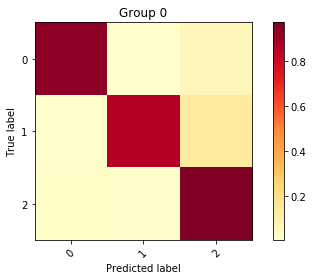

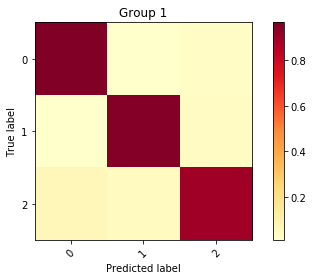

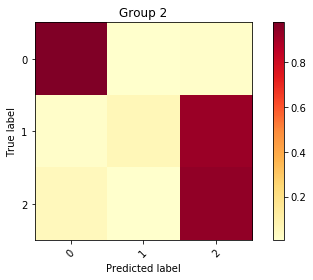

Inertia: 0.10221636046965916
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.434883   0.277906     0.922886  0.0815355            0.959885
   1         1  0.229221   0.253545     0.941296  0.0609399            0.969854
   2         2  0.335896   0.22351      0.660054  0.962902             0.708783
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.885226      0.885226
====  ======  ==========  ============


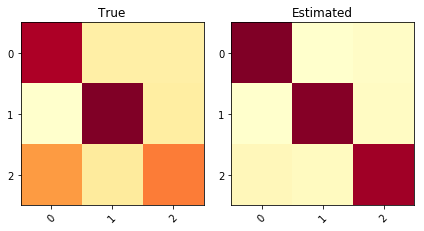

KL divergence: 0.2948	Pearson Correlation between diagonals: 0.9361


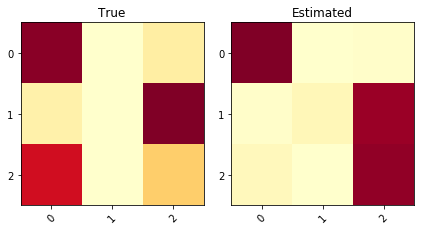

KL divergence: 0.6373	Pearson Correlation between diagonals: 0.7467


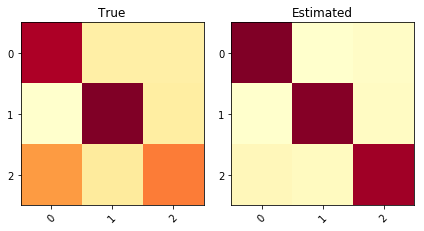

KL divergence: 0.2948	Pearson Correlation between diagonals: 0.9361


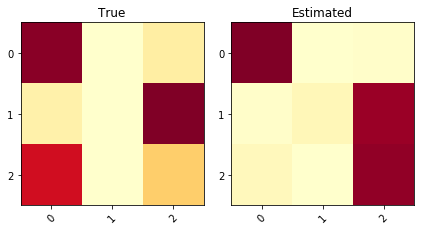

KL divergence: 0.6373	Pearson Correlation between diagonals: 0.7467


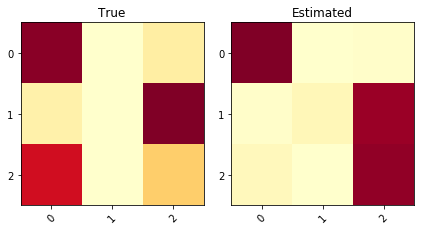

KL divergence: 0.6373	Pearson Correlation between diagonals: 0.7467


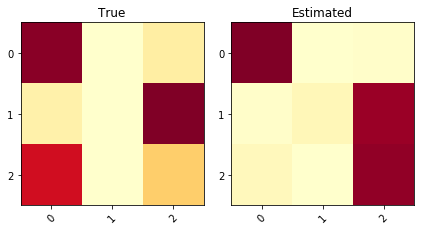

KL divergence: 0.6373	Pearson Correlation between diagonals: 0.7467


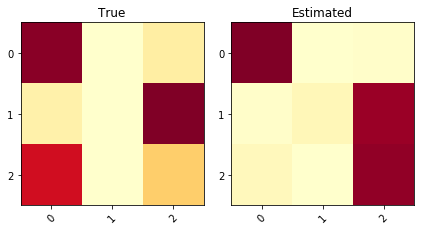

KL divergence: 0.6373	Pearson Correlation between diagonals: 0.7467


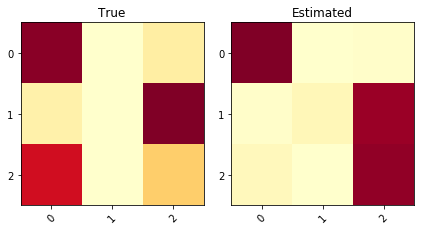

KL divergence: 0.6373	Pearson Correlation between diagonals: 0.7467


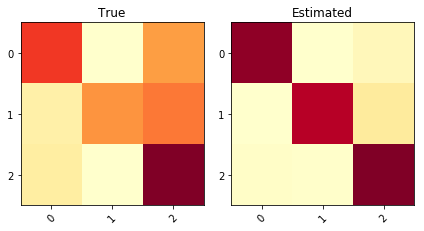

KL divergence: 0.3889	Pearson Correlation between diagonals: 0.9360


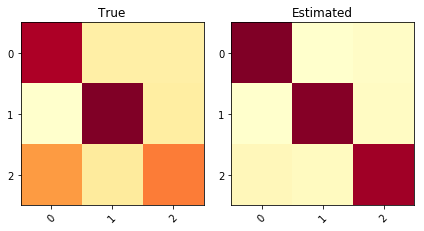

KL divergence: 0.2948	Pearson Correlation between diagonals: 0.9361


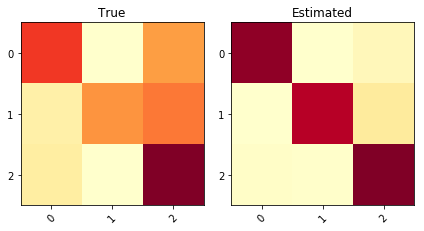

KL divergence: 0.3889	Pearson Correlation between diagonals: 0.9360


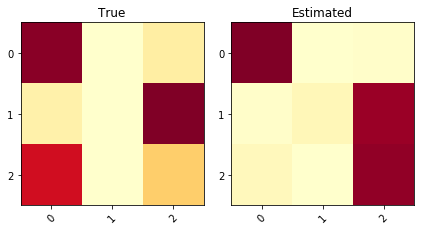

KL divergence: 0.6373	Pearson Correlation between diagonals: 0.7467


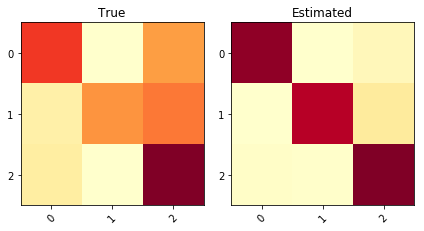

KL divergence: 0.3889	Pearson Correlation between diagonals: 0.9360


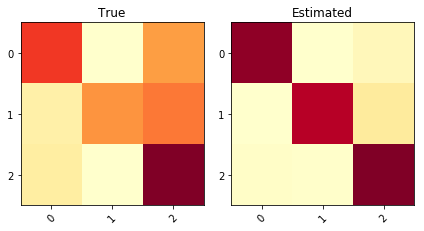

KL divergence: 0.3889	Pearson Correlation between diagonals: 0.9360


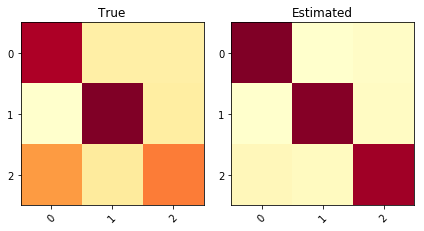

KL divergence: 0.2948	Pearson Correlation between diagonals: 0.9361
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.869353      0.869353      0.462581               0.864102
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.405337   0.441532     0.676734   0.88384             0.766085
   1         1  0.205463   0.341859     0.745487   0.749931            0.802997
   2         2  0.3892     0.263261     0.560127 

In [15]:
#con pre-entrenar 1
run_experiment(1) #escoje el peor con un bad MV-- escoge bien en multiples runs

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.28 sec)	logL: -22792.774	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22201.737	Tol1: 0.02593	Tol2: 0.18830	Tol3: 0.03172	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21742.819	Tol1: 0.02067	Tol2: 0.15962	Tol3: 0.00630	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21339.357	Tol1: 0.01856	Tol2: 0.14201	Tol3: 0.00350	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21001.847	Tol1: 0.01582	Tol2: 0.12865	Tol3: 0.00234	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20726.699	Tol1: 0.01310	Tol2: 0.11475	Tol3: 0.00176	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20524.750	Tol1: 0.00974	Tol2: 0.09804	Tol3: 0.00117	
Iter 8/50
M step: 

M step: done,  E step: done //  (in 0.14 sec)	logL: -19589.275	Tol1: 0.00054	Tol2: 0.02376	Tol3: 0.00331	
Iter 38/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19575.315	Tol1: 0.00071	Tol2: 0.02279	Tol3: 0.00279	
Iter 39/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19565.971	Tol1: 0.00048	Tol2: 0.02309	Tol3: 0.00306	
Iter 40/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19558.450	Tol1: 0.00038	Tol2: 0.02284	Tol3: 0.00355	
Iter 41/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19544.474	Tol1: 0.00071	Tol2: 0.02388	Tol3: 0.00329	
Iter 42/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19536.545	Tol1: 0.00041	Tol2: 0.02298	Tol3: 0.00304	
Iter 43/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19528.785	Tol1: 0.00040	Tol2: 0.02394	Tol3: 0.00334	
Iter 44/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19518.057	Tol1: 0.00055	Tol2: 0.02303	Tol3: 0.00331	
Iter 45/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19506.979	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -19618.434	Tol1: 0.00058	Tol2: 0.03453	Tol3: 0.00356	
Iter 28/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19613.810	Tol1: 0.00024	Tol2: 0.03329	Tol3: 0.00352	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19604.880	Tol1: 0.00046	Tol2: 0.03154	Tol3: 0.00386	
Iter 30/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19599.923	Tol1: 0.00025	Tol2: 0.03000	Tol3: 0.00363	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19587.387	Tol1: 0.00064	Tol2: 0.02911	Tol3: 0.00385	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19579.640	Tol1: 0.00040	Tol2: 0.02775	Tol3: 0.00379	
Iter 33/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19572.598	Tol1: 0.00036	Tol2: 0.02678	Tol3: 0.00379	
Iter 34/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19569.746	Tol1: 0.00015	Tol2: 0.02681	Tol3: 0.00399	
Iter 35/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19559.738	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -19897.899	Tol1: 0.00112	Tol2: 0.03623	Tol3: 0.00394	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19877.940	Tol1: 0.00100	Tol2: 0.03376	Tol3: 0.00421	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19858.115	Tol1: 0.00100	Tol2: 0.03092	Tol3: 0.00434	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19844.789	Tol1: 0.00067	Tol2: 0.02903	Tol3: 0.00423	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19822.689	Tol1: 0.00111	Tol2: 0.02762	Tol3: 0.00465	
Iter 27/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19800.521	Tol1: 0.00112	Tol2: 0.02567	Tol3: 0.00402	
Iter 28/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19788.458	Tol1: 0.00061	Tol2: 0.02500	Tol3: 0.00426	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19765.968	Tol1: 0.00114	Tol2: 0.02431	Tol3: 0.00433	
Iter 30/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19753.019	T

M step: done,  E step: done //  (in 8.87 sec)	logL: -24019.997	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23702.418	Tol1: 0.01322	Tol2: 0.17372	Tol3: 0.03455	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23509.862	Tol1: 0.00812	Tol2: 0.10197	Tol3: 0.00754	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23326.224	Tol1: 0.00781	Tol2: 0.08008	Tol3: 0.00328	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23149.659	Tol1: 0.00757	Tol2: 0.07675	Tol3: 0.00309	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22975.222	Tol1: 0.00754	Tol2: 0.07747	Tol3: 0.00308	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22798.765	Tol1: 0.00768	Tol2: 0.07708	Tol3: 0.00343	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22614.557	Tol1: 0.00808	Tol2: 0.07414	Tol3: 0.00318	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22421.897	Tol1: 0.00852	Tol2: 0.07004	Tol3: 0.00265	
Iter 10/

M step: done,  E step: done //  (in 8.89 sec)	logL: -24424.023	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23911.879	Tol1: 0.02097	Tol2: 0.21539	Tol3: 0.02366	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23548.568	Tol1: 0.01519	Tol2: 0.15098	Tol3: 0.00488	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23188.831	Tol1: 0.01528	Tol2: 0.12542	Tol3: 0.00365	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22811.202	Tol1: 0.01628	Tol2: 0.11371	Tol3: 0.00254	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22434.001	Tol1: 0.01654	Tol2: 0.10874	Tol3: 0.00252	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22075.542	Tol1: 0.01598	Tol2: 0.10414	Tol3: 0.00253	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21744.776	Tol1: 0.01498	Tol2: 0.09771	Tol3: 0.00250	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21457.182	Tol1: 0.01323	Tol2: 0.08984	Tol3: 0.00273	
Iter 10/

M step: done,  E step: done //  (in 0.14 sec)	logL: -19640.796	Tol1: 0.00084	Tol2: 0.04970	Tol3: 0.00338	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19627.275	Tol1: 0.00069	Tol2: 0.04770	Tol3: 0.00372	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19617.906	Tol1: 0.00048	Tol2: 0.04531	Tol3: 0.00401	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19601.804	Tol1: 0.00082	Tol2: 0.04217	Tol3: 0.00421	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19591.579	Tol1: 0.00052	Tol2: 0.04002	Tol3: 0.00415	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19579.981	Tol1: 0.00059	Tol2: 0.03764	Tol3: 0.00432	
Iter 25/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19574.303	Tol1: 0.00029	Tol2: 0.03453	Tol3: 0.00391	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19567.629	Tol1: 0.00034	Tol2: 0.03149	Tol3: 0.00371	
Iter 27/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19557.932	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20090.117	Tol1: 0.00354	Tol2: 0.04505	Tol3: 0.00237	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20034.516	Tol1: 0.00277	Tol2: 0.03974	Tol3: 0.00215	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19996.886	Tol1: 0.00188	Tol2: 0.04040	Tol3: 0.00206	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19957.934	Tol1: 0.00195	Tol2: 0.03819	Tol3: 0.00158	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19928.358	Tol1: 0.00148	Tol2: 0.03767	Tol3: 0.00129	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19898.648	Tol1: 0.00149	Tol2: 0.03995	Tol3: 0.00168	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19873.465	Tol1: 0.00127	Tol2: 0.04006	Tol3: 0.00105	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19849.838	Tol1: 0.00119	Tol2: 0.03967	Tol3: 0.00071	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19830.672	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20951.078	Tol1: 0.00427	Tol2: 0.05676	Tol3: 0.00221	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20866.665	Tol1: 0.00403	Tol2: 0.05358	Tol3: 0.00223	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20795.068	Tol1: 0.00343	Tol2: 0.05167	Tol3: 0.00247	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20727.858	Tol1: 0.00323	Tol2: 0.04788	Tol3: 0.00228	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20670.723	Tol1: 0.00276	Tol2: 0.04509	Tol3: 0.00244	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20613.557	Tol1: 0.00277	Tol2: 0.03903	Tol3: 0.00182	
Iter 18/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20565.728	Tol1: 0.00232	Tol2: 0.03737	Tol3: 0.00203	
Iter 19/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20522.452	Tol1: 0.00210	Tol2: 0.03444	Tol3: 0.00186	
Iter 20/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20480.572	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -19727.222	Tol1: 0.00106	Tol2: 0.02477	Tol3: 0.00233	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19708.537	Tol1: 0.00095	Tol2: 0.02041	Tol3: 0.00172	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19692.644	Tol1: 0.00081	Tol2: 0.01719	Tol3: 0.00146	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.41 sec)	logL: -22861.962	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22310.465	Tol1: 0.02412	Tol2: 0.18479	Tol3: 0.01786	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21836.916	Tol1: 0.02123	Tol2: 0.16276	Tol3: 0.00230	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21407.710	Tol1: 0.01966	Tol2: 0.15110	Tol3: 0.00205	
Iter 5/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.15 sec)	logL: -21090.231	Tol1: 0.00890	Tol2: 0.11397	Tol3: 0.00627	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20930.430	Tol1: 0.00758	Tol2: 0.10337	Tol3: 0.00614	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20791.091	Tol1: 0.00666	Tol2: 0.09256	Tol3: 0.00622	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20678.498	Tol1: 0.00542	Tol2: 0.08320	Tol3: 0.00733	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20580.029	Tol1: 0.00476	Tol2: 0.07359	Tol3: 0.00708	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20487.721	Tol1: 0.00449	Tol2: 0.06577	Tol3: 0.00638	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20404.777	Tol1: 0.00405	Tol2: 0.06398	Tol3: 0.00697	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20323.967	Tol1: 0.00396	Tol2: 0.06209	Tol3: 0.00668	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20249.228	Tol

M step: done,  E step: done //  (in 0.19 sec)	logL: -24056.942	Tol1: 0.01118	Tol2: 0.16314	Tol3: 0.02242	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23875.562	Tol1: 0.00754	Tol2: 0.09334	Tol3: 0.00396	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23666.449	Tol1: 0.00876	Tol2: 0.07681	Tol3: 0.00098	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23432.179	Tol1: 0.00990	Tol2: 0.07296	Tol3: 0.00036	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23177.522	Tol1: 0.01087	Tol2: 0.07666	Tol3: 0.00081	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22895.337	Tol1: 0.01217	Tol2: 0.08289	Tol3: 0.00114	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22598.077	Tol1: 0.01298	Tol2: 0.08792	Tol3: 0.00132	
Iter 9/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22303.258	Tol1: 0.01305	Tol2: 0.08962	Tol3: 0.00157	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22022.626	Tol1: 0.

M step: done,  E step: done //  (in 0.19 sec)	logL: -20363.507	Tol1: 0.00434	Tol2: 0.05457	Tol3: 0.01016	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20285.086	Tol1: 0.00385	Tol2: 0.05721	Tol3: 0.01037	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20214.654	Tol1: 0.00347	Tol2: 0.05590	Tol3: 0.01000	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20151.655	Tol1: 0.00312	Tol2: 0.05316	Tol3: 0.00914	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20096.308	Tol1: 0.00275	Tol2: 0.05191	Tol3: 0.00849	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20043.315	Tol1: 0.00264	Tol2: 0.05127	Tol3: 0.00808	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19997.438	Tol1: 0.00229	Tol2: 0.04851	Tol3: 0.00722	
Iter 27/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19955.259	Tol1: 0.00211	Tol2: 0.04996	Tol3: 0.00709	
Iter 28/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19917.926	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20504.005	Tol1: 0.01017	Tol2: 0.07837	Tol3: 0.00282	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20329.763	Tol1: 0.00850	Tol2: 0.07069	Tol3: 0.00271	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20193.298	Tol1: 0.00671	Tol2: 0.06381	Tol3: 0.00279	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20079.912	Tol1: 0.00562	Tol2: 0.05815	Tol3: 0.00299	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19991.119	Tol1: 0.00442	Tol2: 0.05229	Tol3: 0.00279	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19919.625	Tol1: 0.00358	Tol2: 0.04729	Tol3: 0.00269	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19860.116	Tol1: 0.00299	Tol2: 0.04229	Tol3: 0.00205	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19813.044	Tol1: 0.00237	Tol2: 0.03745	Tol3: 0.00183	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19777.963	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -20081.688	Tol1: 0.00322	Tol2: 0.04062	Tol3: 0.00437	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20013.365	Tol1: 0.00340	Tol2: 0.04063	Tol3: 0.00432	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19947.792	Tol1: 0.00328	Tol2: 0.03873	Tol3: 0.00414	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19890.397	Tol1: 0.00288	Tol2: 0.03742	Tol3: 0.00380	
Iter 21/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19841.418	Tol1: 0.00246	Tol2: 0.03733	Tol3: 0.00378	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19792.428	Tol1: 0.00247	Tol2: 0.03775	Tol3: 0.00433	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19750.262	Tol1: 0.00213	Tol2: 0.03523	Tol3: 0.00367	
Iter 24/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19718.095	Tol1: 0.00163	Tol2: 0.03636	Tol3: 0.00400	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19693.495	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20985.042	Tol1: 0.01241	Tol2: 0.10340	Tol3: 0.00113	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20770.418	Tol1: 0.01023	Tol2: 0.09512	Tol3: 0.00108	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20586.527	Tol1: 0.00885	Tol2: 0.08541	Tol3: 0.00128	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20451.516	Tol1: 0.00656	Tol2: 0.07301	Tol3: 0.00125	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20347.476	Tol1: 0.00509	Tol2: 0.06177	Tol3: 0.00171	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20260.374	Tol1: 0.00428	Tol2: 0.05351	Tol3: 0.00152	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20200.219	Tol1: 0.00297	Tol2: 0.04834	Tol3: 0.00093	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20147.374	Tol1: 0.00262	Tol2: 0.04828	Tol3: 0.00107	
Iter 17/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20095.751	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -19569.649	Tol1: 0.00063	Tol2: 0.02191	Tol3: 0.00301	
Iter 44/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19561.490	Tol1: 0.00042	Tol2: 0.02151	Tol3: 0.00256	
Iter 45/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19552.681	Tol1: 0.00045	Tol2: 0.02137	Tol3: 0.00246	
Iter 46/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19549.535	Tol1: 0.00016	Tol2: 0.02158	Tol3: 0.00180	
Iter 47/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19550.493	Tol1: 0.00005	Tol2: 0.01956	Tol3: 0.00231	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.09 sec)	logL: -23600.465	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23285.172	Tol1: 0.01336	Tol2: 0.15644	Tol3: 0.02730	
Iter 3/50
M step: done,  E step: done //  (i

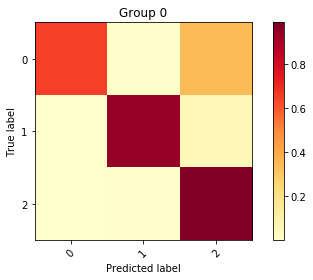

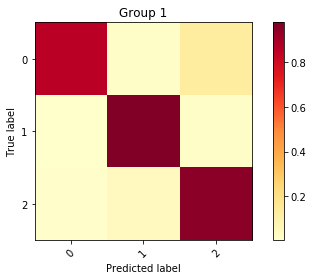

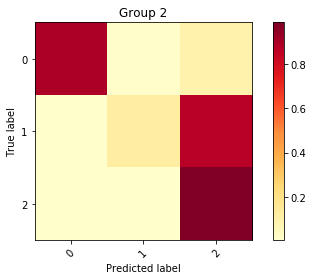

Inertia: 0.10463240385676424
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.473119   0.330594     0.860027  0.167112             0.920928
   1         1  0.23096    0.262522     0.929474  0.0746909            0.963271
   2         2  0.295921   0.277673     0.671211  0.730489             0.742068
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.60928       0.60928
====  ======  ==========  ============


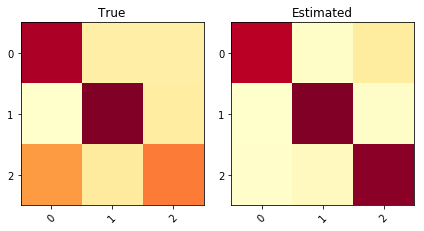

KL divergence: 0.5255	Pearson Correlation between diagonals: -0.1325


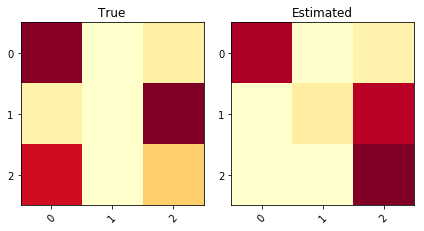

KL divergence: 1.1737	Pearson Correlation between diagonals: 0.6548


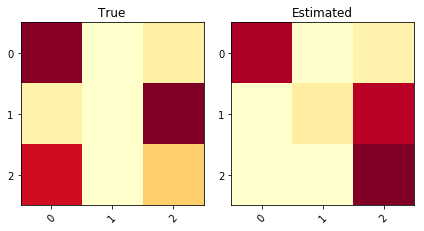

KL divergence: 1.1737	Pearson Correlation between diagonals: 0.6548


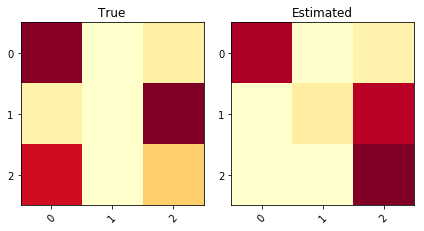

KL divergence: 1.1737	Pearson Correlation between diagonals: 0.6548


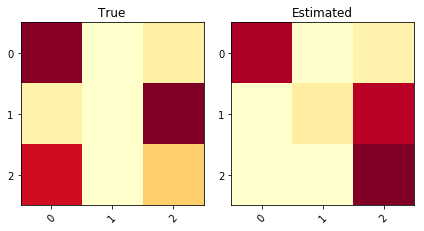

KL divergence: 1.1737	Pearson Correlation between diagonals: 0.6548


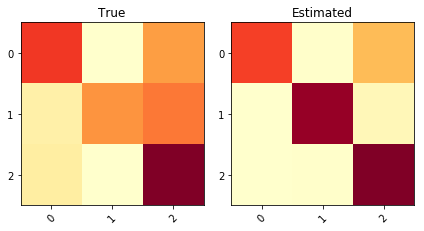

KL divergence: 0.4437	Pearson Correlation between diagonals: 0.2569


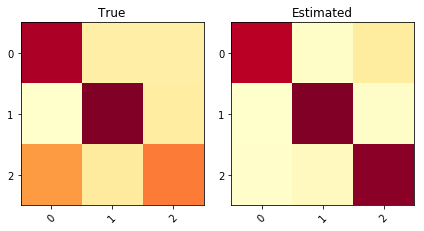

KL divergence: 0.5255	Pearson Correlation between diagonals: -0.1325


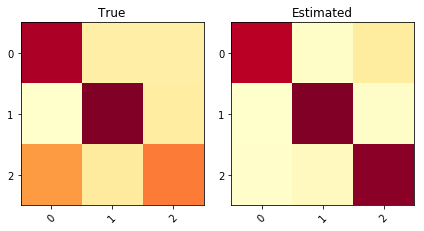

KL divergence: 0.5255	Pearson Correlation between diagonals: -0.1325


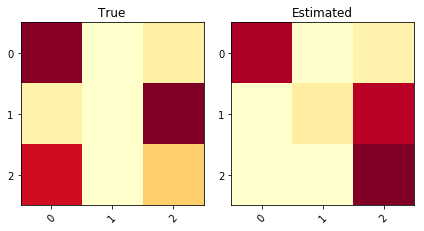

KL divergence: 1.1737	Pearson Correlation between diagonals: 0.6548


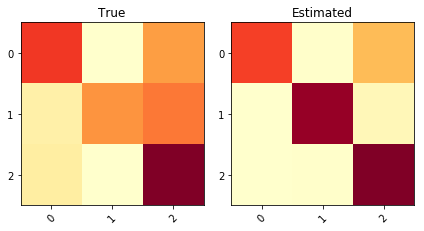

KL divergence: 0.4437	Pearson Correlation between diagonals: 0.2569


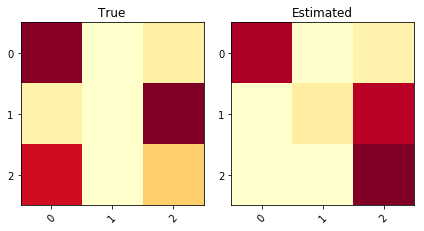

KL divergence: 1.1737	Pearson Correlation between diagonals: 0.6548


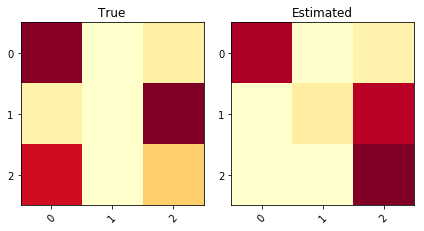

KL divergence: 1.1737	Pearson Correlation between diagonals: 0.6548


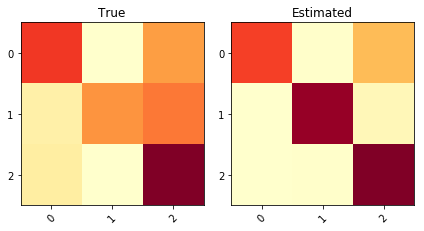

KL divergence: 0.4437	Pearson Correlation between diagonals: 0.2569


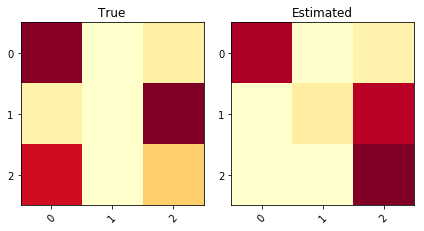

KL divergence: 1.1737	Pearson Correlation between diagonals: 0.6548


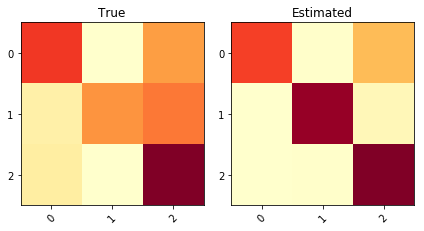

KL divergence: 0.4437	Pearson Correlation between diagonals: 0.2569
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.619455      0.619455      0.739096               0.322465
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.419242   0.397862     0.805833   0.300407            0.878571
   1         1  0.219029   0.324959     0.859913   0.204072            0.91253
   2         2  0.361729   0.255975     0.632247  

In [19]:
#con pre-entrenar 5
run_experiment(5) #funca relativamente bien en average normal. en multiples runs anda parecido

Conclu de mini experimento:
* Si se ejecuta normal necesario un buen init (pre entrenar 5)
* Si se ejecuta con multiples runs no es tann necesario un buen init (pre entrenar con 1 para que explore más)

In [106]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=5,dtype_op=DTYPE_OP) 
#gMixture.define_model("default cnn")
gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
logL_hists,i = gMixture.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.008445 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.03 sec)	logL: -23696.609	F1: 0.4583
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23223.120	Tol1: 0.01998	Tol2: 0.20717	Tol3: 0.03362	F1: 0.4648
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22878.412	Tol1: 0.01484	Tol2: 0.13867	Tol3: 0.00513	F1: 0.3968
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22514.547	Tol1: 0.01590	Tol2: 0.11352	Tol3: 0.00015	F1: 0.3858
Iter 5/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -22126.303	Tol1: 0.01724	Tol2: 0.10083	Tol3: 0.00115	F1: 0.3862
Iter 6/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -21728.080	Tol1: 0.01800	Tol2: 0.09836	Tol3: 0.00177	F1: 0.3875
Iter 7/50
M step: done,

M step: done,  E step: done //  (in 0.49 sec)	logL: -19079.178	Tol1: 0.00038	Tol2: 0.03262	Tol3: 0.00105	F1: 0.6553
Iter 38/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19074.208	Tol1: 0.00026	Tol2: 0.03216	Tol3: 0.00143	F1: 0.6589
Iter 39/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -19069.807	Tol1: 0.00023	Tol2: 0.02989	Tol3: 0.00125	F1: 0.6536
Iter 40/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19064.072	Tol1: 0.00030	Tol2: 0.02626	Tol3: 0.00146	F1: 0.6569
Iter 41/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19059.046	Tol1: 0.00026	Tol2: 0.02581	Tol3: 0.00127	F1: 0.6622
Iter 42/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19054.716	Tol1: 0.00023	Tol2: 0.02483	Tol3: 0.00129	F1: 0.6447
Iter 43/50
M step: done,  E step: done //  (in 0.44 sec)	logL: -19049.386	Tol1: 0.00028	Tol2: 0.02315	Tol3: 0.00187	F1: 0.6516
Iter 44/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -19045.314	Tol1: 0.00021	Tol2: 0.02385	Tol3: 0.00152	F1: 0.

M step: done,  E step: done //  (in 0.22 sec)	logL: -19409.672	Tol1: 0.00176	Tol2: 0.03251	Tol3: 0.00253	F1: 0.6475
Iter 25/50
M step: done,  E step: done //  (in 0.43 sec)	logL: -19384.601	Tol1: 0.00129	Tol2: 0.03332	Tol3: 0.00240	F1: 0.6512
Iter 26/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19362.505	Tol1: 0.00114	Tol2: 0.03413	Tol3: 0.00270	F1: 0.6553
Iter 27/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -19340.140	Tol1: 0.00116	Tol2: 0.03288	Tol3: 0.00295	F1: 0.6585
Iter 28/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19321.737	Tol1: 0.00095	Tol2: 0.03217	Tol3: 0.00272	F1: 0.6667
Iter 29/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -19299.918	Tol1: 0.00113	Tol2: 0.03027	Tol3: 0.00222	F1: 0.6687
Iter 30/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19278.746	Tol1: 0.00110	Tol2: 0.02981	Tol3: 0.00212	F1: 0.6646
Iter 31/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19265.898	Tol1: 0.00067	Tol2: 0.03072	Tol3: 0.00191	F1: 0.

M step: done,  E step: done //  (in 0.34 sec)	logL: -19522.214	Tol1: 0.00084	Tol2: 0.03481	Tol3: 0.00093	F1: 0.3582
Iter 30/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19508.417	Tol1: 0.00071	Tol2: 0.03565	Tol3: 0.00118	F1: 0.3573
Iter 31/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19496.558	Tol1: 0.00061	Tol2: 0.03498	Tol3: 0.00129	F1: 0.3582
Iter 32/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19477.549	Tol1: 0.00098	Tol2: 0.03295	Tol3: 0.00113	F1: 0.3573
Iter 33/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19464.043	Tol1: 0.00069	Tol2: 0.03513	Tol3: 0.00146	F1: 0.3569
Iter 34/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19443.410	Tol1: 0.00106	Tol2: 0.03541	Tol3: 0.00179	F1: 0.3582
Iter 35/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19429.950	Tol1: 0.00069	Tol2: 0.03439	Tol3: 0.00056	F1: 0.3573
Iter 36/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -19414.941	Tol1: 0.00077	Tol2: 0.03435	Tol3: 0.00136	F1: 0.

M step: done,  E step: done //  (in 0.16 sec)	logL: -19207.335	Tol1: 0.00072	Tol2: 0.02491	Tol3: 0.00186	F1: 0.7570
Iter 33/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19196.797	Tol1: 0.00055	Tol2: 0.02462	Tol3: 0.00127	F1: 0.7558
Iter 34/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19185.709	Tol1: 0.00058	Tol2: 0.02419	Tol3: 0.00132	F1: 0.7521
Iter 35/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19172.883	Tol1: 0.00067	Tol2: 0.02384	Tol3: 0.00097	F1: 0.7631
Iter 36/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19164.194	Tol1: 0.00045	Tol2: 0.02309	Tol3: 0.00111	F1: 0.7611
Iter 37/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19154.413	Tol1: 0.00051	Tol2: 0.02252	Tol3: 0.00160	F1: 0.7546
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19147.294	Tol1: 0.00037	Tol2: 0.02224	Tol3: 0.00119	F1: 0.7562
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19137.774	Tol1: 0.00050	Tol2: 0.02128	Tol3: 0.00162	F1: 0.

M step: done,  E step: done //  (in 0.17 sec)	logL: -19599.961	Tol1: 0.00140	Tol2: 0.02527	Tol3: 0.00197	F1: 0.5458
Iter 32/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19577.978	Tol1: 0.00112	Tol2: 0.02380	Tol3: 0.00186	F1: 0.5584
Iter 33/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19555.257	Tol1: 0.00116	Tol2: 0.02354	Tol3: 0.00169	F1: 0.5739
Iter 34/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19532.424	Tol1: 0.00117	Tol2: 0.02460	Tol3: 0.00180	F1: 0.5804
Iter 35/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19510.402	Tol1: 0.00113	Tol2: 0.02545	Tol3: 0.00187	F1: 0.5934
Iter 36/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19490.042	Tol1: 0.00104	Tol2: 0.02492	Tol3: 0.00165	F1: 0.5999
Iter 37/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19474.857	Tol1: 0.00078	Tol2: 0.02666	Tol3: 0.00154	F1: 0.5987
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19453.954	Tol1: 0.00107	Tol2: 0.02884	Tol3: 0.00229	F1: 0.

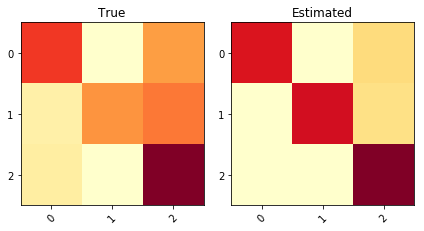

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


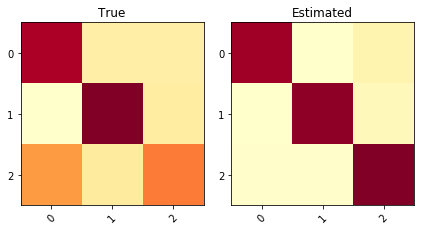

KL divergence: 0.4571	Pearson Correlation between diagonals: -0.7542


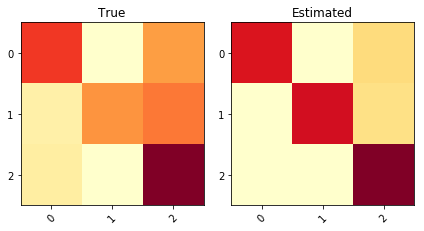

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


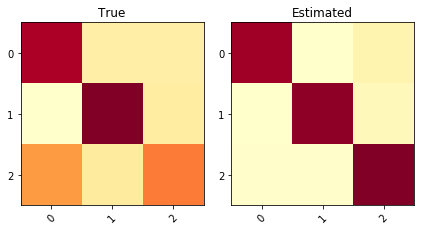

KL divergence: 0.4571	Pearson Correlation between diagonals: -0.7542


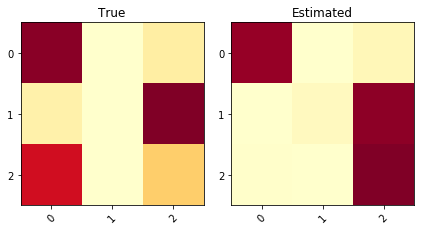

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


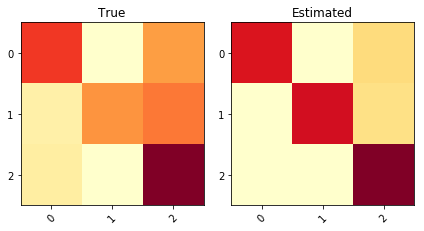

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


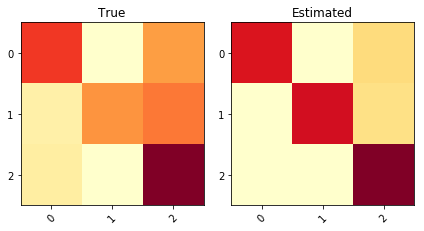

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


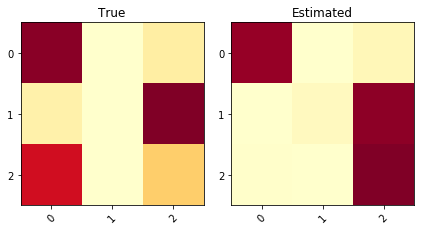

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


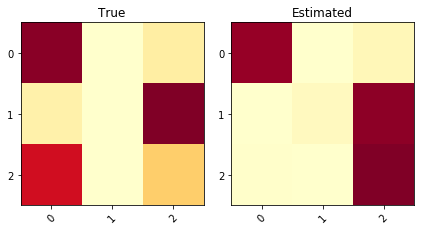

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


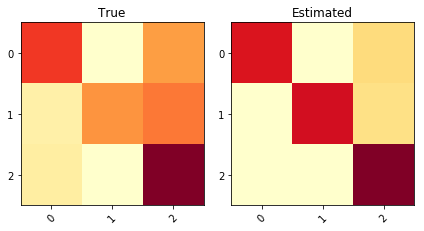

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


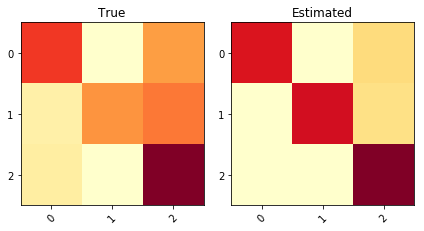

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


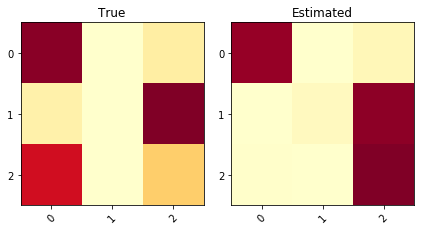

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


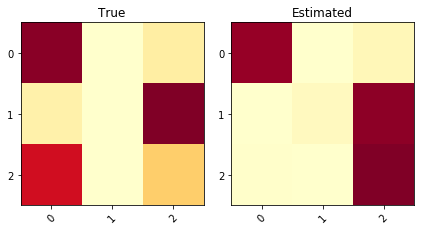

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


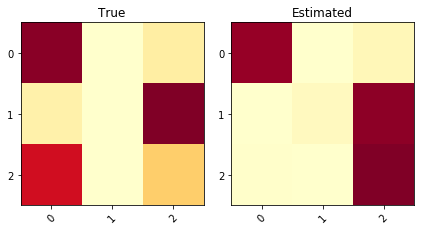

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


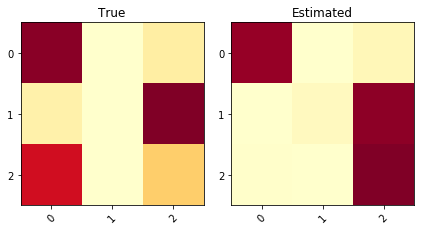

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |     0.6744 |       0.6744 |     0.635707 |              0.532278 |       0.186749 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.675214 |     0.675214 |
+----+--------+------------+--------------+


In [105]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred) #PCA

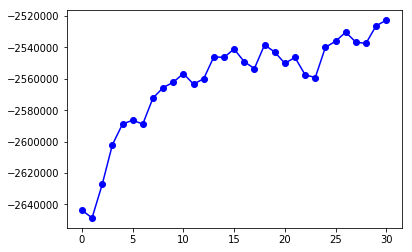

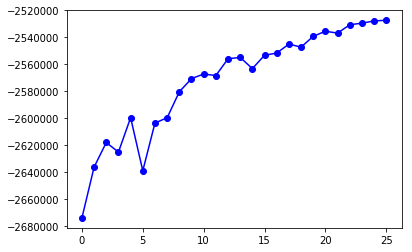

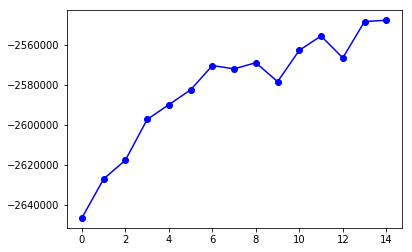

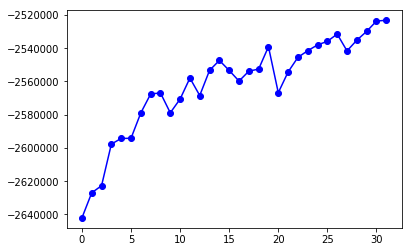

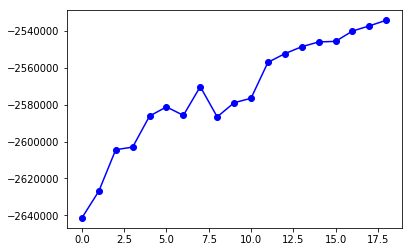

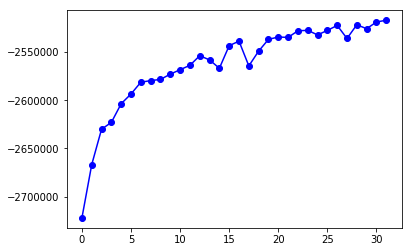

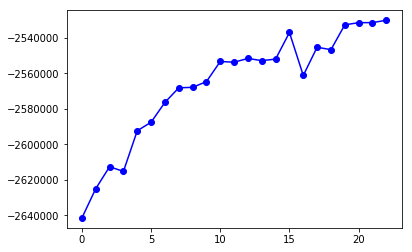

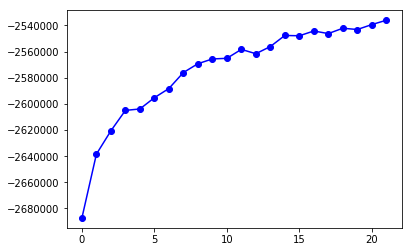

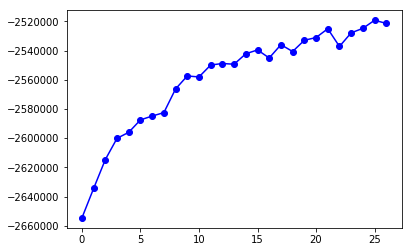

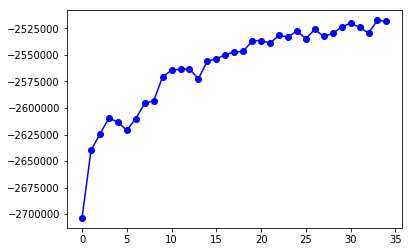

Calculated with 46 anotations
Calculated with 45 anotations
Calculated with 35 anotations
Calculated with 43 anotations
Calculated with 43 anotations
Calculated with 42 anotations
Calculated with 47 anotations
Calculated with 47 anotations
Calculated with 42 anotations
Calculated with 39 anotations
Calculated with 41 anotations
Calculated with 33 anotations
Calculated with 41 anotations
Calculated with 56 anotations
Calculated with 43 anotations
Calculated with 38 anotations
Calculated with 45 anotations
Calculated with 41 anotations
Calculated with 35 anotations
Calculated with 37 anotations
Calculated with 39 anotations
Calculated with 34 anotations
Calculated with 42 anotations
Calculated with 46 anotations
Calculated with 45 anotations
Calculated with 42 anotations
Calculated with 49 anotations
Calculated with 44 anotations
Calculated with 44 anotations
Calculated with 42 anotations
Calculated with 47 anotations
Calculated with 50 anotations
Calculated with 36 anotations
Calculated

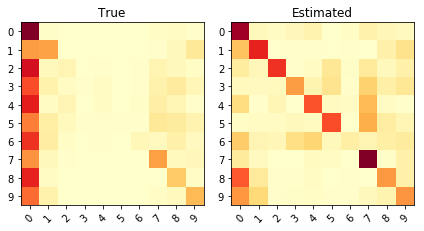

KL divergence: 0.7632	Pearson Correlation between diagonals: 0.6004


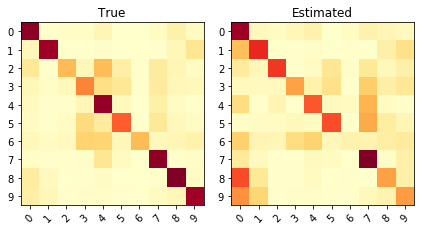

KL divergence: 0.3348	Pearson Correlation between diagonals: 0.5008


KL divergence: 0.3334	Pearson Correlation between diagonals: 0.5016


KL divergence: 0.7558	Pearson Correlation between diagonals: 0.6138


KL divergence: 0.7706	Pearson Correlation between diagonals: 0.5911


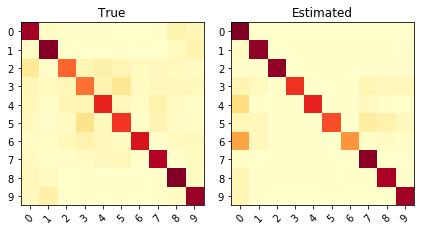

KL divergence: 0.5478	Pearson Correlation between diagonals: 0.4866


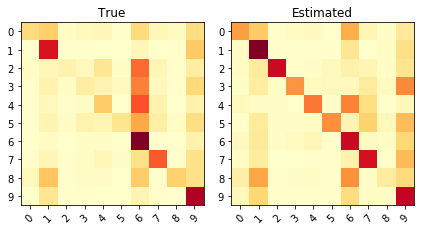

KL divergence: 0.3609	Pearson Correlation between diagonals: 0.6421


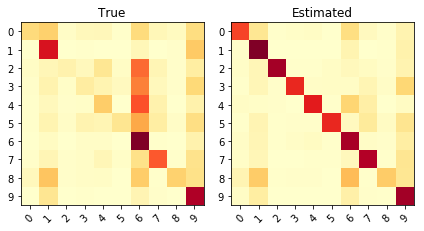

KL divergence: 0.5268	Pearson Correlation between diagonals: 0.5288


KL divergence: 0.7092	Pearson Correlation between diagonals: 0.4583


KL divergence: 0.7706	Pearson Correlation between diagonals: 0.5911


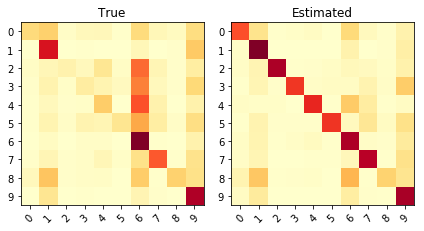

KL divergence: 0.4846	Pearson Correlation between diagonals: 0.5504


KL divergence: 0.6356	Pearson Correlation between diagonals: 0.4831


KL divergence: 0.3336	Pearson Correlation between diagonals: 0.5014


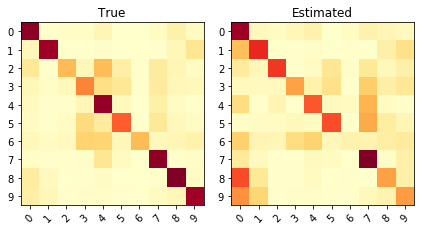

KL divergence: 0.3348	Pearson Correlation between diagonals: 0.5008


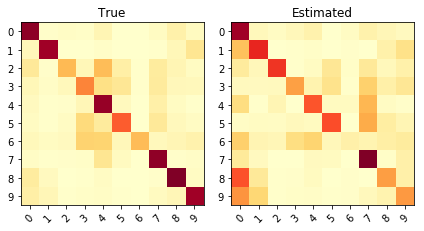

KL divergence: 0.3282	Pearson Correlation between diagonals: 0.5034
A result
 +----+---------+------------+--------------+
|    |   Group |   Accuracy |   F1 (micro) |
|----+---------+------------+--------------|
|  0 |       0 |    0.39726 |      0.39726 |
|  1 |       1 |    0.66312 |      0.66312 |
|  2 |       2 |    0.45264 |      0.45264 |
|  3 |       3 |    0.652   |      0.652   |
+----+---------+------------+--------------+
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.70168 |      0.70168 |     0.565168 |              0.530104 |       0.173584 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
Test
A result
 +----+--------+------------+---------

In [49]:
for value in logL_hists:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()
#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...


from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

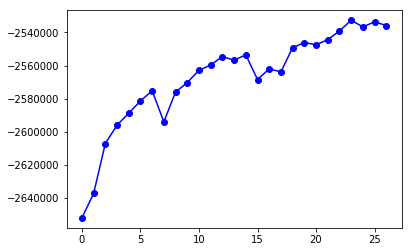

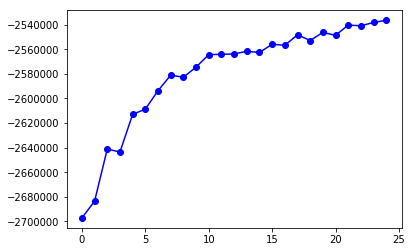

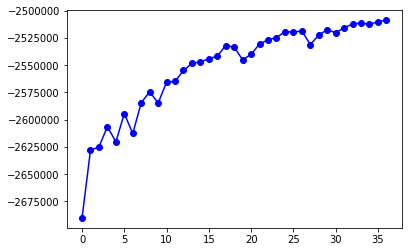

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


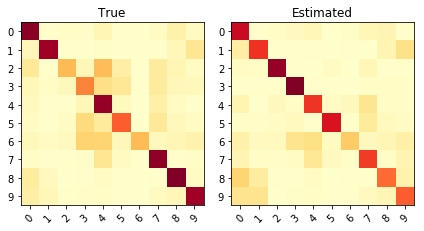

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


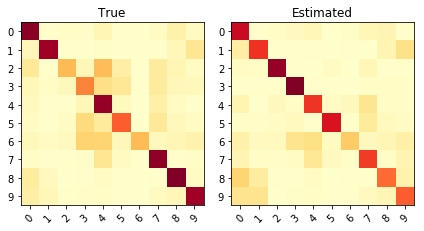

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


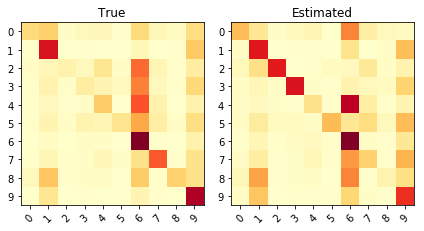

KL divergence: 0.4043	Pearson Correlation between diagonals: 0.4524


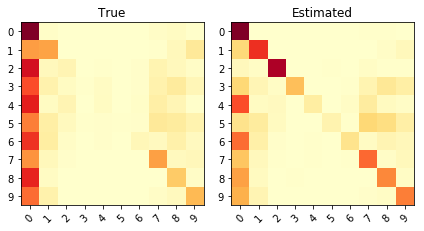

KL divergence: 0.3755	Pearson Correlation between diagonals: 0.7225


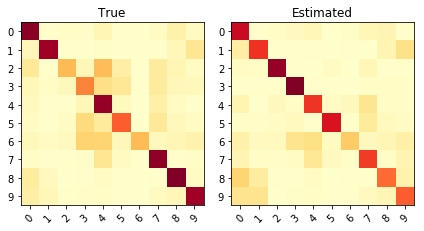

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


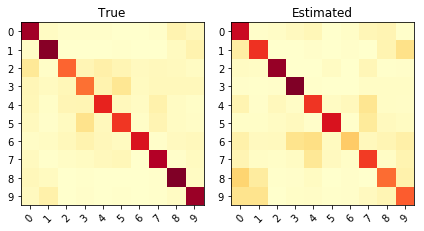

KL divergence: 0.3269	Pearson Correlation between diagonals: -0.5288


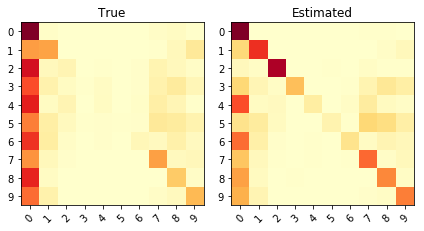

KL divergence: 0.3755	Pearson Correlation between diagonals: 0.7225


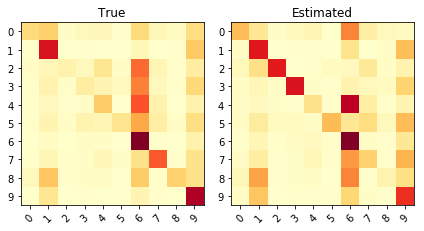

KL divergence: 0.4043	Pearson Correlation between diagonals: 0.4524


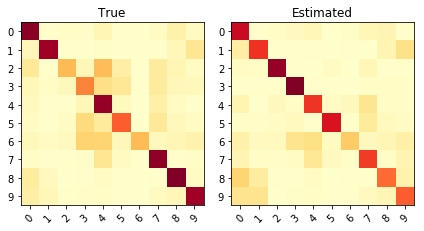

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


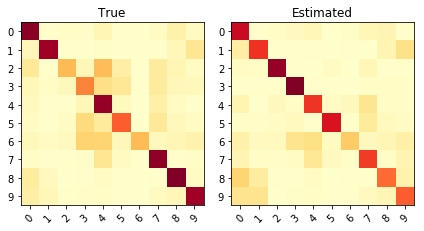

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


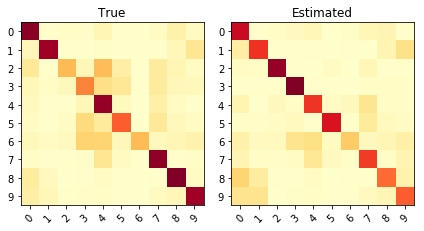

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


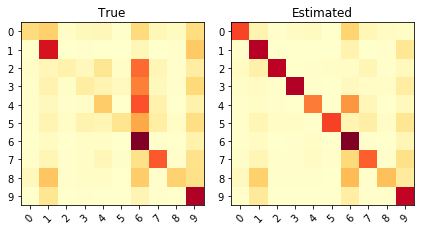

KL divergence: 0.5180	Pearson Correlation between diagonals: 0.4246


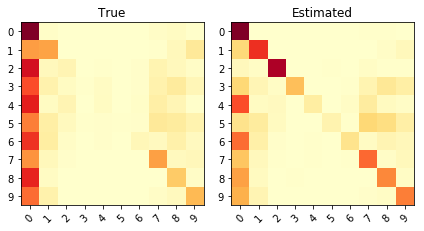

KL divergence: 0.3755	Pearson Correlation between diagonals: 0.7225


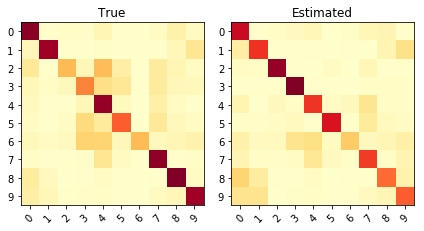

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097
A result
 +----+---------+------------+--------------+
|    |   Group |   Accuracy |   F1 (micro) |
|----+---------+------------+--------------|
|  0 |       0 |    0.6938  |      0.6938  |
|  1 |       1 |    0.81774 |      0.81774 |
|  2 |       2 |    0.47102 |      0.47102 |
|  3 |       3 |    0.29708 |      0.29708 |
+----+---------+------------+--------------+
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.73642 |      0.73642 |     0.424449 |              0.299343 |       0.123497 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
Test
A result
 +----+--------+------------+--------

In [35]:
for value in logL_hist:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()

from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

KL divergence: 0.3546	Pearson Correlation between diagonals: 0.8887


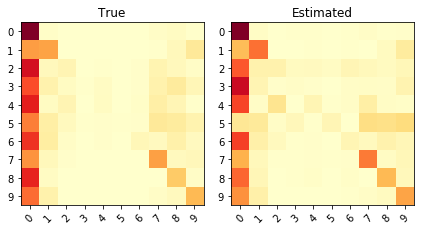

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908


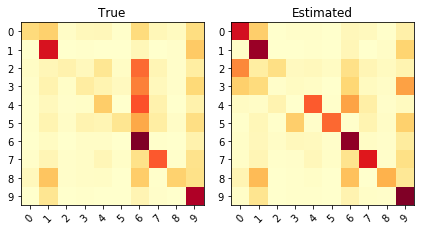

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


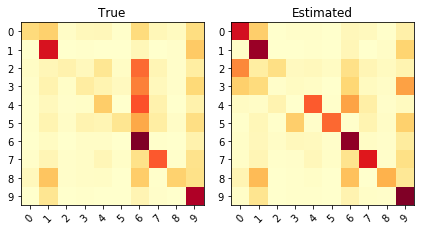

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


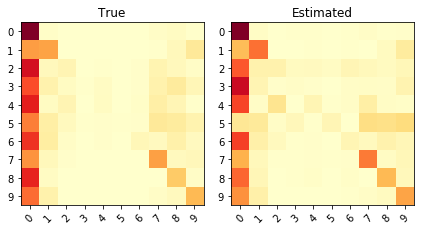

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908


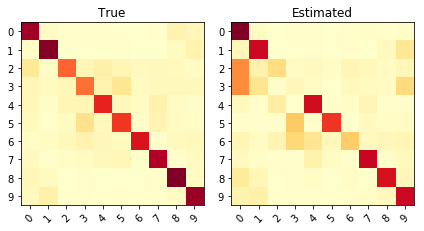

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.7942


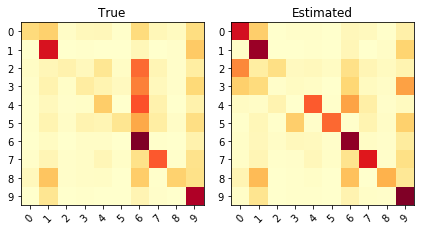

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


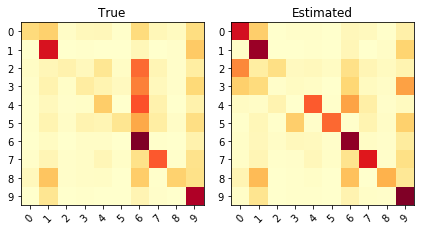

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


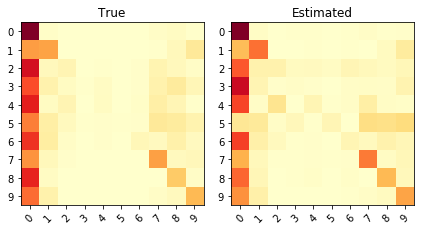

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908


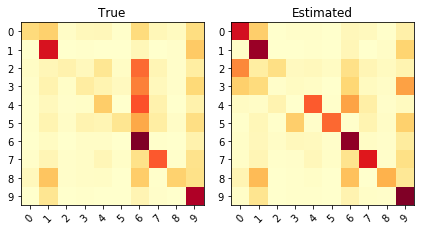

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


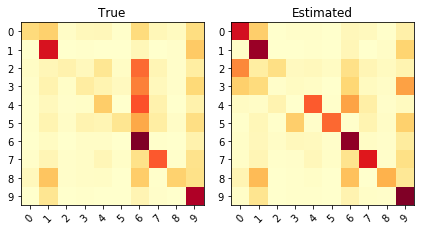

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


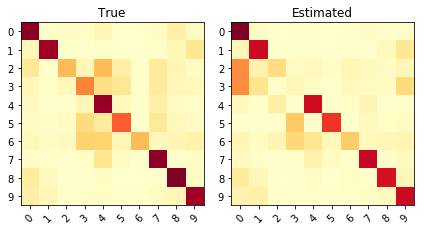

KL divergence: 0.3546	Pearson Correlation between diagonals: 0.8887


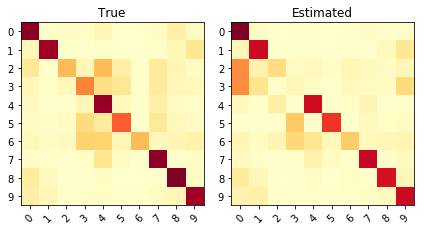

KL divergence: 0.3546	Pearson Correlation between diagonals: 0.8887


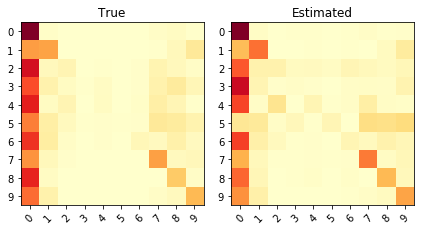

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908


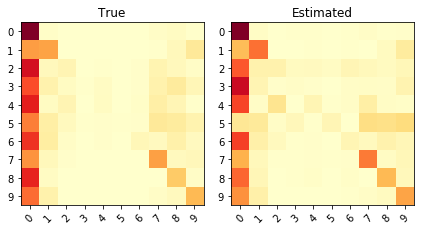

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908
A result
 +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |     0.5755 |             0.5755 |
|  1 |       1 |     0.2787 |             0.2787 |
|  2 |       2 |     0.7628 |             0.7628 |
+----+---------+------------+--------------------+
A result
 +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |     0.6977 |             0.6977 |     0.299974 |              0.883754 |       0.158787 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
Test
A result
 +----+----

In [16]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [40]:
%%time
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.41 sec)	logL: -85843.819	F1: 0.7442
Iter 2/25
M step: done	E step: done, (in 2.47 sec)	logL: -83639.140	Tol: 0.02568	F1: 0.7286
Iter 3/25
M step: done	E step: done, (in 2.33 sec)	logL: -82040.527	Tol: 0.01911	F1: 0.7178
Iter 4/25
M step: done	E step: done, (in 2.31 sec)	logL: -81027.269	Tol: 0.01235	F1: 0.7117
Iter 5/25
M step: done	E step: done, (in 2.37 sec)	logL: -80444.867	Tol: 0.00719	F1: 0.7142
Iter 6/25
M step: done	E step: done, (in 2.39 sec)	logL: -80116.539	Tol: 0.00408	F1: 0.7248
Iter 7/25
M step: done	E step: done, (in 2.43 sec)	logL: -79915.121	Tol: 0.00251	F1: 0.7397
Iter 8/25
M step: done	E step: done, (in 2.43 sec)	logL: -79781.112	Tol: 0.00168	F1: 0.7502
Iter 9/25
M step: done	E step: done, (in 2.42 sec)	logL: -79677

In [143]:
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=7,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',256,2)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.40107749624626565, 0.6643001499237149, 0.5331640955460885, 0.1617082682059309, 0.46440295869359777, 0.3517687543555905, 0.7898108127238789]
Alphas:  (2700, 7)
MV init:  (2700, 3)
Betas:  (7, 3, 3)
Q estimate:  (2700, 3, 7, 3)
Iter 1/25
M step: done	E step: done, (in 1.96 sec)	logL: -80827.414	
Iter 2/25
M step: done	E step: done, (in 1.88 sec)	logL: -80249.518	Tol: 0.00715	
Iter 3/25
M step: done	E step: done, (in 1.90 sec)	logL: -79907.925	Tol: 0.00426	
Iter 4/25
M step: done	E step: done, (in 1.90 sec)	logL: -79695.919	Tol: 0.00265	
Iter 5/25
M step: done	E step: done, (in 1.90 sec)	logL: -79573.557	Tol: 0.00154	
Iter 6/25
M step: done	E step: done, (in 1.92 sec)	logL: -79498.354	Tol: 0.00095	
Iter 7/25
M step: done	E step: done, (in 1.89 sec)	logL: -79452.646	Tol: 0.00057	
Iter 8/25
M step: done	E step: done, (in 1.90 sec)	logL: -79421.224	Tol: 0.00040	
Iter 9/25
M step: done	E step:

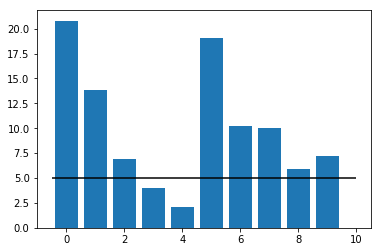

In [63]:
plt.bar(np.arange(M),gMixture.get_alpha()*100)
plt.hlines(5,-0.5,M) #treshold en Numero de anotadores x grupo--quizas no sirva...
#que pasa si hay un grupo que tiene 5 anotadores y otro que tiene 10 pero se comparte con otro que tiene 1?
#sirve para tener una idea general de cuantos anotadores x grupo hay

In [44]:
print("Stable training (global alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Stable training (global alpha)


<Table length=1>
    Acccuracy       F1 score (micro)   F1 score (macro) 
     float64            float64            float64      
------------------ ------------------ ------------------
0.9403703703703704 0.9392316242866506 0.9403703703703703

In [46]:
print("Multiples runs (global alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Multiples runs (global alpha)


<Table length=1>
Acccuracy  F1 score (micro)  F1 score (macro)
 float64       float64           float64     
--------- ------------------ ----------------
     0.96 0.9595173521330044             0.96

In [52]:
print("Multiples runs (data alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Multiples runs (data alpha)


<Table length=1>
    Acccuracy       F1 score (micro)   F1 score (macro) 
     float64            float64            float64      
------------------ ------------------ ------------------
0.9403703703703704 0.9396247669605527 0.9403703703703703

In [69]:
### comparar resultados con mas grupos o menos grupos
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.50 sec)	logL: -84431.118	F1: 0.8277
Iter 2/25
M step: done	E step: done, (in 2.49 sec)	logL: -82027.963	Tol: 0.02846	F1: 0.8218
Iter 3/25
M step: done	E step: done, (in 2.42 sec)	logL: -80732.001	Tol: 0.01580	F1: 0.8196
Iter 4/25
M step: done	E step: done, (in 2.41 sec)	logL: -80087.666	Tol: 0.00798	F1: 0.8191
Iter 5/25
M step: done	E step: done, (in 2.36 sec)	logL: -79755.607	Tol: 0.00415	F1: 0.8215
Iter 6/25
M step: done	E step: done, (in 2.40 sec)	logL: -79562.342	Tol: 0.00242	F1: 0.8249
Iter 7/25
M step: done	E step: done, (in 2.41 sec)	logL: -79413.819	Tol: 0.00187	F1: 0.8332
Iter 8/25
M step: done	E step: done, (in 2.39 sec)	logL: -79296.041	Tol: 0.00148	F1: 0.8391
Iter 9/25
M step: done	E step: done, (in 2.36 sec)	logL: -79187

In [68]:
#and multiples runs
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.00738633966784168, 0.033873725693389055]
Alphas:  (2,)
MV init:  (2700, 3)
Betas:  (2, 3, 3)
Q estimate:  (2700, 3, 2, 3)
Iter 1/25
M step: done	E step: done, (in 1.03 sec)	logL: -84088.130	
Iter 2/25
M step: done	E step: done, (in 1.23 sec)	logL: -82295.538	Tol: 0.02132	
Iter 3/25
M step: done	E step: done, (in 1.01 sec)	logL: -81493.772	Tol: 0.00974	
Iter 4/25
M step: done	E step: done, (in 1.05 sec)	logL: -81109.277	Tol: 0.00472	
Iter 5/25
M step: done	E step: done, (in 1.08 sec)	logL: -80929.009	Tol: 0.00222	
Iter 6/25
M step: done	E step: done, (in 1.05 sec)	logL: -80839.120	Tol: 0.00111	
Iter 7/25
M step: done	E step: done, (in 1.00 sec)	logL: -80784.744	Tol: 0.00067	
Iter 8/25
M step: done	E step: done, (in 0.98 sec)	logL: -80757.410	Tol: 0.00034	
Iter 9/25
M step: done	E step: done, (in 0.99 sec)	logL: -80739.910	Tol: 0.00022	
Finished training!
Initializing new EM...
Pre-train 

In [67]:
#si eliminamos las matrices extras? a traves de p(g|t)--aun no se implementa

gMixture.get_confusionM()
#clean

gMixture.betas = gMixture.get_confusionM() #cleaned
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

    Acccuracy       F1 score (micro)   F1 score (macro) 
------------------ ------------------ ------------------
0.8748148148148148 0.8708596576177706 0.8748148148148148


In [56]:
groups_annot_pred = np.argmax(prob_Gt,axis=1)
print(groups_annot_pred)
print(set(groups_annot_pred)) #revisar fast el numero de grupos utilizados...

[2 2 1 2 0 2 2 0 0 1 0 1 2 2 0 0 0 0 1 1 0 1 0 2 0 2 2 2 0 0 2 2 1 2 2 1 1
 1 0 2 1 2 0 0 1 0 1 0 1 0 0 2 1 2 2 0 0 1 1 2 1 0 1 2 2 0 2 0 2 0 0 2 2 0
 2 1 0 2 1 2 0 2 0 1 2 0 0 0 2 0 1 0 0 0 2 0 1 0 0 0]
{0, 1, 2}
CPU times: user 32.9 s, sys: 635 ms, total: 33.6 s
Wall time: 33 s


In [41]:
#obtain p(y^o|x,g=m)
gMixture.get_predictions_group(1,Xstd_train) #puedo medir acc con eso

array([[0.22092701, 0.66987641, 0.10919658],
       [0.18366501, 0.769683  , 0.04665199],
       [0.36506755, 0.28602405, 0.34890843],
       ...,
       [0.18930534, 0.75472514, 0.0559695 ],
       [0.33724762, 0.3600254 , 0.30272705],
       [0.44818453, 0.03039722, 0.5214183 ]])

### Posible problema: en la inicialización parta muy "fuerte", itere poco  y no deje al modelo predictivo aprender lo suficiente de los datos.

In [332]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') #how to use it is in evaluation_mrtric file

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

CPU times: user 15 µs, sys: 1e+03 ns, total: 16 µs
Wall time: 21.9 µs


There are 100 real and 100 predicted Conf matrices


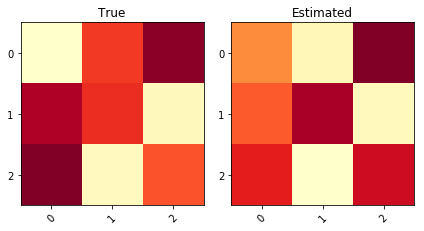

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


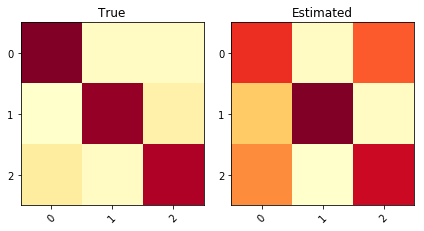

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


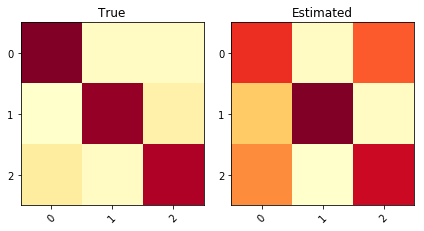

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


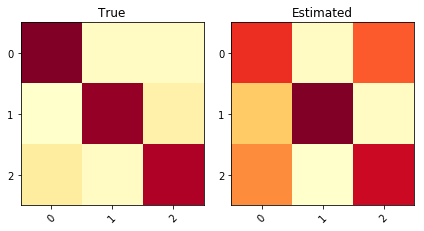

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


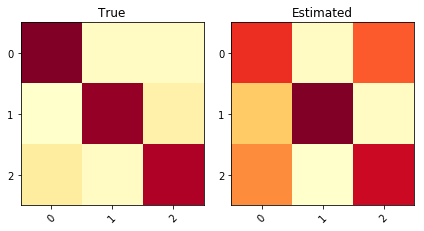

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


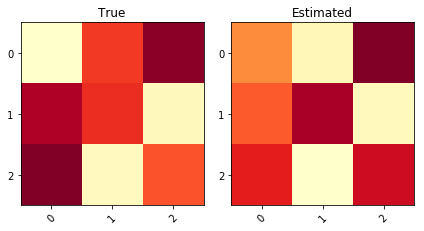

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


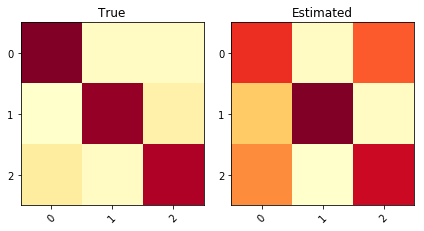

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


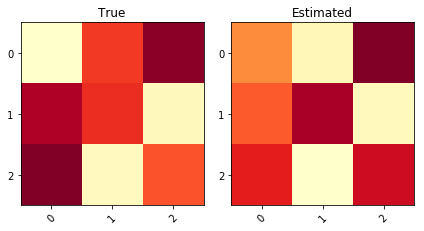

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


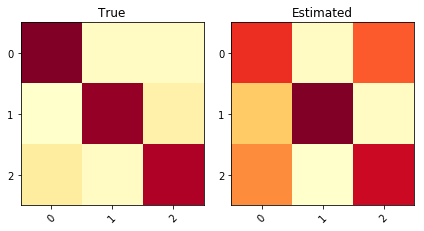

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


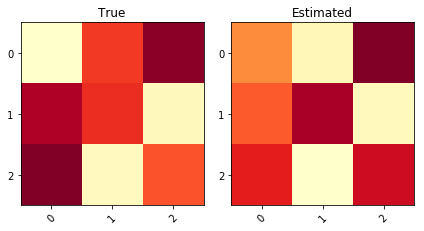

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


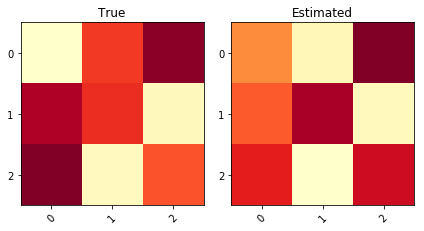

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


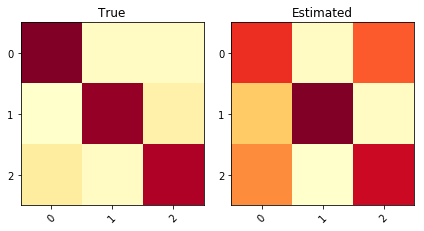

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


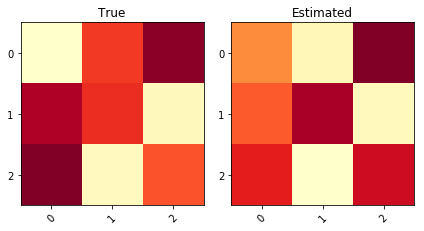

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


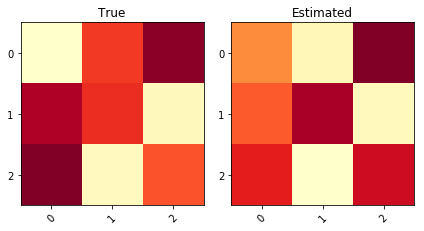

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


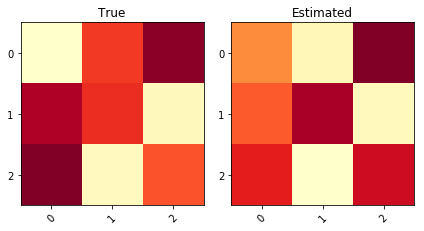

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


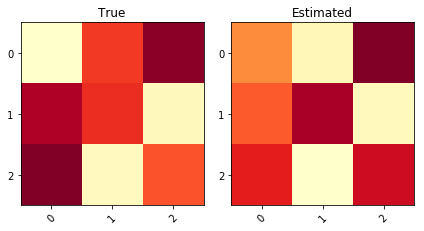

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


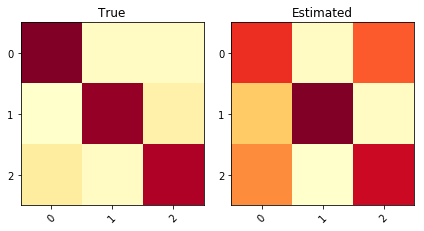

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


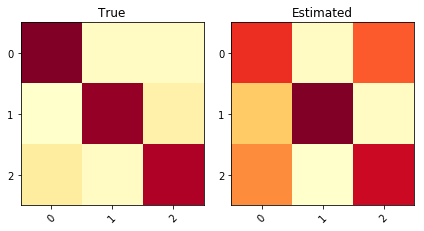

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


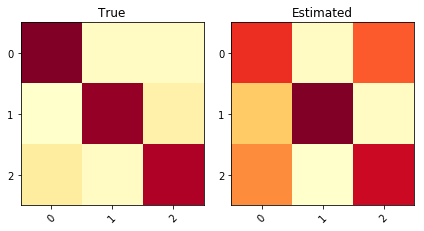

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


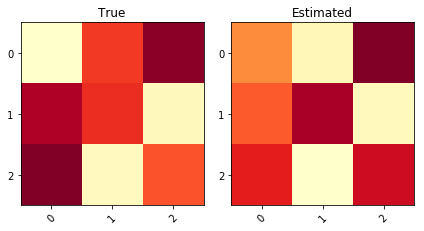

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


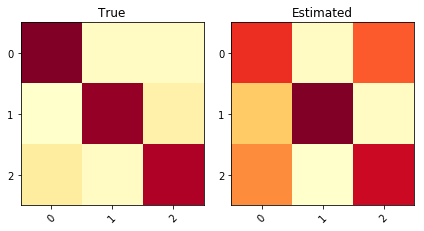

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


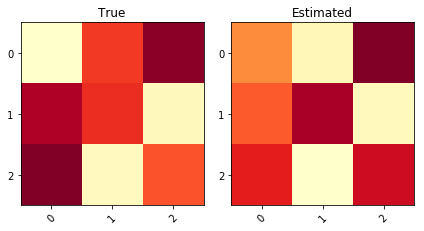

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


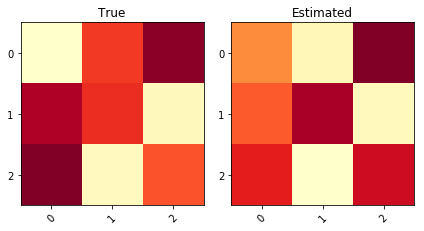

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


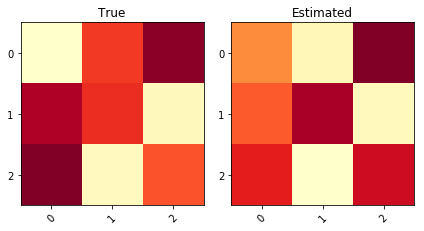

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


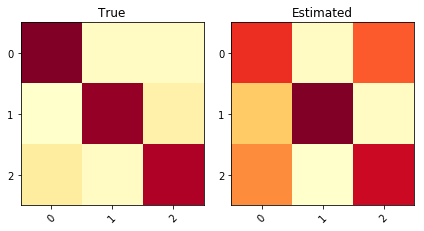

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


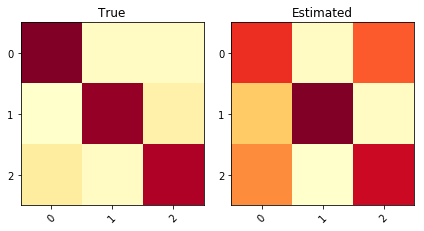

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


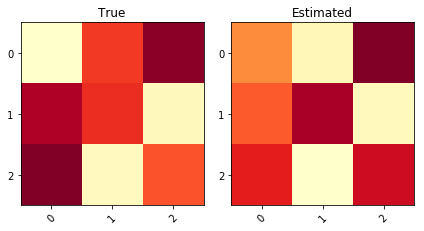

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


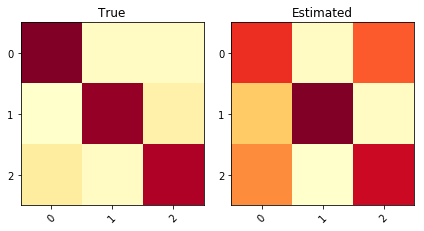

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


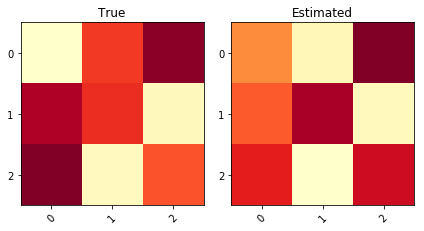

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


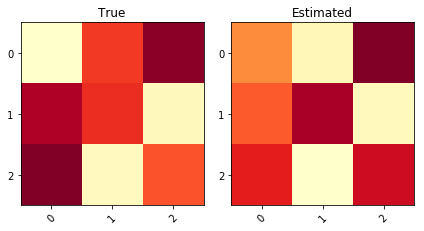

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


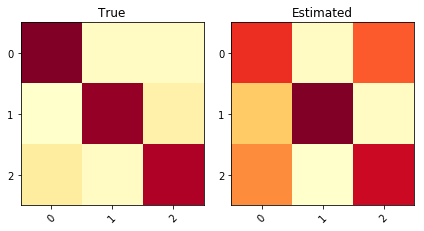

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


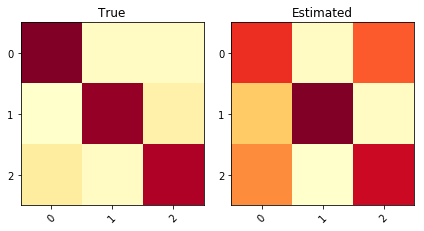

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


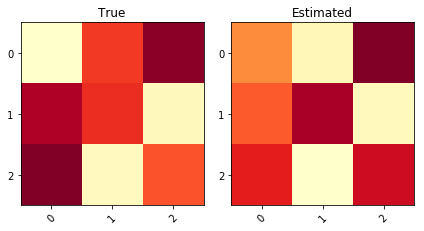

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


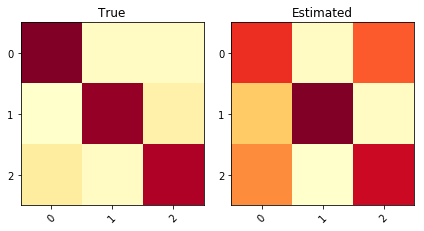

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


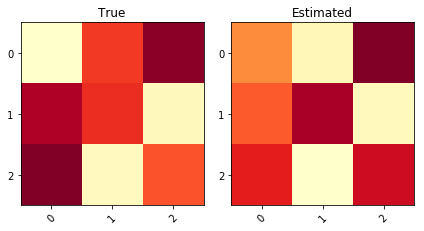

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


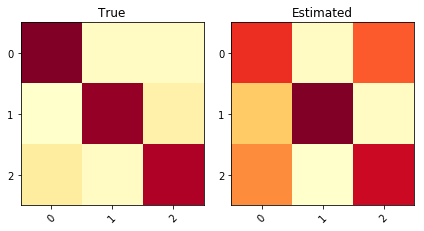

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


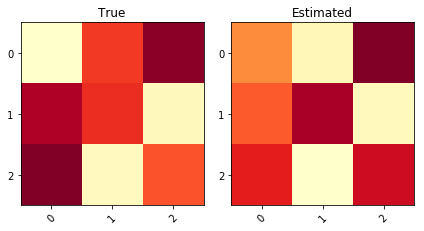

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


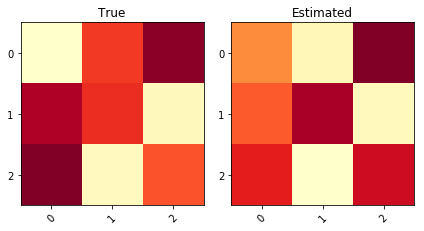

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


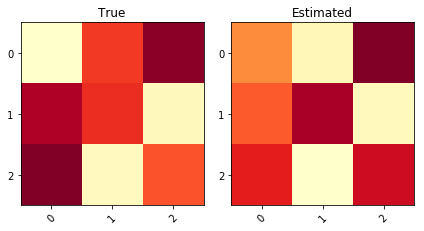

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


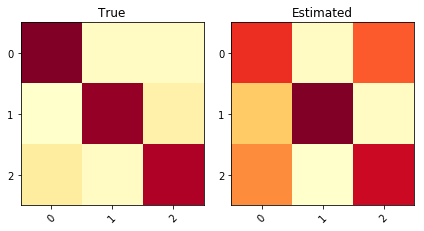

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


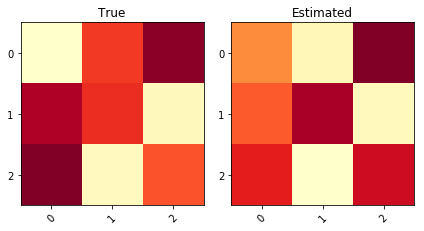

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


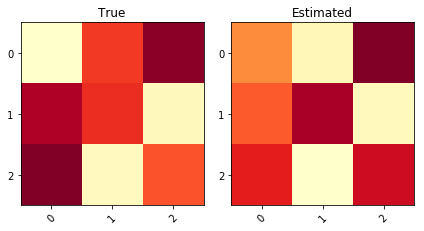

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


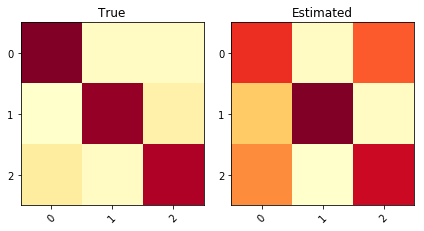

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


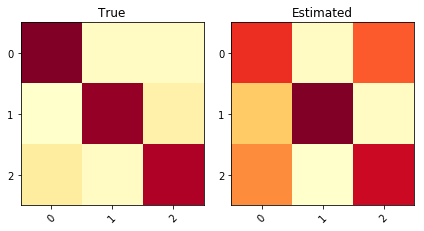

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


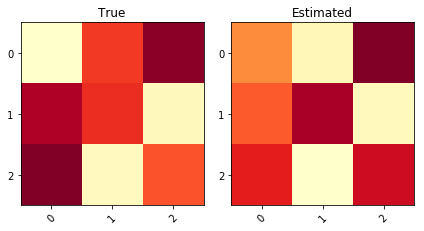

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


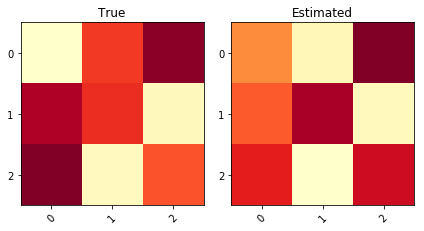

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


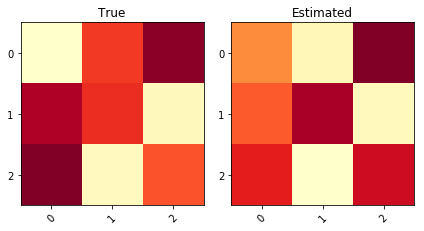

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


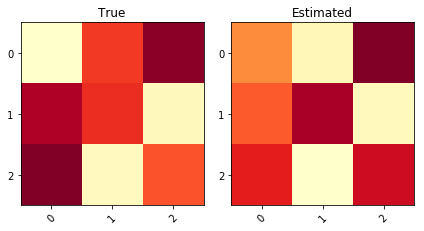

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


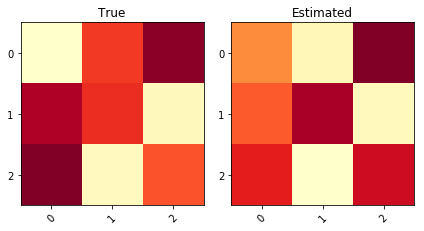

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


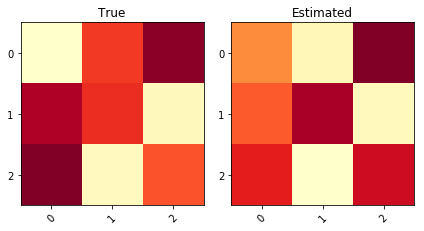

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


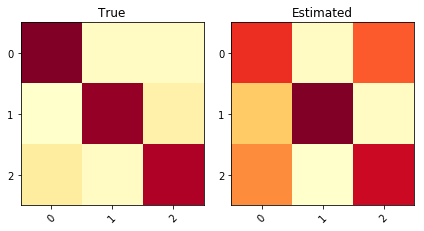

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


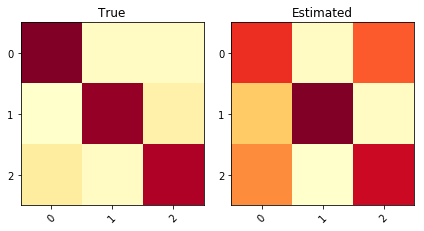

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


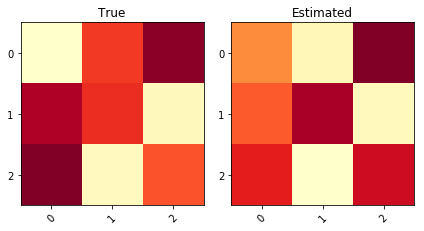

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


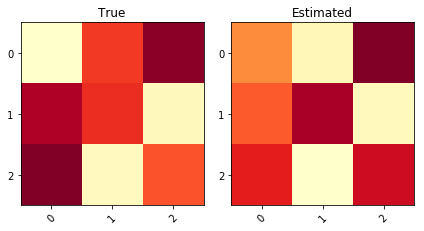

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


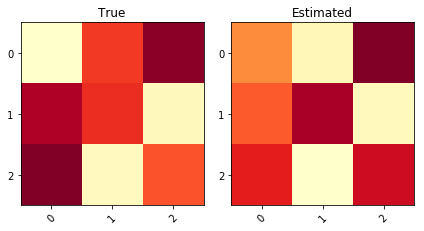

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


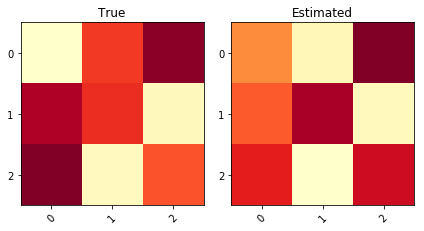

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


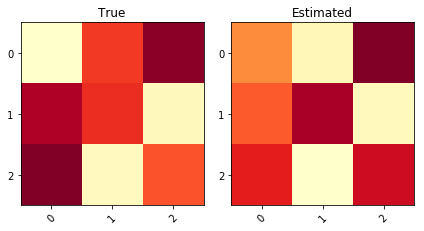

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


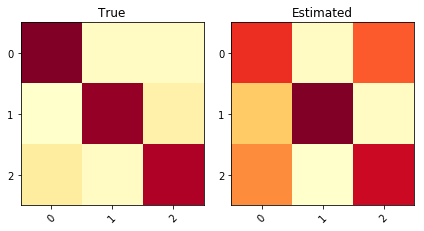

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


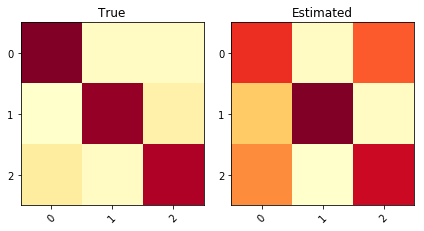

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


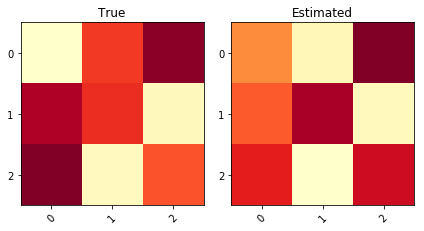

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


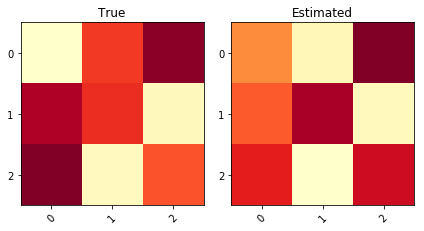

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


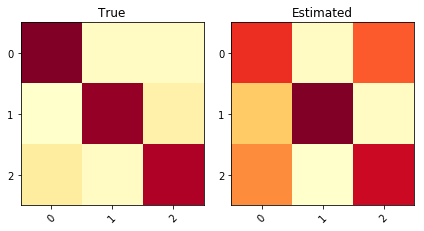

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


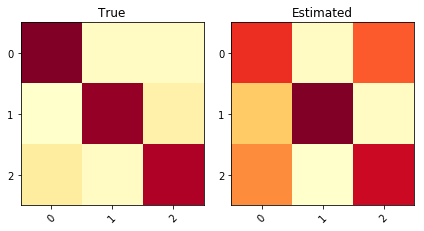

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


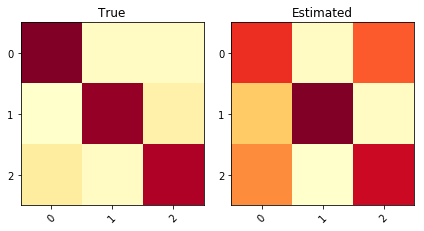

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


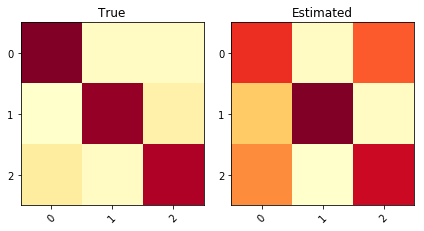

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


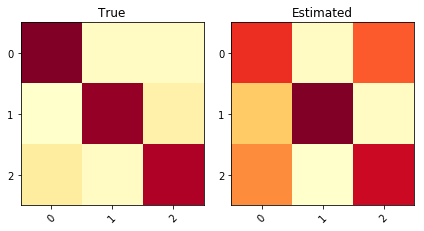

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


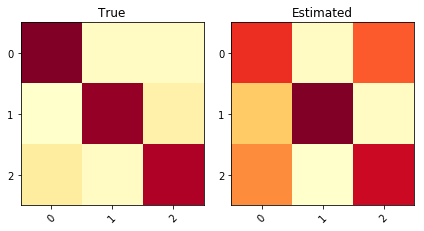

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


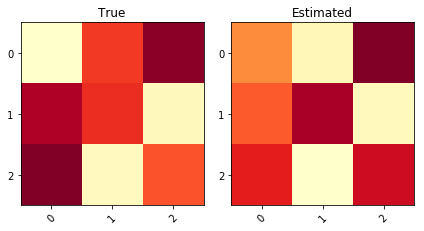

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


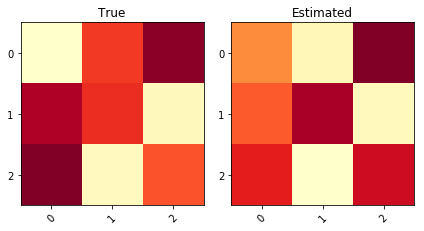

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


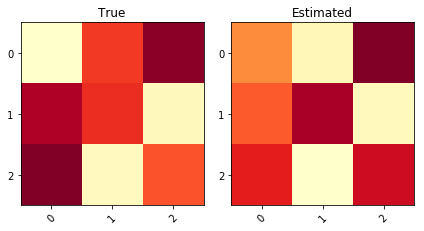

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


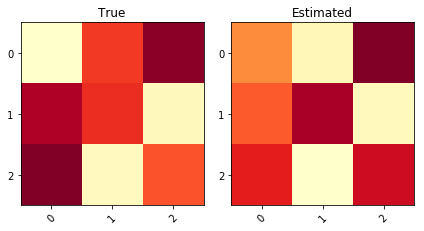

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


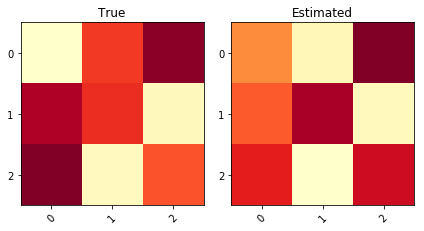

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


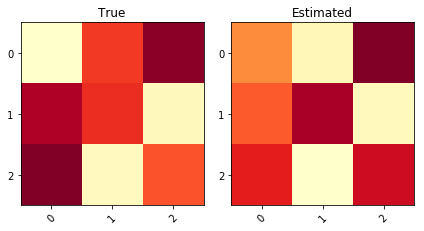

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


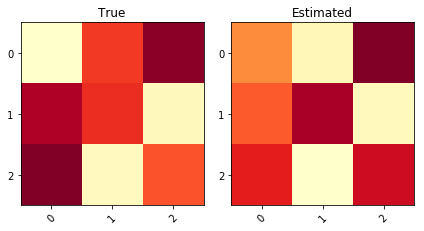

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


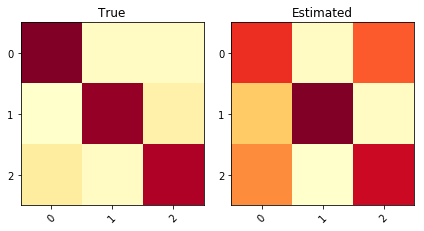

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


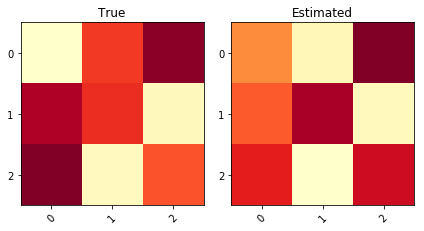

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


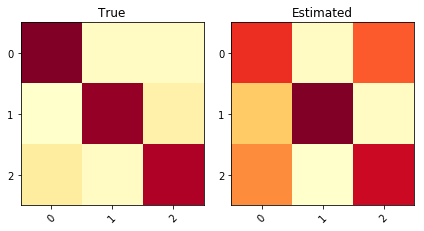

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


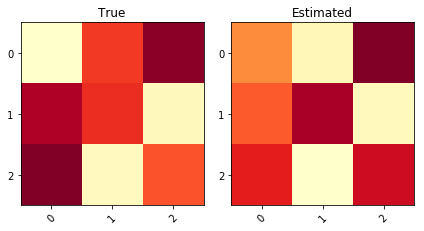

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


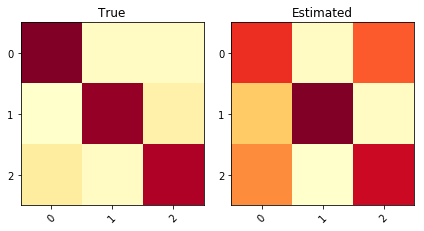

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


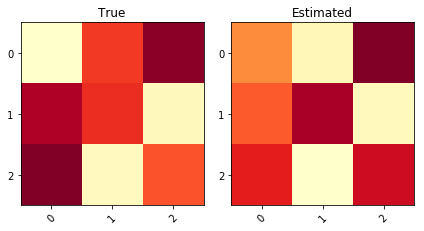

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


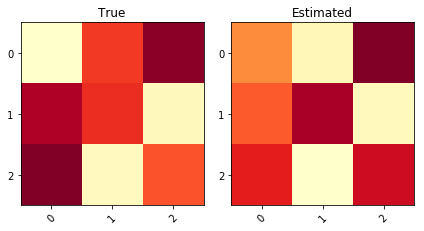

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


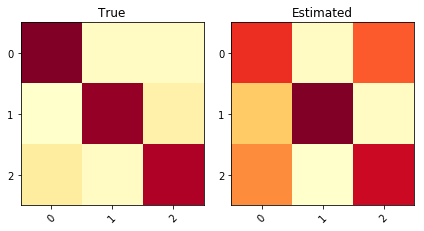

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


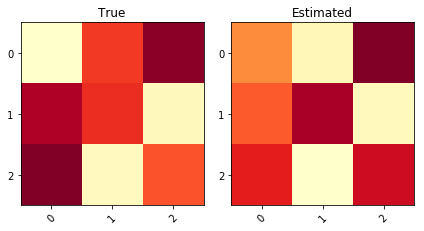

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


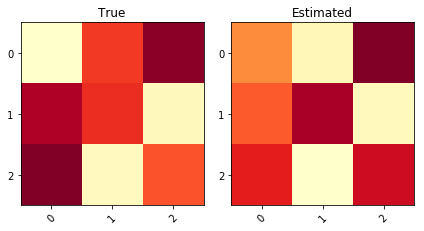

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


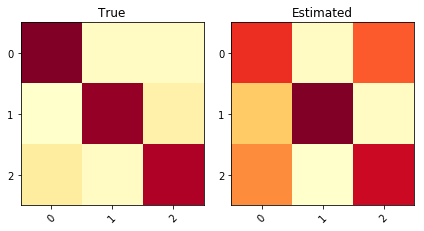

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


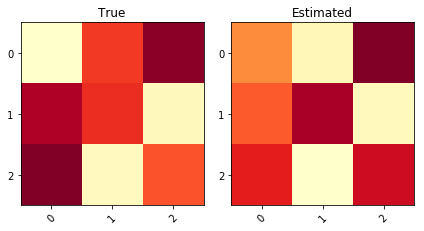

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


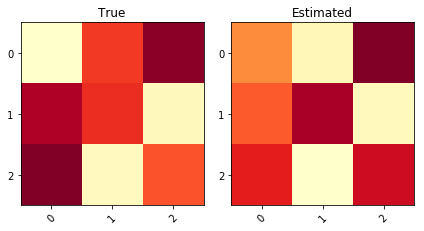

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


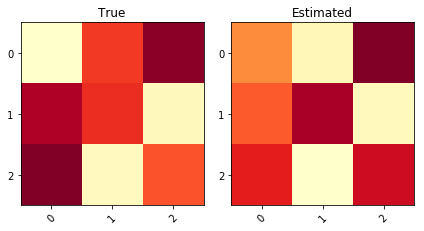

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


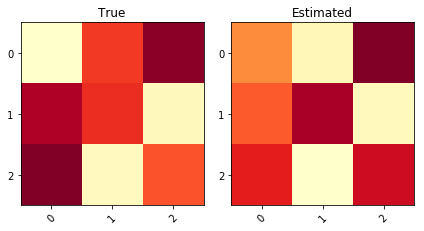

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


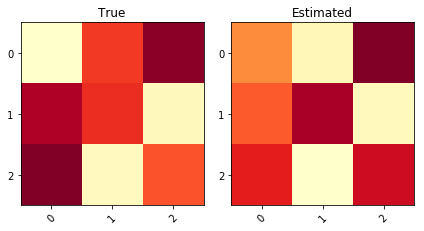

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


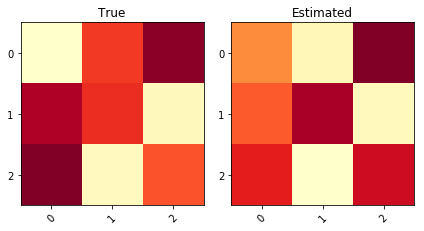

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


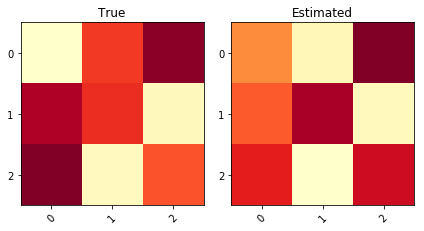

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


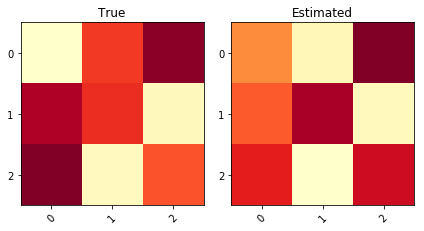

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


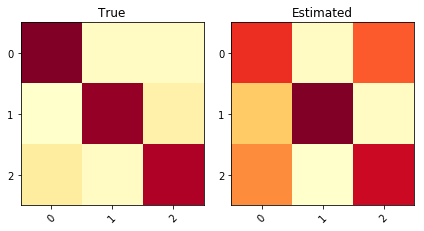

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


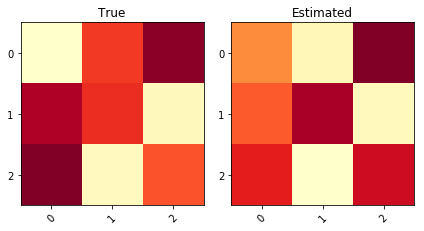

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


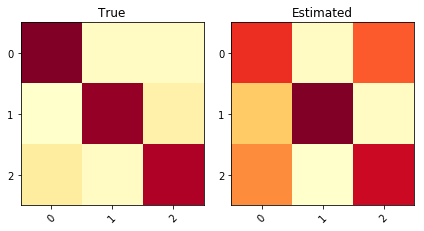

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


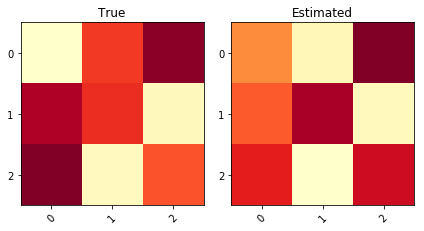

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


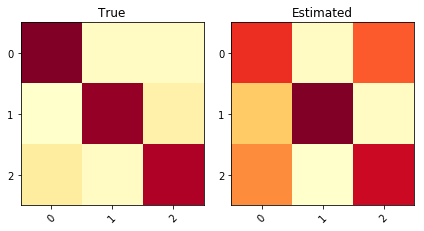

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


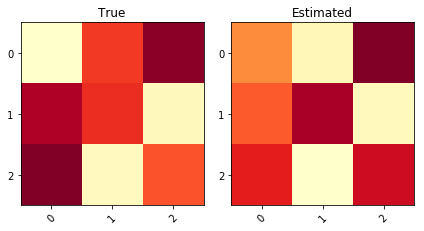

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


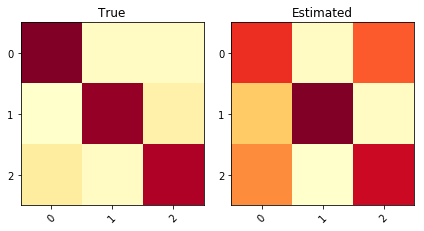

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637
Result:     Group  Accuracy  F1 score (micro)
0      0  0.655926          0.632396
1      1  0.866667          0.866246
Result:             Accuracy  F1 score (micro)  Average KL  Average PearsonCorr  \
0  Global  0.815926          0.813881    0.299623              0.45095   

   Average RMSE  
0      0.133191  


In [305]:
#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
#argmax groups
y_o_groups = predictions_m.argmax(axis=-1)

results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [322]:
#train bulk annotations without GT
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

A result
  +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                      0.56207 |                         -0.935785 |
+----+------------------------------+-----------------------------------+


There are 2 real and 2 predicted Conf matrices


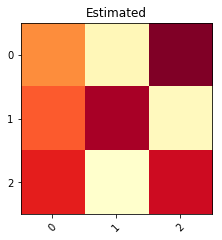

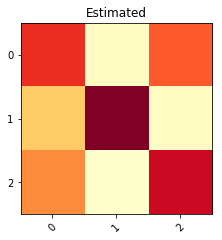

Inertia: 0.006650748726238534
A result
  +----+----------+-----------+------------------+------------------+---------+------------+--------------------+
|    |   Groups |   Entropy |   Diagional Mean |   KL to identity |   Group |   Accuracy |   F1 score (micro) |
|----+----------+-----------+------------------+------------------+---------+------------+--------------------|
|  0 |        0 |  0.786906 |         0.472749 |         0.77975  |       0 |   0.684815 |           0.620032 |
|  1 |        1 |  0.741721 |         0.622322 |         0.484472 |       1 |   0.974444 |           0.974425 |
+----+----------+-----------+------------------+------------------+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+
|    |        |   Accuracy |   F1 score (micro) |
|----+--------+------------+--------------------|
|  0 | Global |   0.951111 |           0.951039 |
+----+--------+------------+--------------------+


In [323]:
#test or train without bulks annotation?--as repeats--- no annotations but ground truth
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
y_o_groups = gMixture.get_predictions_groups(Xstd_test) #obtain p(y^o|x,g=m)
#argmax groups
y_o_groups = y_o_groups.argmax(axis=-1)

results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

There are 2 real and 2 predicted Conf matrices


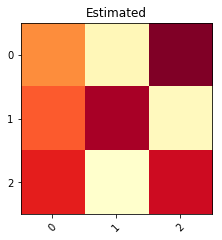

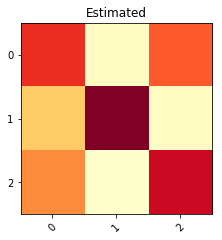

Inertia: 0.006650748726238534
Result:     Groups   Entropy  Diagional Mean  KL to identity
0       0  0.786906        0.472749        0.779750
1       1  0.741721        0.622322        0.484472


In [308]:
#test without GT
results = evaluate.calculate_metrics(conf_pred=c_M)

In [36]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=5)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (50000, 10)
Betas:  (3, 10, 10)
Q estimate:  (50000, 10, 3, 10)
Iter 1/50
M step: done	E step: done, (in 72.82 sec)	logL: -2715965.263	F1: 0.6261
Iter 2/50
M step:

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 done	E step: done, (in 70.89 sec)	logL: -2679319.023	Tol: 0.01349	F1: 0.6246
Iter 3/50
M step: done	E step: done, (in 71.24 sec)	logL: -2637561.656	Tol: 0.01559	F1: 0.6541
Iter 4/50
M step: done	E step: done, (in 73.48 sec)	logL: -2620187.453	Tol: 0.00659	F1: 0.6679
Iter 5/50
M step: done	E step: done, (in 72.33 sec)	logL: -2608219.150	Tol: 0.00457	F1: 0.6693
Iter 6/50
M step: done	E step: done, (in 71.42 sec)	logL: -2592777.869	Tol: 0.00592	F1: 0.6812
Iter 7/50
M step: done	E step: done, (in 71.17 sec)	logL: -2581476.336	Tol: 0.00436	F1: 0.6877
Iter 8/50
M step: done	E step: done, (in 71.09 sec)	logL: -2576276.410	Tol: 0.00201	F1: 0.6841
Iter 9/50
M step: done	E step: done, (in 72.50 sec)	logL: -2566063.387	Tol: 0.00396	F1: 0.6931
Iter 10/50
M step: done	E step: done, (in 70.87 sec)	logL: -2562741.495	Tol: 0.00129	F1: 0.6959
Iter 11/50
M step: done	E step: done, (in 70.85 sec)	logL: -2559842.885	Tol: 0.00113	F1: 0.6933
Iter 12/50
M step: done	E step: done, (in 71.25 sec)	logL: -25533

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


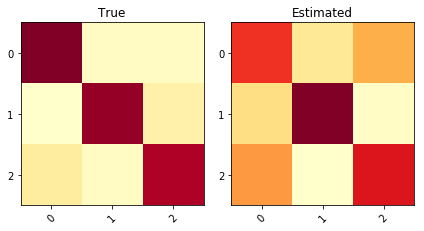

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


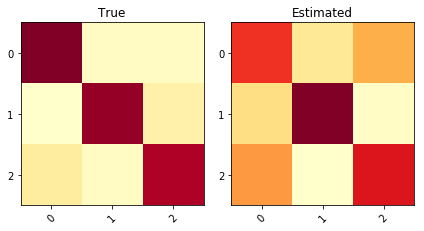

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


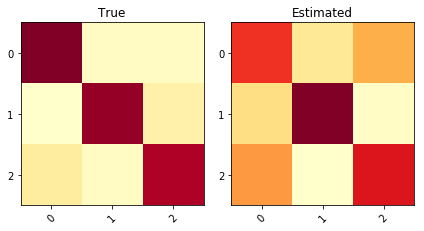

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


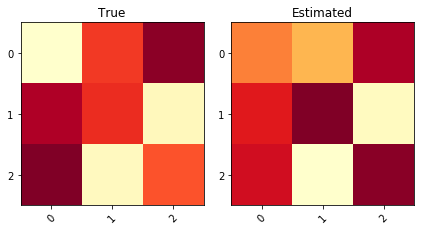

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


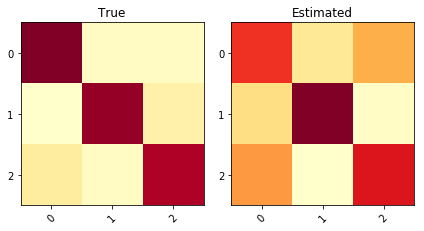

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


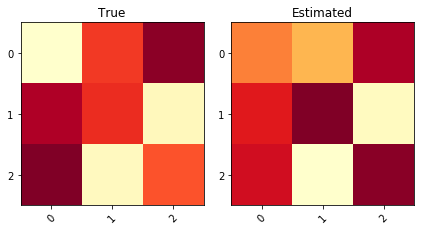

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


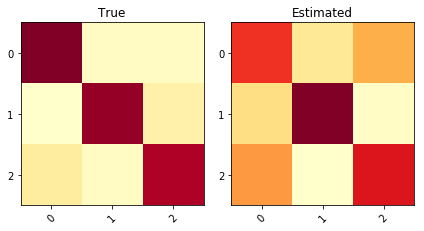

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


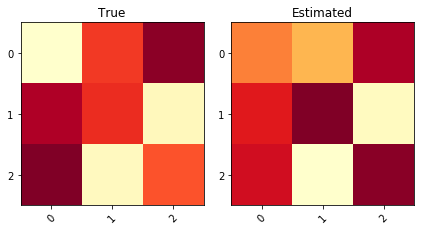

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


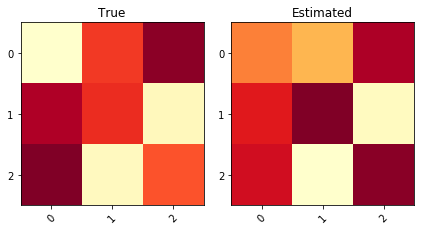

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


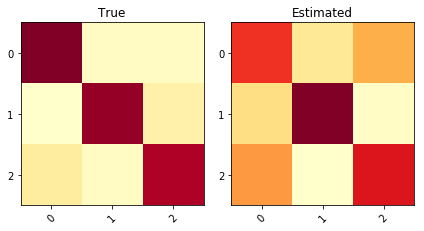

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


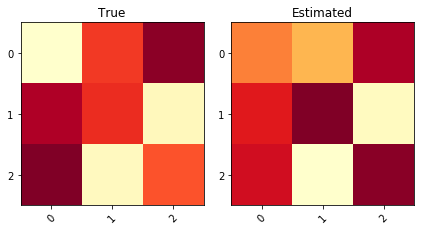

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


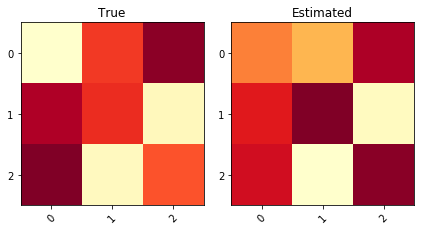

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


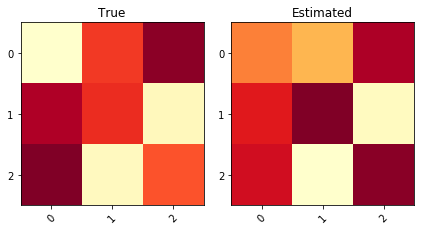

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


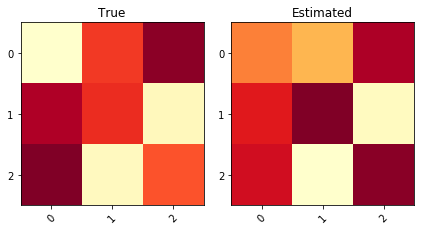

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


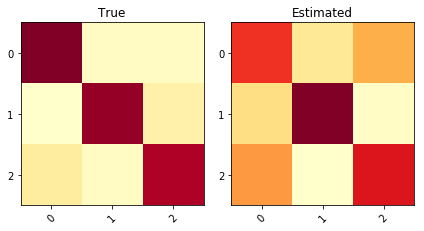

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


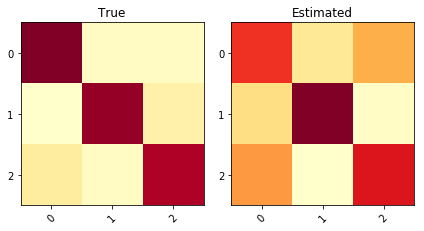

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


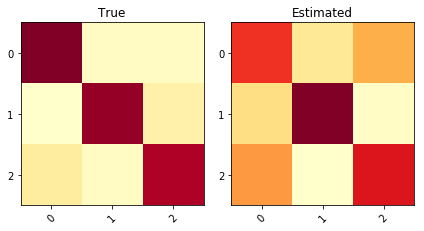

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


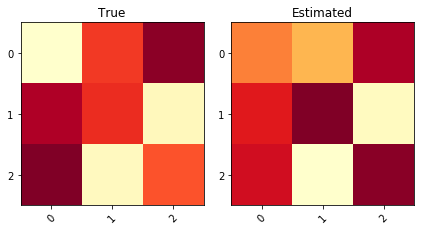

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


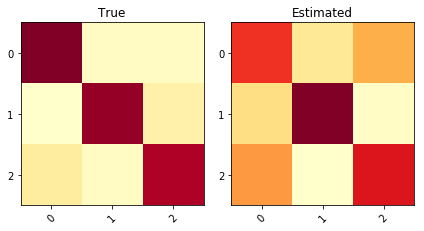

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


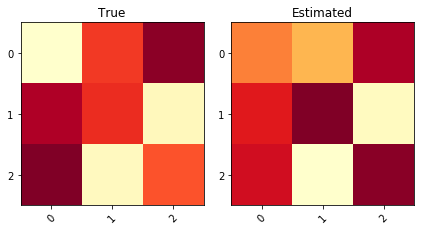

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


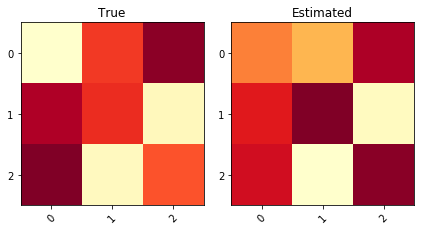

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


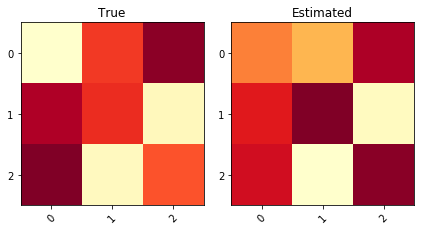

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


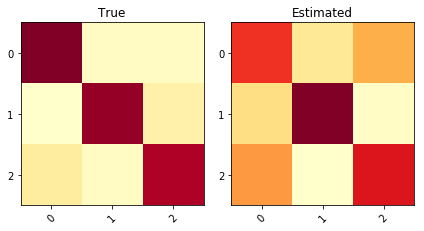

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


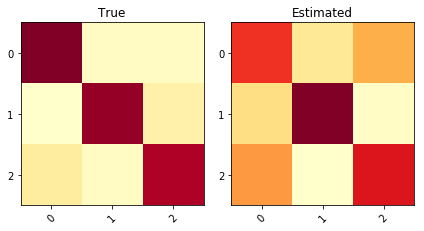

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


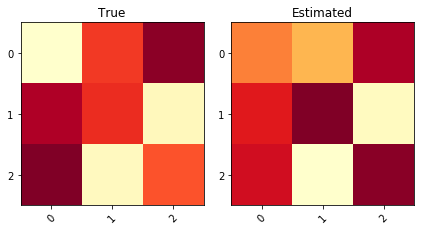

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


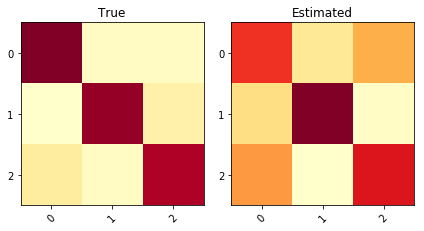

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


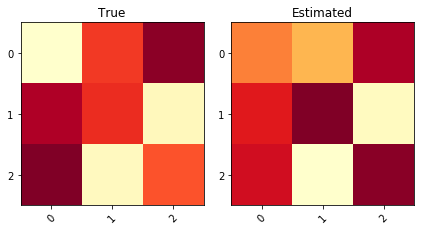

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


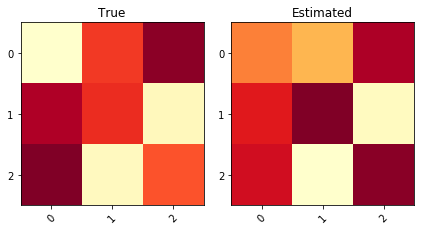

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


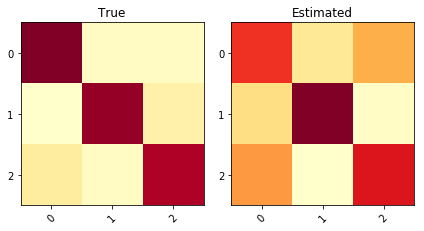

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


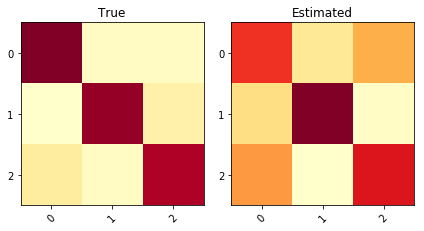

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


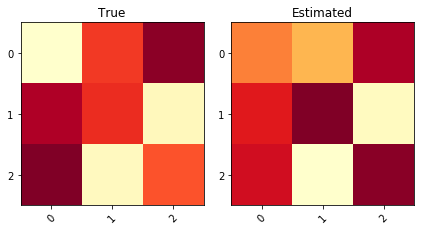

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


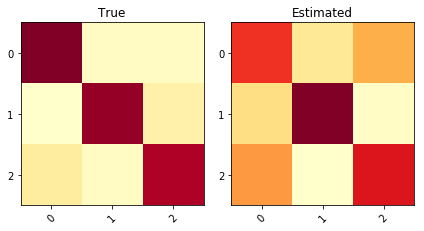

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


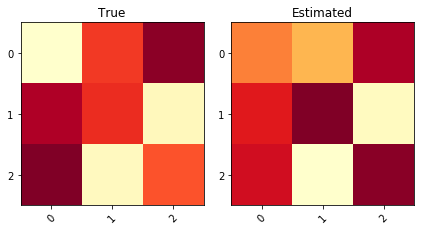

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


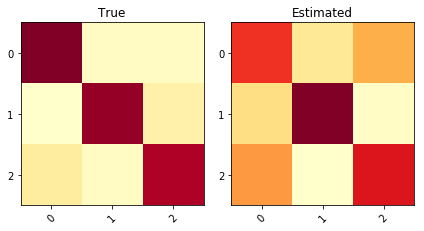

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


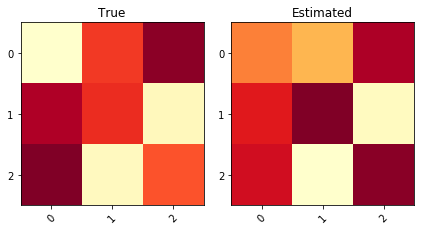

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


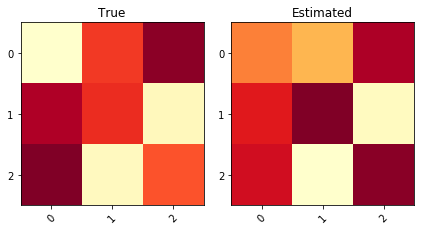

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


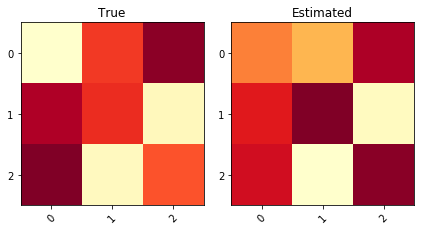

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


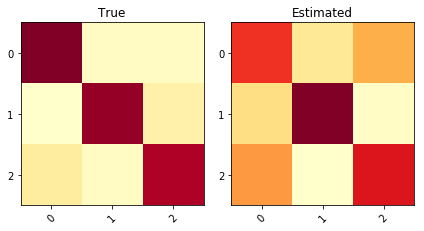

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


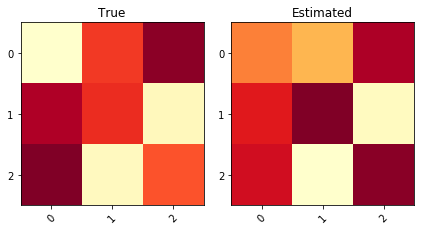

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


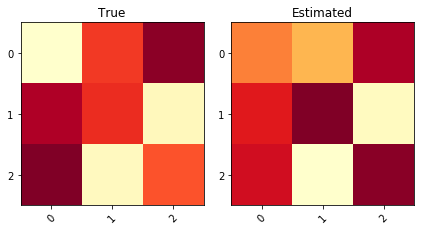

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


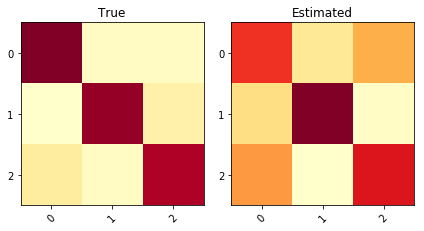

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


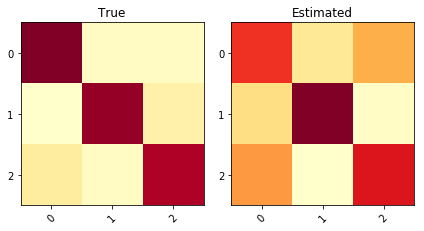

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


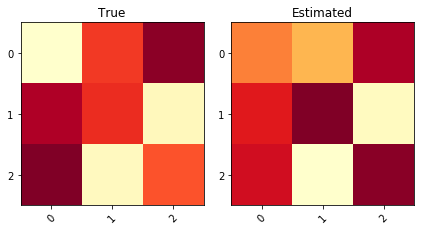

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


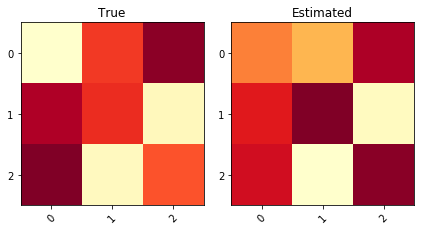

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


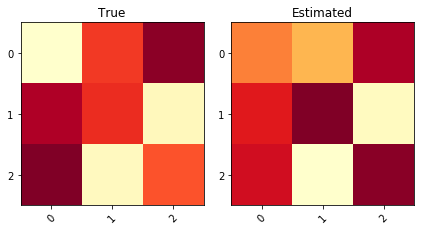

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


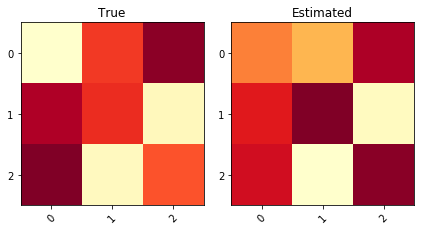

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


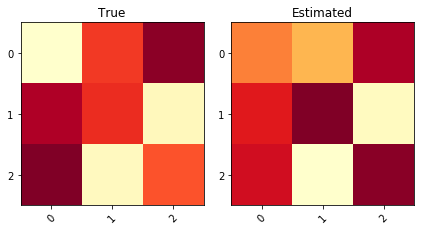

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


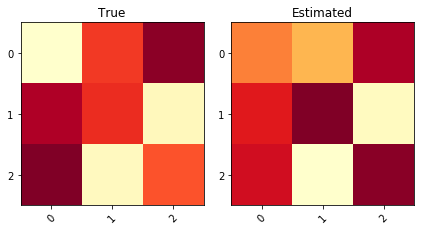

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


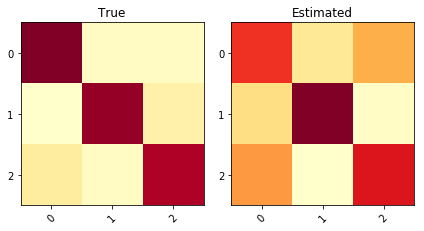

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


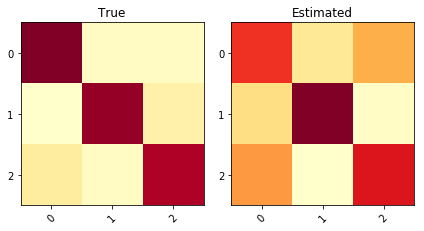

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


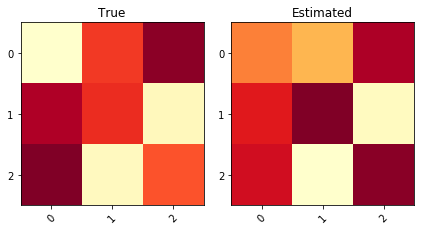

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


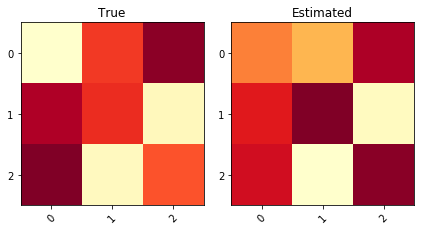

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


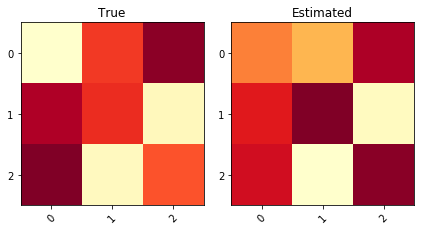

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


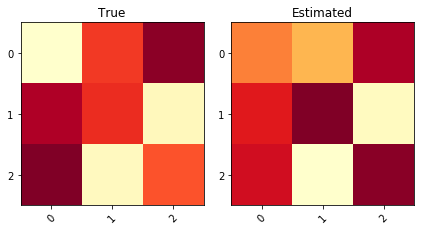

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


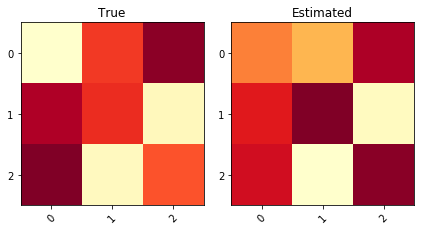

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


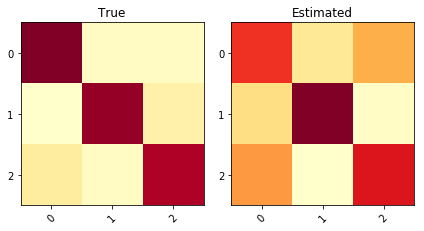

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


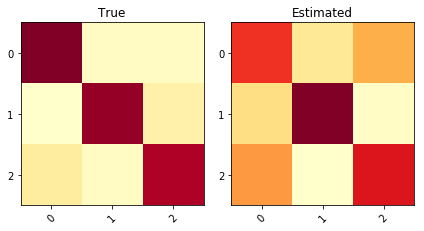

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


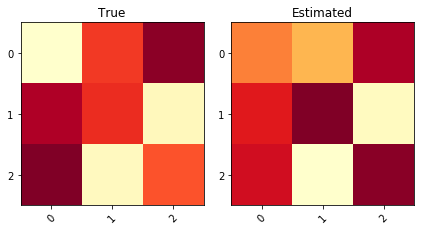

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


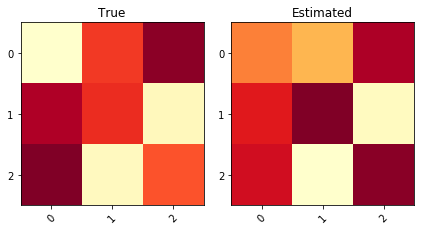

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


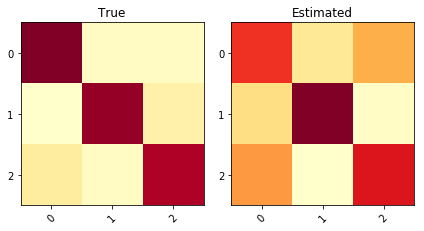

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


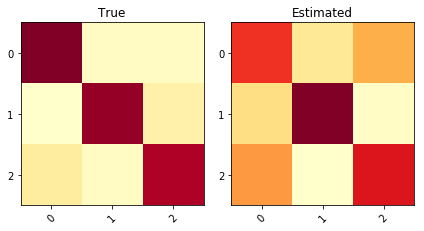

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


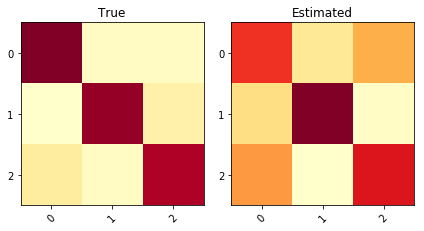

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


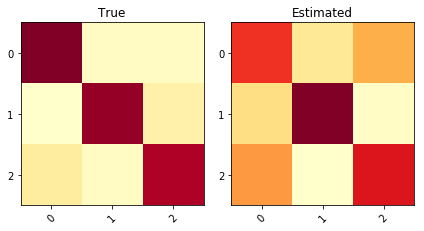

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


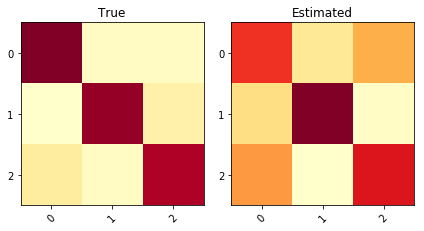

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


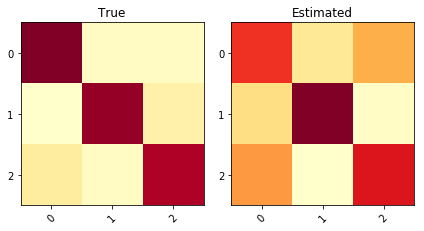

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


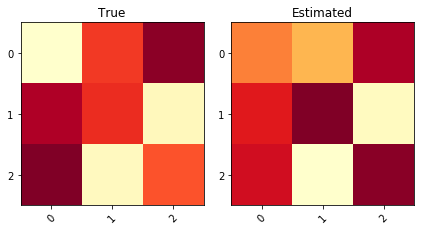

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


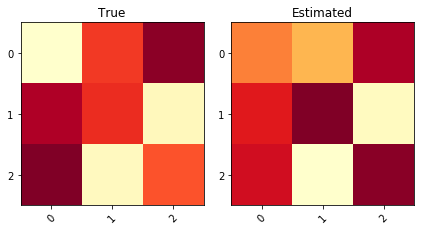

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


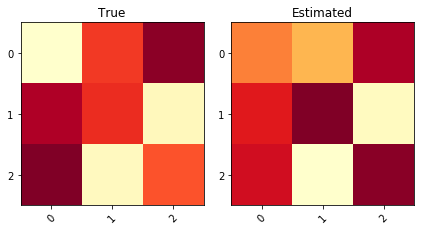

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


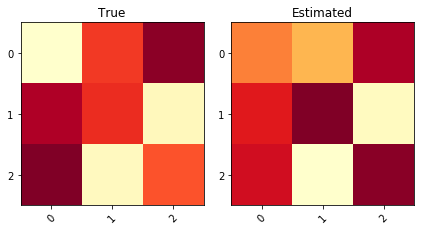

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


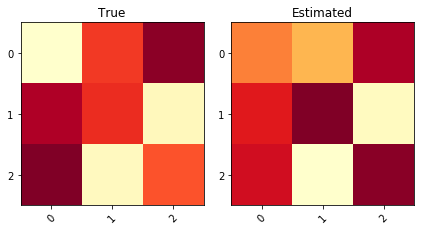

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


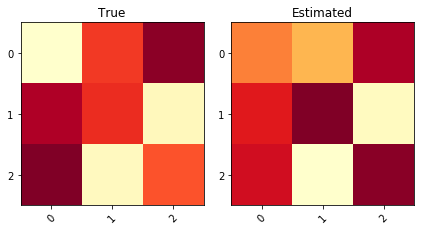

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


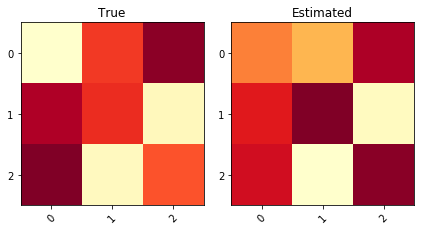

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


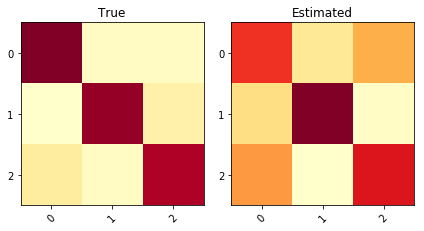

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


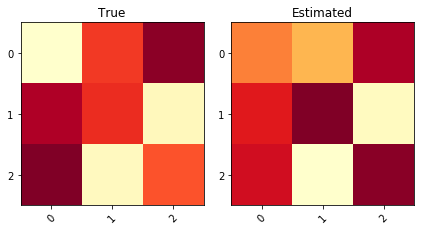

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


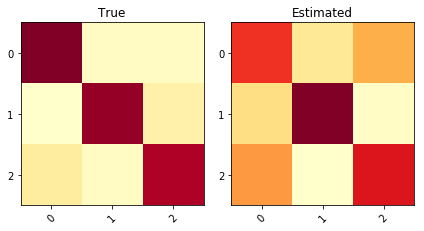

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


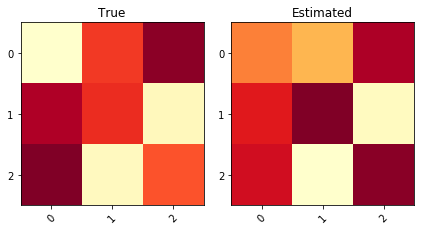

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


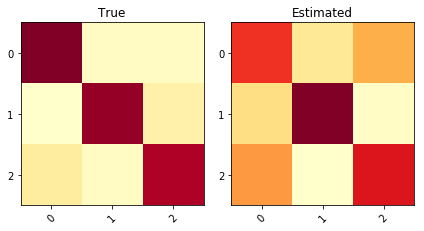

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


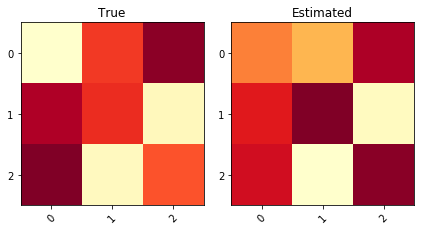

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


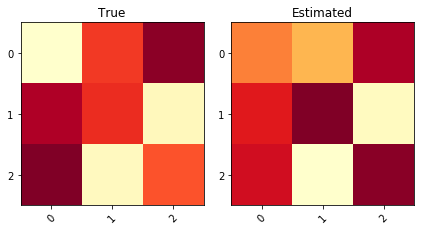

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


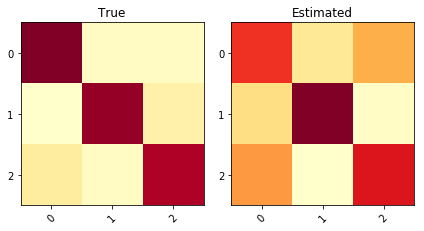

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


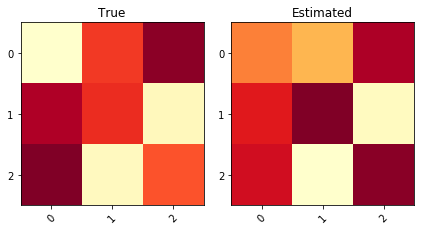

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


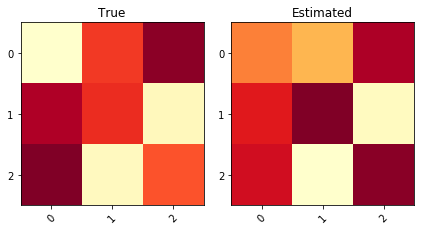

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


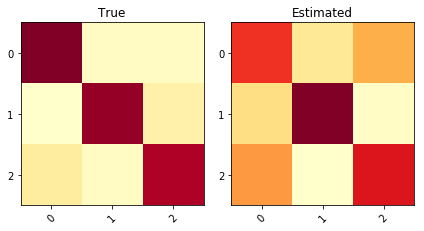

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


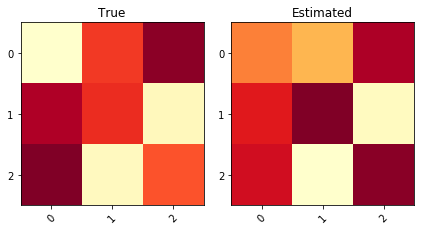

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


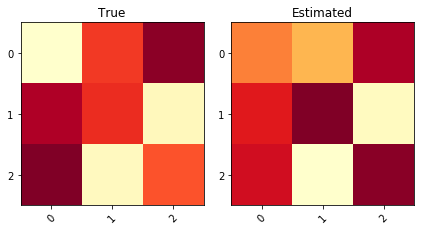

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


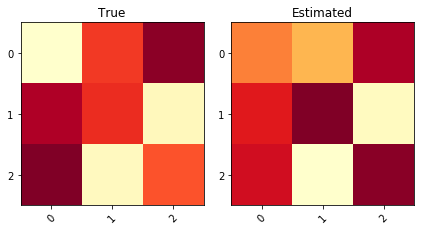

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


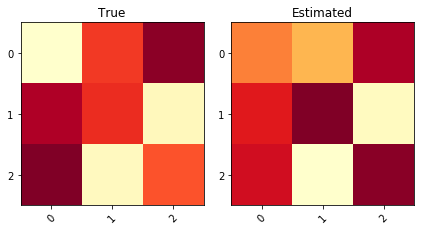

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


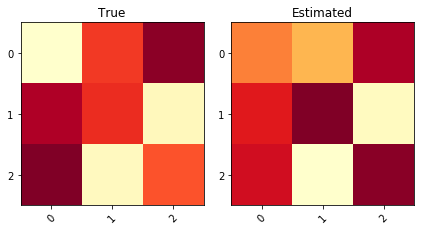

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


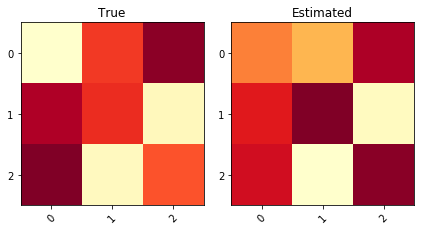

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


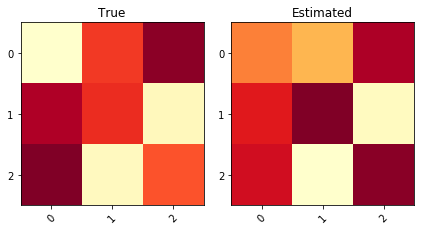

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


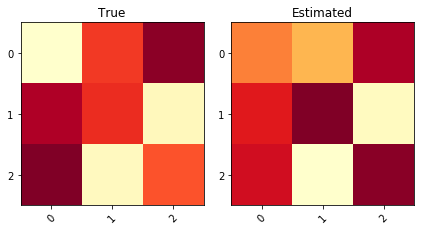

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


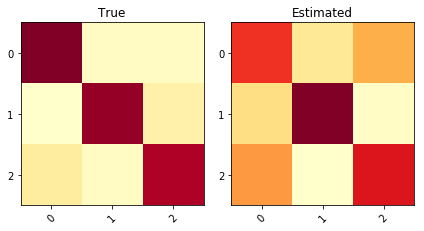

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


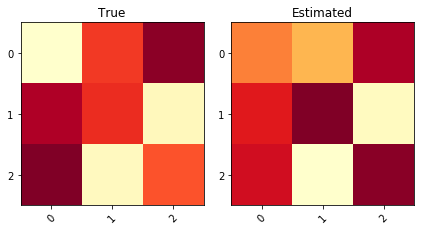

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


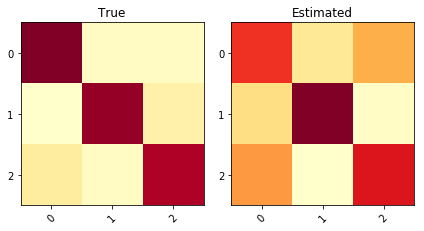

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


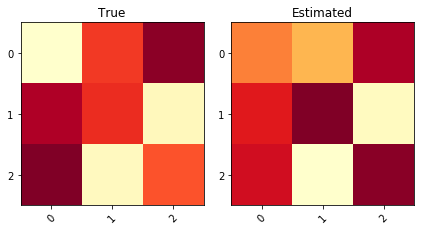

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


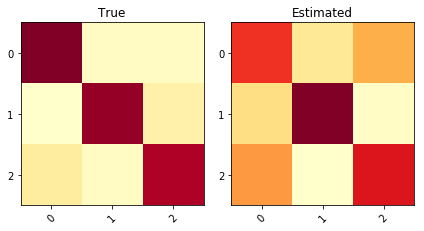

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


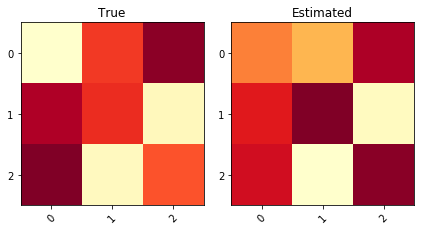

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


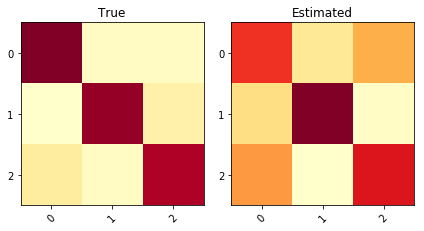

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.894444 |           0.894314 |
|  1 |       1 |   0.600741 |           0.538118 |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.891481 |           0.892084 |     0.185925 |              0.521372 |       0.143939 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.3 s, sys: 517 ms, total: 31.8 s
Wall time: 31.3 s


In [80]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


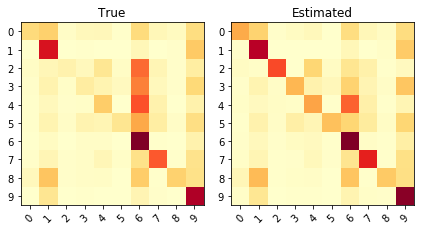

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


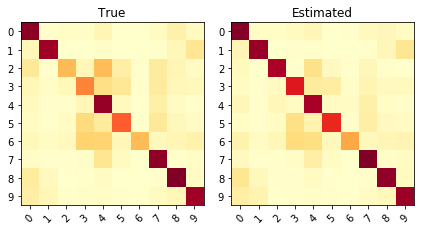

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1114	Pearson Correlation between diagonals: 0.4132


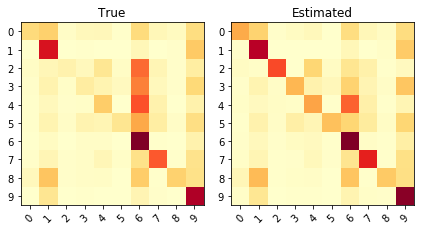

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


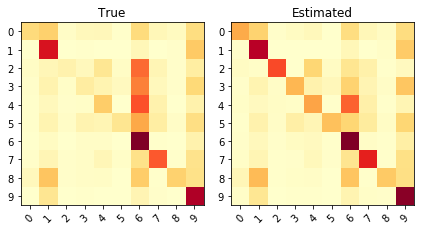

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


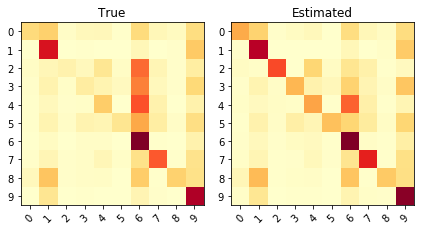

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


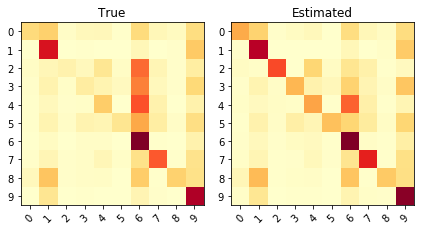

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


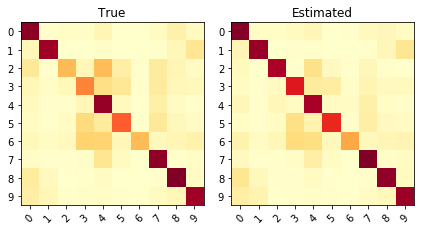

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


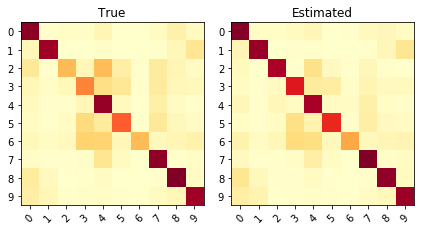

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


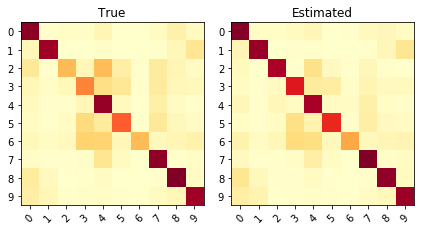

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


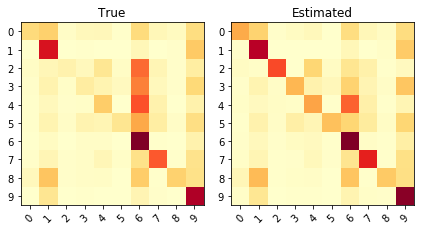

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


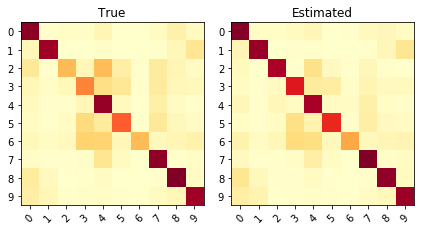

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


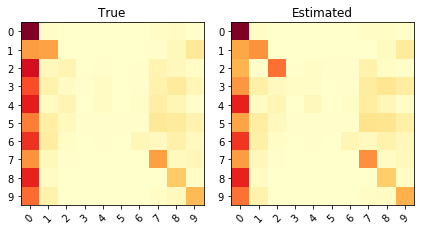

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation betwee

In [37]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [31]:
gMixture = GroupMixtureOpt(X_train.shape[1:],Kl=r_obs.shape[1],M=4,epochs=1,optimizer=OPT,pre_init=8)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
#gMixture.define_model("simple cnn",start_units=32,deep=3,BatchN=True,drop=0.25)
logL_hist = gMixture.multiples_run(10,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca]) #more runs

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 8 epochs... Done!
Lambda by group:  [0.1378987600466675, 0.24523473249025382, 0.8920139342354865, 0.12216360576995895]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done	E step: done, (in 19.07 sec)	logL: -2638904.850	
Iter 2/50
M step: done	E step: done, (in 19.08 sec)	logL: -2610500.685	Tol: 0.01076	
Iter 3/50
M step: done	E step: done, (in 19.63 sec)	logL: -2591147.926	Tol: 0.00741	
Iter 4/50
M step: done	E step: done, (in 19.23 sec)	logL: -2583362.544	Tol: 0.00300	
Iter 5/50
M step: done	E step: done, (in 18.98 sec)	logL: -2565883.684	Tol: 0.00677	
Iter 6/50
M step: done	E step: done, (in 19.05 sec)	logL: -2578962.508	Tol: 0.00510	
Iter 7/50
M step: done	E step: done, (in 18.66 sec)	logL: -2561385.656	Tol: 0.00682	
Iter 8/50
M step: done	E step: done, (in 18.67 sec)	logL: -2549138.193	Tol: 0.00478	
Iter 9/50
M step: done	E step: done, (in 18.30 sec)	l

In [32]:
for value in logL_hist:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()
#plt.plot(logL_hist)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


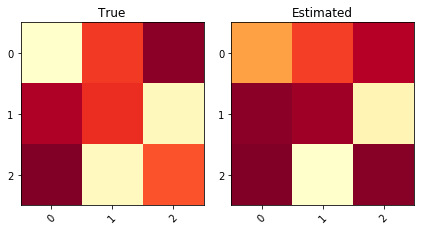

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


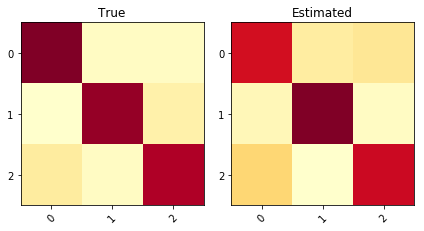

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


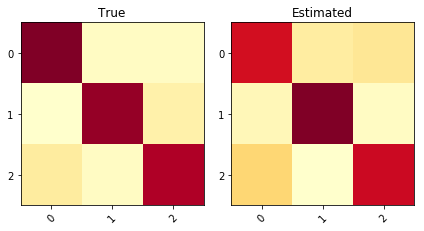

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


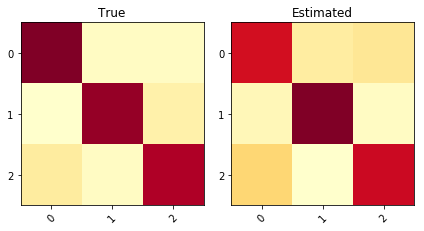

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


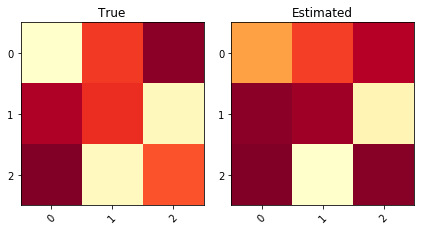

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


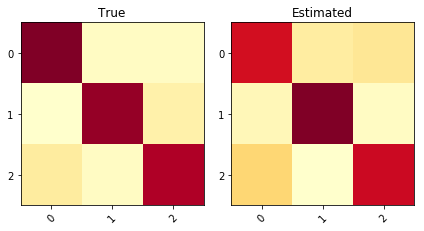

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


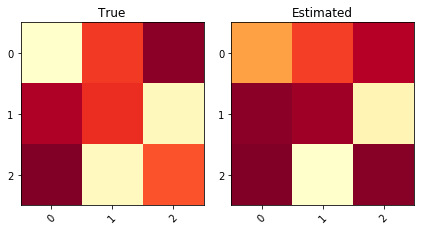

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


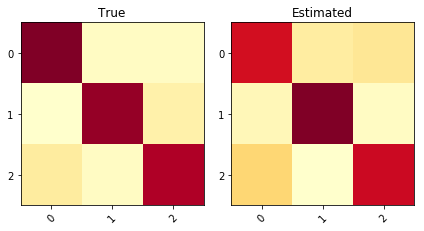

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


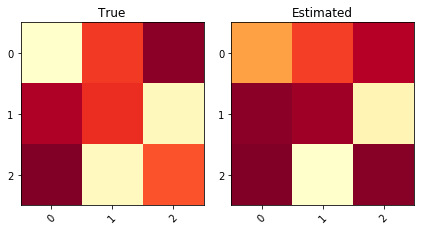

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


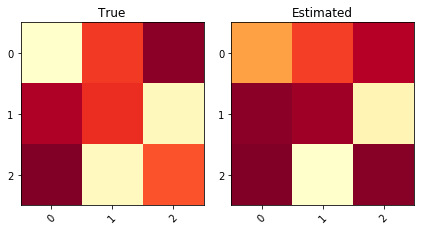

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


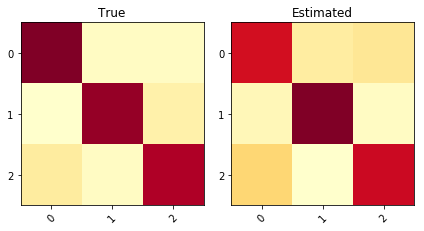

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


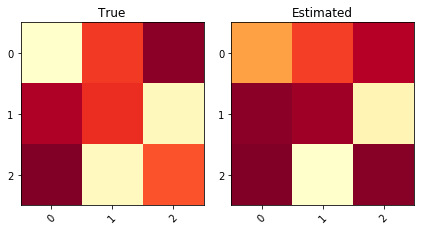

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


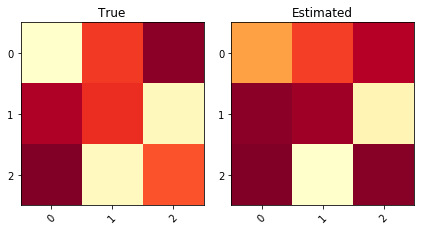

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


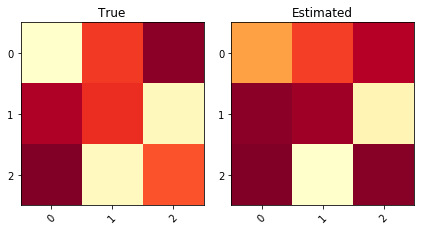

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


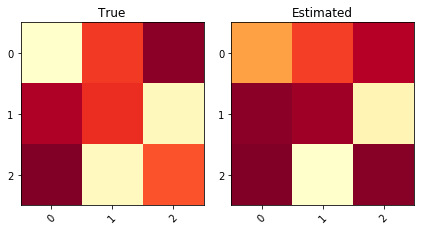

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


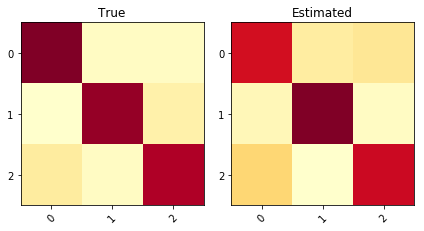

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


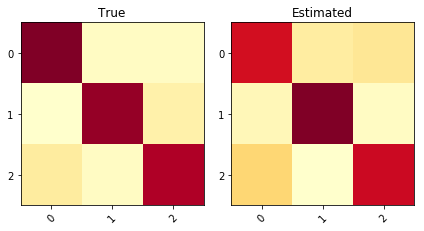

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


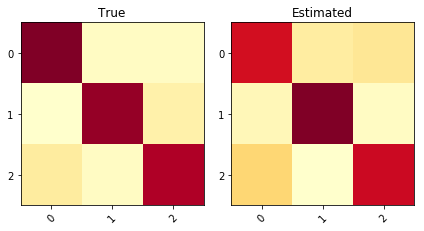

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


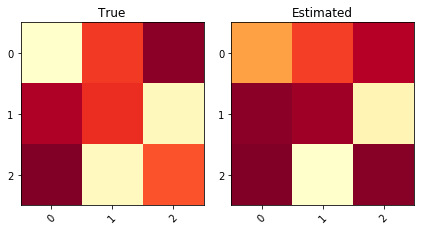

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


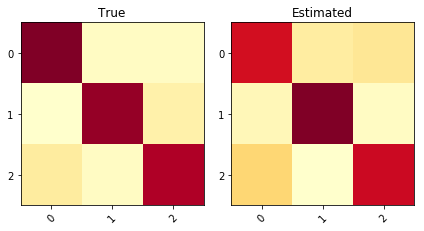

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


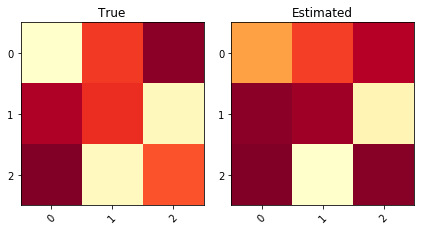

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


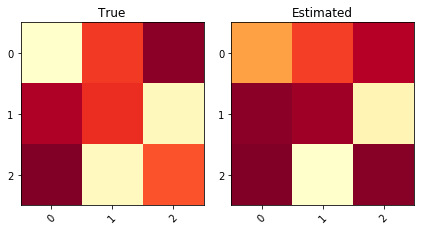

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


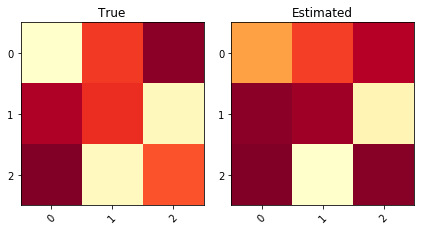

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


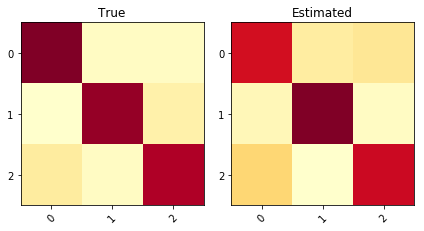

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


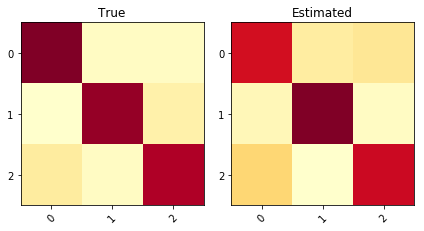

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


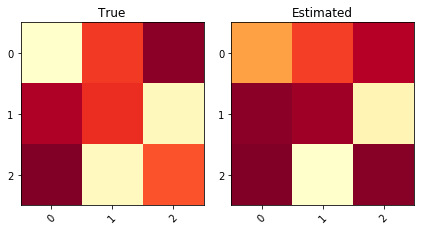

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


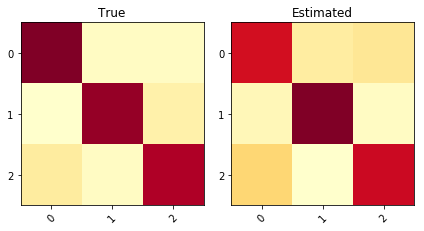

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


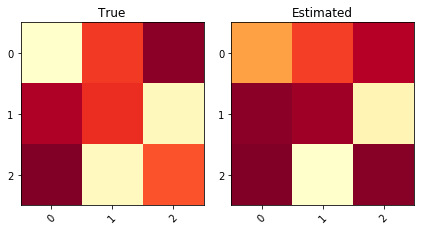

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


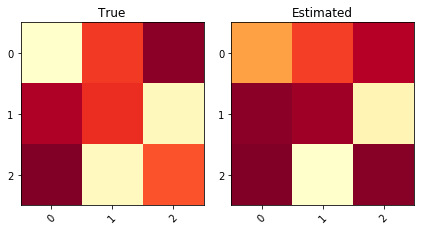

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


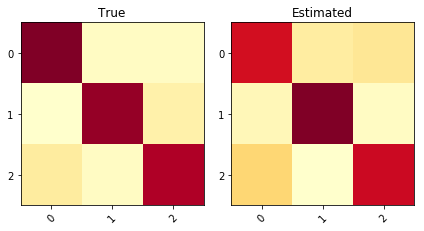

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


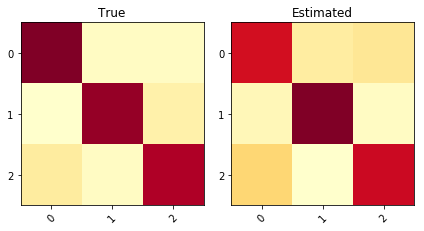

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


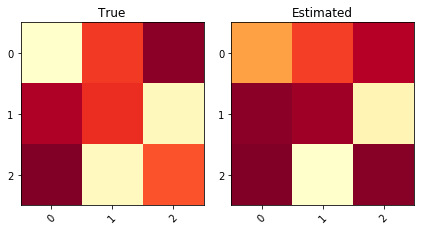

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


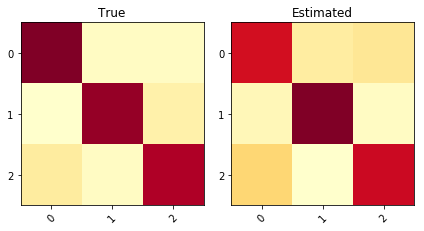

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


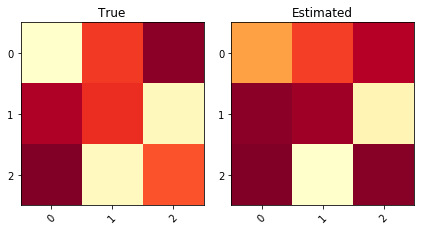

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


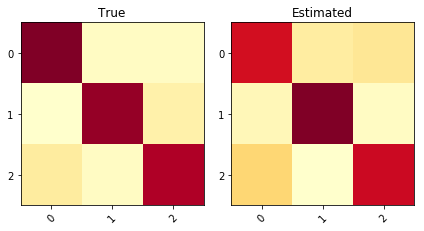

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


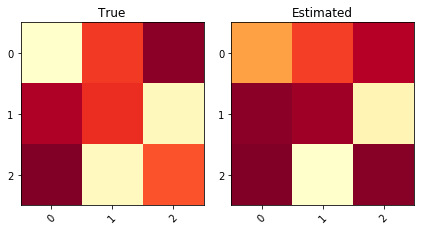

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


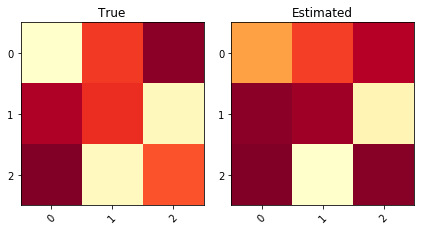

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


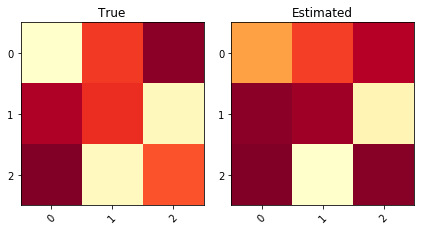

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


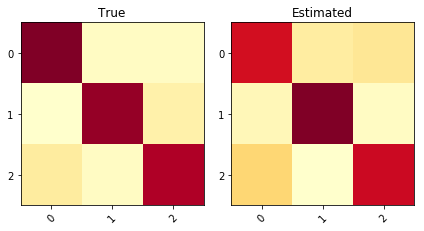

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


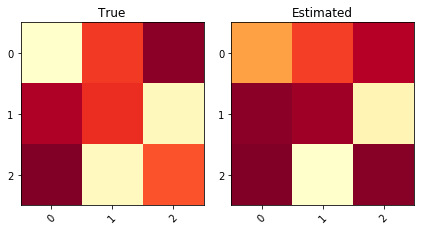

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


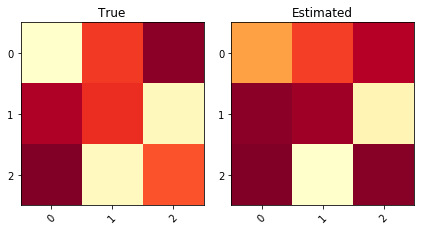

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


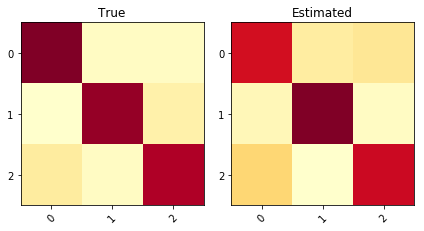

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


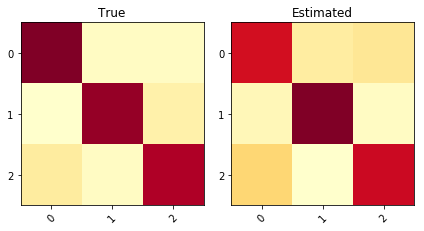

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


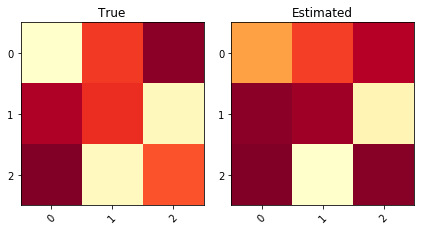

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


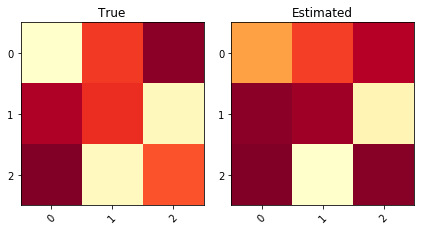

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


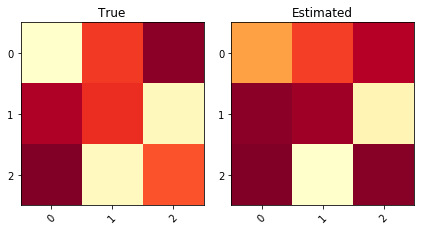

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


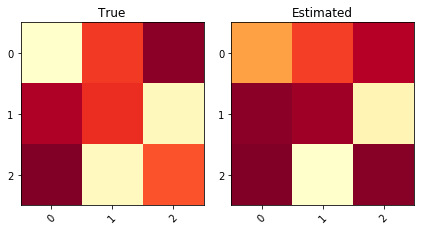

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


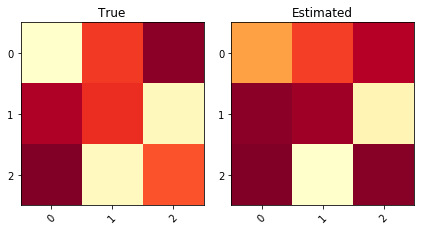

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


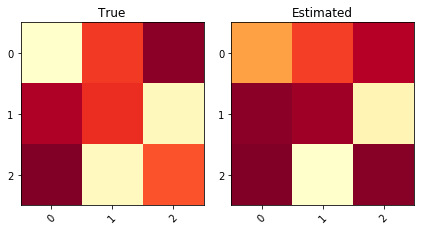

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


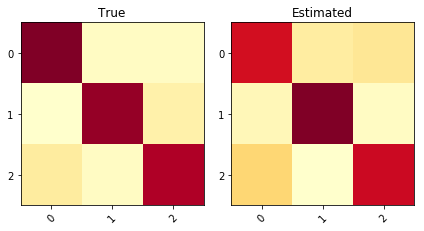

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


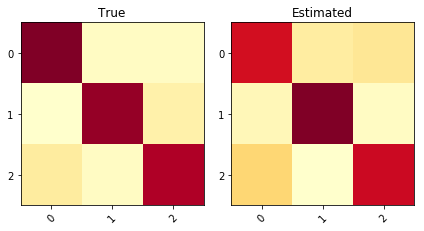

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


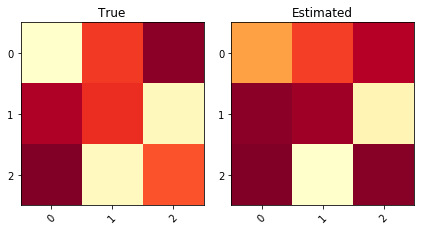

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


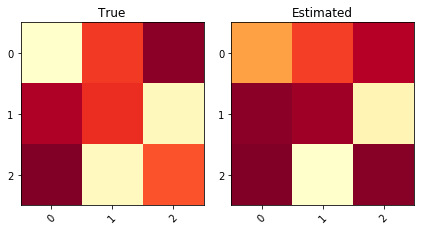

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


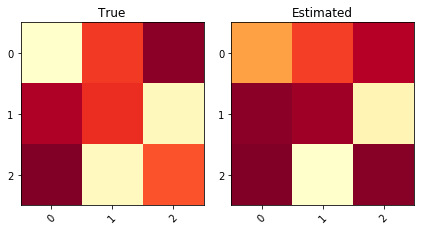

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


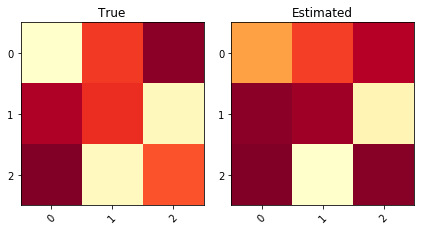

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


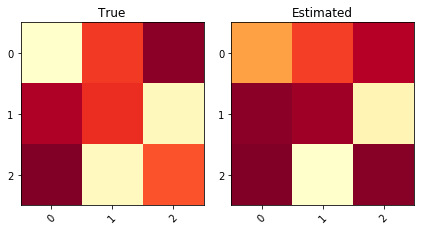

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


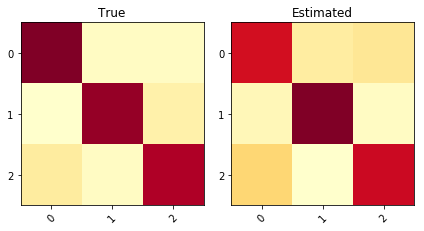

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


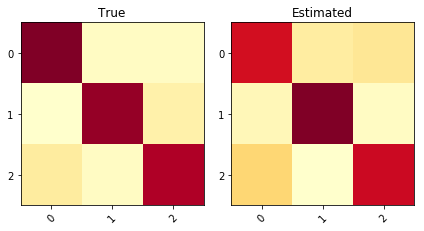

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


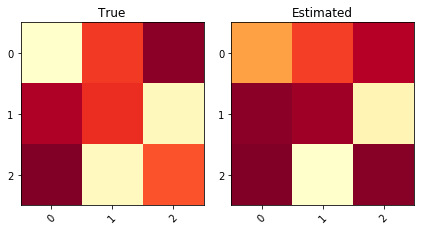

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


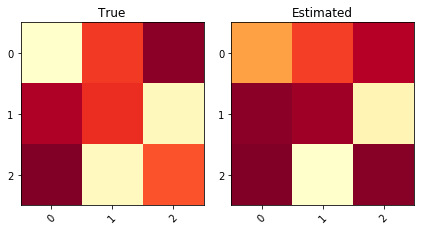

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


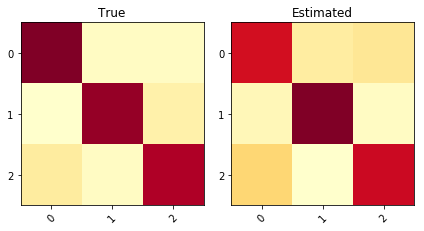

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


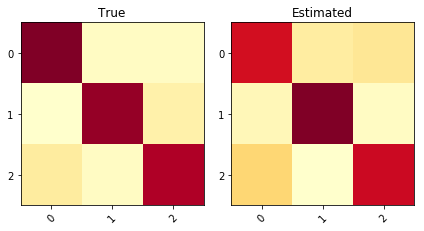

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


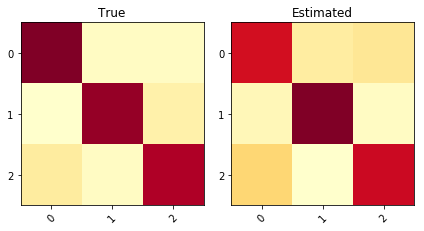

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


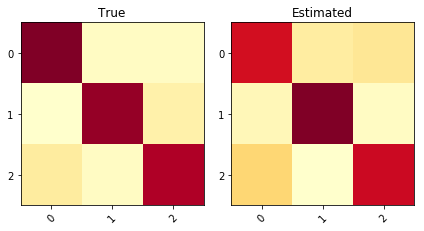

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


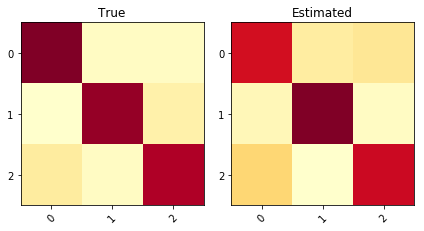

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


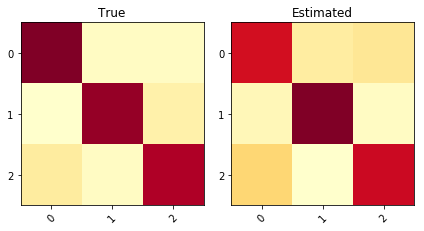

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


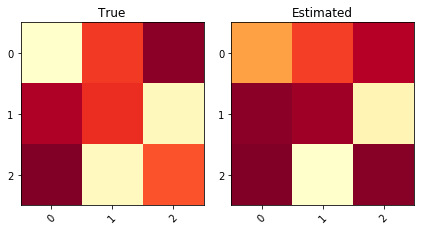

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


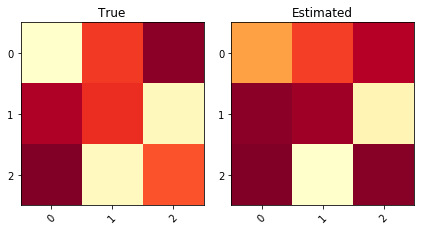

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


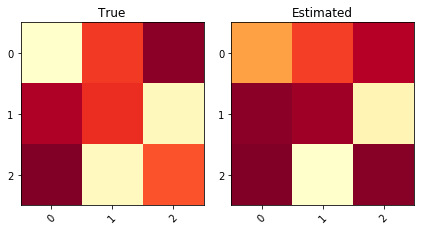

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


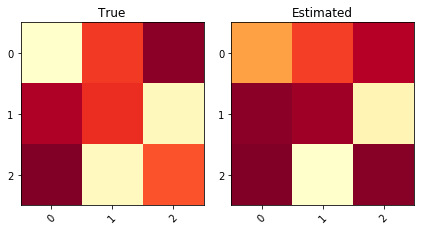

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


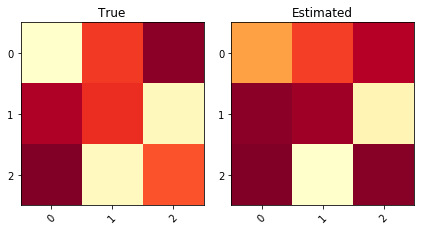

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


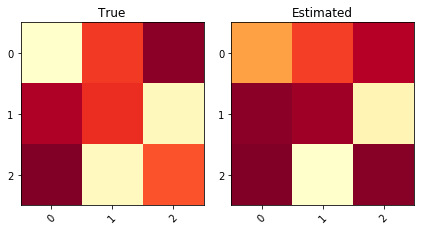

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


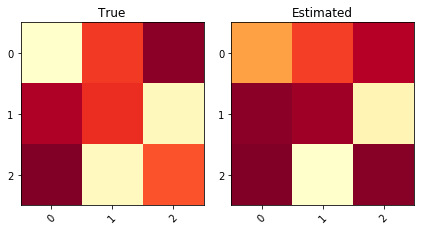

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


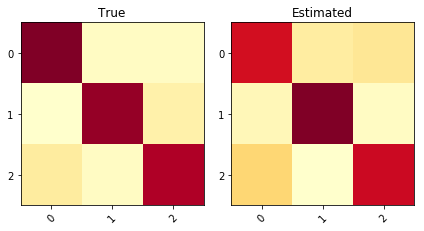

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


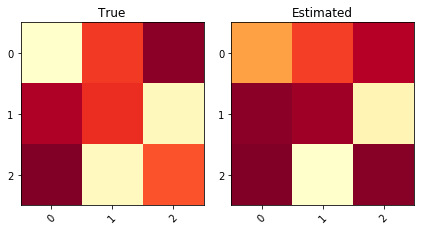

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


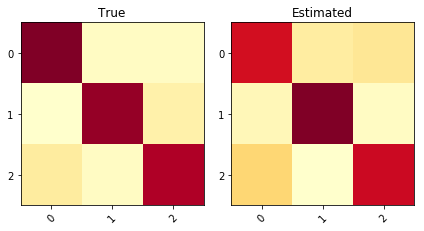

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


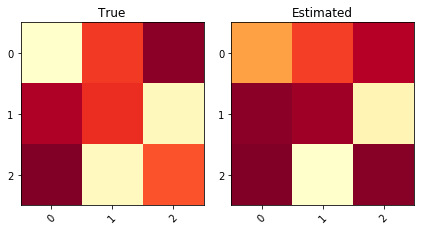

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


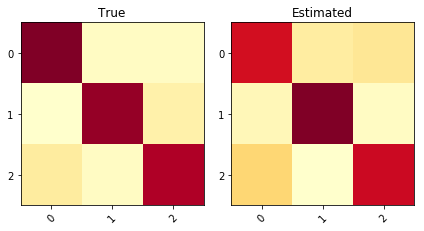

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


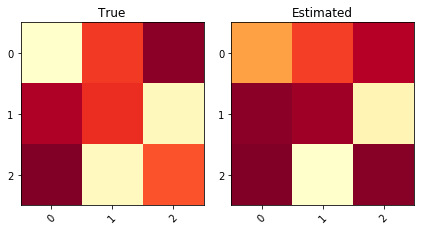

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


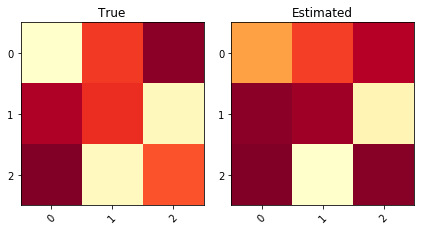

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


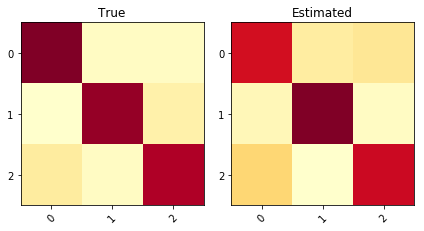

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


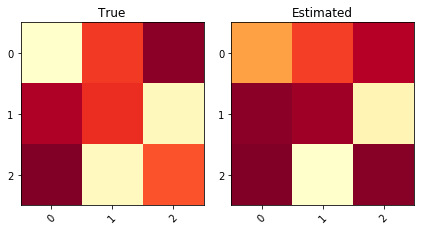

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


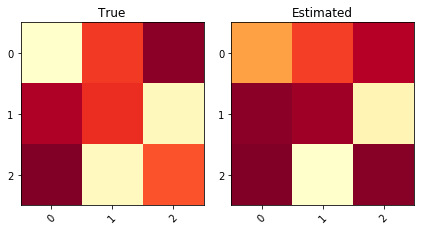

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


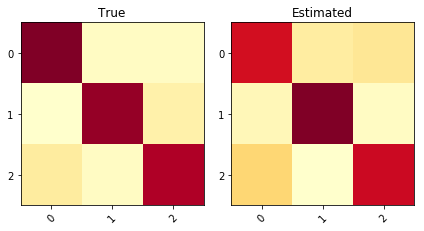

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


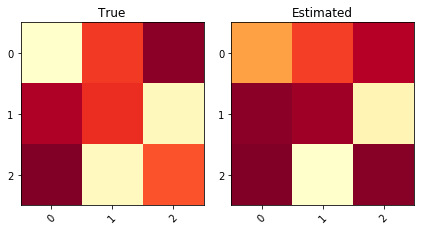

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


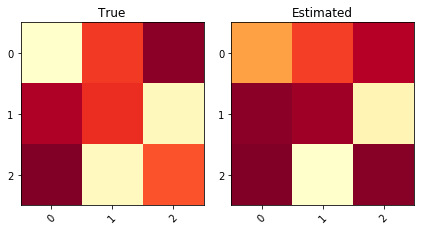

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


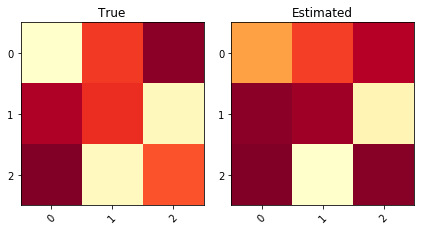

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


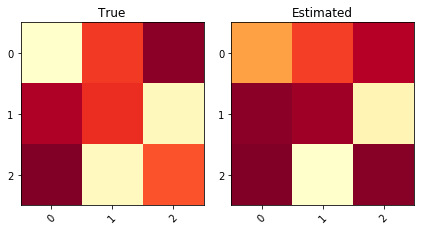

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


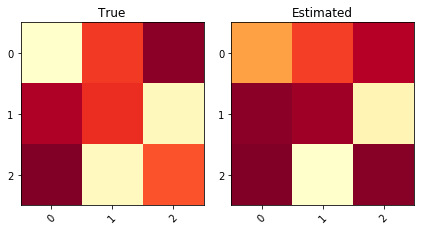

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


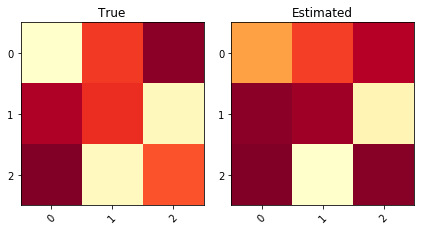

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


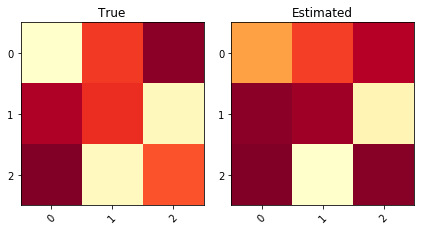

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


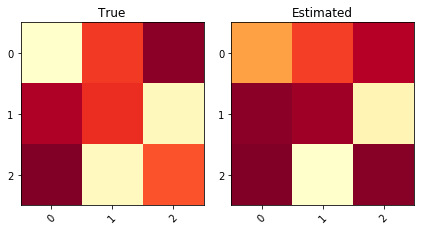

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


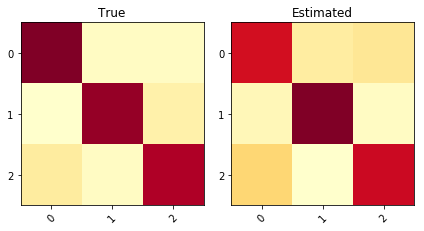

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


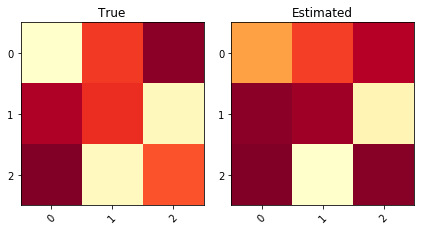

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


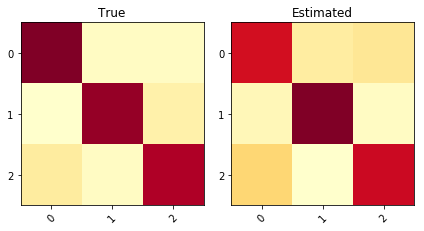

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


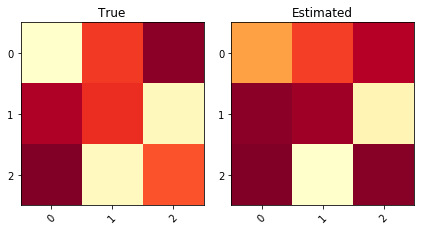

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


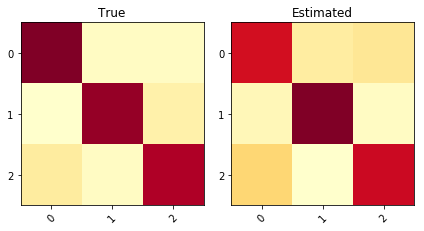

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


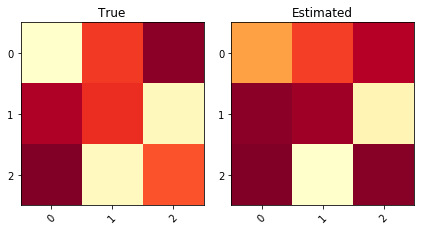

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


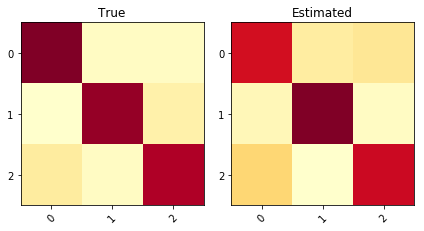

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.29963  |           0.220811 |
|  1 |       1 |   0.897037 |           0.89708  |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.894444 |           0.894994 |     0.094598 |              0.565182 |        0.16847 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.4 s, sys: 555 ms, total: 31.9 s
Wall time: 31.4 s


In [74]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

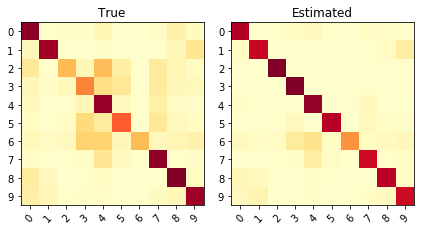

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


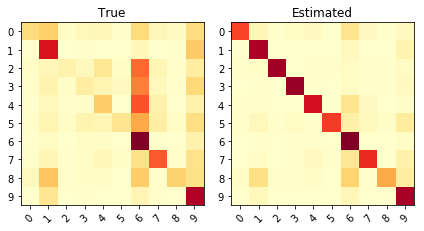

KL divergence: 0.6230	Pearson Correlation between diagonals: 0.3983


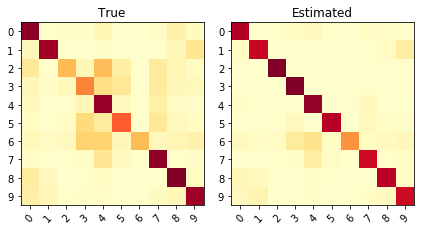

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


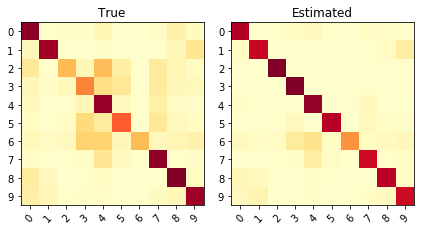

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


KL divergence: 0.6187	Pearson Correlation between diagonals: 0.4000


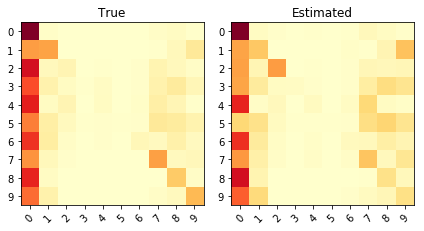

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


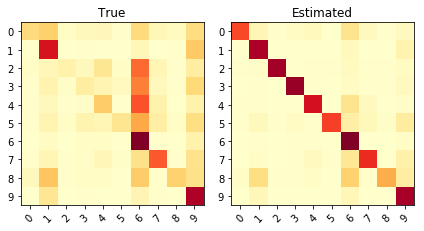

KL divergence: 0.6106	Pearson Correlation between diagonals: 0.4034


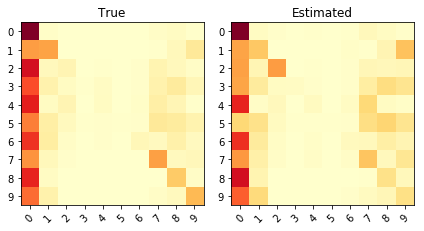

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


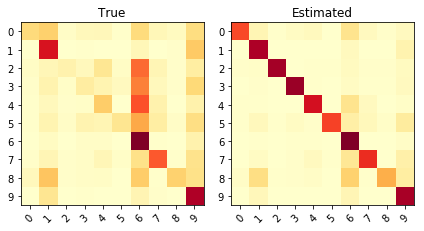

KL divergence: 0.6022	Pearson Correlation between diagonals: 0.4069


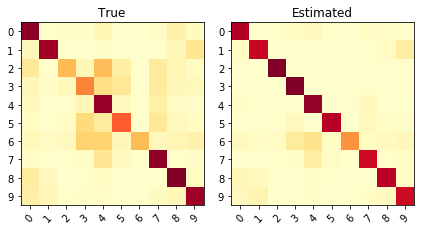

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


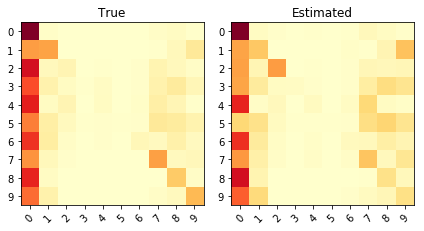

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


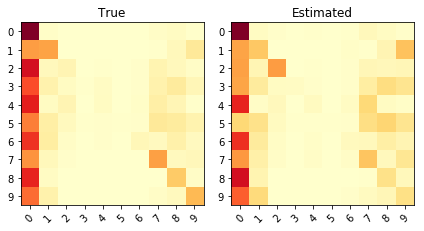

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


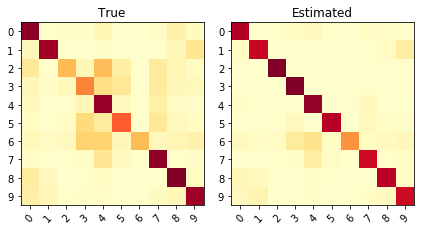

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


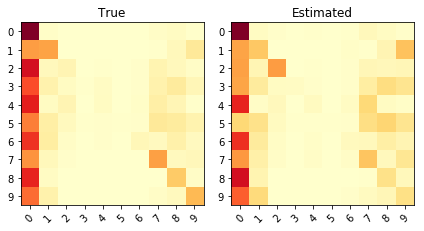

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


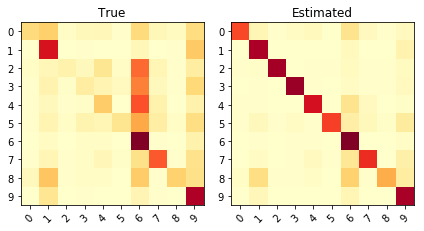

KL divergence: 0.6063	Pearson Correlation between diagonals: 0.4052
A result
 +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |    0.63382 |            0.63382 |
|  1 |       1 |    0.8407  |            0.8407  |
|  2 |       2 |    0.1     |            0.1     |
|  3 |       3 |    0.65312 |            0.65312 |
+----+---------+------------+--------------------+
A result
 +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |    0.75984 |            0.75984 |     0.429922 |              0.428081 |       0.143167 |
+----+--------+------------+--------------------+--------------+----------------

In [34]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

### $\lambda$ random on clean data 2

In [227]:
#1,2,9,14,15,18 ----5,8,16(aprox), 19 very aprox
#revisar log loss..
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #best is lambda close to 1

Indices:  [19  8  1 15 14 18 16  4  0  9 10  2  7 13 12  6  3 17  5 11]
F1 scores:  0.9567233308497585
F1 scores:  0.9722991947952253
F1 scores:  0.9730373373417617
F1 scores:  0.9708188472037063
F1 scores:  0.956016774823882


array([[[0.52382575, 0.21659293, 0.25958132],
        [0.11623011, 0.83725768, 0.04651221],
        [0.44169099, 0.00159129, 0.55671772]],

       [[0.21783677, 0.41721678, 0.36494644],
        [0.4749662 , 0.49408818, 0.03094562],
        [0.4142501 , 0.00183745, 0.58391245]]])

In [231]:
for ind in indexs_sort[:5]:
    print("LogLoss %f "%logL_iter[ind] )

LogLoss -74753.037878 
LogLoss -74846.558465 
LogLoss -74848.771741 
LogLoss -74881.145240 
LogLoss -75019.563584 


### $\lambda$ =1 on clean data 2

In [232]:
# 0 y 1 interesantes--3 aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [3 0 1 2 4]
F1 scores: 0.955606 y LogLoss -74719.447607 
F1 scores: 0.968179 y LogLoss -74883.187174 
F1 scores: 0.960457 y LogLoss -74920.960253 
F1 scores: 0.956374 y LogLoss -75083.774056 
F1 scores: 0.351232 y LogLoss -76185.540685 


array([[[0.50777171, 0.22507155, 0.26715675],
        [0.11185078, 0.83924488, 0.04890434],
        [0.4582481 , 0.00159581, 0.54015609]],

       [[0.22760429, 0.41990971, 0.352486  ],
        [0.47839272, 0.49042606, 0.03118121],
        [0.40264624, 0.00196233, 0.59539143]]])

In [239]:
#con alfa data dependent --> 3,2 y 0 muy buenos
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.458558 y LogLoss -73051.591996 
F1 scores: 0.962240 y LogLoss -73313.658698 
F1 scores: 0.965886 y LogLoss -73497.073680 
F1 scores: 0.974446 y LogLoss -73702.008816 
F1 scores: 0.971485 y LogLoss -73704.003644 


array([[[7.05309888e-01, 6.78381229e-03, 2.87906299e-01],
        [7.35180890e-02, 9.24724807e-01, 1.75710357e-03],
        [5.01078305e-01, 2.81658016e-01, 2.17263679e-01]],

       [[4.66742009e-01, 1.93783100e-04, 5.33064208e-01],
        [6.14267012e-01, 3.16643747e-01, 6.90892417e-02],
        [1.89225399e-01, 1.86074745e-03, 8.08913853e-01]]])

### $\lambda$ random on noise data 2

In [254]:
#9,1,16,4,17 -.- aprox : 15,7,3,8 , 13 very aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda aprox to 1

Indices:  [13  1 15  9 16  2 12  7 18  3  4 17 11 19  6 14  0  5 10  8]
F1 scores: 0.888830 y LogLoss -78001.588032 
F1 scores: 0.892016 y LogLoss -78116.591164 
F1 scores: 0.884132 y LogLoss -78137.777845 
F1 scores: 0.883747 y LogLoss -78254.586413 
F1 scores: 0.883738 y LogLoss -78314.510964 


array([[[0.27134669, 0.35397641, 0.3746769 ],
        [0.44678169, 0.51668657, 0.03653173],
        [0.4222056 , 0.00645561, 0.5713388 ]],

       [[0.50628012, 0.21383676, 0.27988311],
        [0.14782917, 0.80655601, 0.04561483],
        [0.42775275, 0.00488844, 0.56735881]]])

In [255]:
matrices_encontradas[indexs_sort[1]] #-- l_0 == 1 l_1 ==0

array([[[0.08295195, 0.40093714, 0.51611091],
        [0.48669173, 0.45809595, 0.05521232],
        [0.62825357, 0.00538692, 0.36635951]],

       [[0.94113627, 0.02508032, 0.03378341],
        [0.00918393, 0.98703061, 0.00378546],
        [0.0255219 , 0.00113546, 0.97334265]]])

In [258]:
#with data dependent: 14,8,17,18,6,7
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #

Indices:  [10 16  9  1  2 19 15  0 13  5 12  6  3 11  8  7 17 14 18  4]
F1 scores: 0.569450 y LogLoss -72703.277615 
F1 scores: 0.491469 y LogLoss -72720.581623 
F1 scores: 0.508396 y LogLoss -72767.949725 
F1 scores: 0.491615 y LogLoss -72825.122112 
F1 scores: 0.507041 y LogLoss -72896.068329 


array([[[3.79349307e-01, 6.94819793e-04, 6.19955873e-01],
        [7.77944156e-01, 8.23359122e-02, 1.39719932e-01],
        [3.06555768e-01, 2.04645067e-04, 6.93239587e-01]],

       [[4.25210560e-01, 5.09417750e-01, 6.53716909e-02],
        [6.15437909e-02, 9.38092005e-01, 3.64204100e-04],
        [5.08005925e-01, 3.63402917e-01, 1.28591157e-01]]])

### $\lambda$ =1 on noise data 2

In [262]:
#1,3 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [1 3 4 0 2]
F1 scores: 0.891017 y LogLoss -77959.391833 
F1 scores: 0.886087 y LogLoss -78123.030905 
F1 scores: 0.884353 y LogLoss -78170.862790 
F1 scores: 0.882184 y LogLoss -78190.927143 
F1 scores: 0.859548 y LogLoss -78572.408112 


array([[[0.25098253, 0.35037085, 0.39864661],
        [0.44670657, 0.51498243, 0.038311  ],
        [0.4298412 , 0.00810423, 0.56205457]],

       [[0.52964153, 0.20908235, 0.26127612],
        [0.15634487, 0.79921221, 0.04444291],
        [0.41637648, 0.00626742, 0.57735611]]])

### $\lambda$ random on clean data 1

In [280]:
#15,11,10,19,9,8 -- very aprox 1,5,6
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 1,0.3,0.9

Indices:  [ 5 15 11  8 14 10 16  1 19  4  9  6 12  0  2 18 13  3 17  7]
F1 scores: 0.954411 y LogLoss -77836.820531 
F1 scores: 0.958790 y LogLoss -77941.398320 
F1 scores: 0.940030 y LogLoss -77965.365354 
F1 scores: 0.947836 y LogLoss -78038.735143 
F1 scores: 0.910642 y LogLoss -78040.768166 


array([[[0.55499299, 0.40424585, 0.04076116],
        [0.74376586, 0.24764065, 0.00859349],
        [0.46344935, 0.36092144, 0.1756292 ]],

       [[0.82776326, 0.12548399, 0.04675276],
        [0.08155971, 0.90830062, 0.01013967],
        [0.03171331, 0.04560996, 0.92267673]],

       [[0.53795303, 0.34491255, 0.11713442],
        [0.22329621, 0.75771587, 0.01898792],
        [0.09282163, 0.195167  , 0.71201137]]])

In [284]:
matrices_encontradas[indexs_sort[1]] #lambda 1,0.75,0

array([[[0.67928817, 0.28913513, 0.0315767 ],
        [0.54120412, 0.45556271, 0.00323317],
        [0.42460938, 0.25247046, 0.32292017]],

       [[0.62701399, 0.27485157, 0.09813444],
        [0.22333284, 0.76642445, 0.01024272],
        [0.09648147, 0.14086318, 0.76265535]],

       [[0.52124351, 0.36240502, 0.11635147],
        [0.24622555, 0.74312222, 0.01065222],
        [0.09708732, 0.23612256, 0.66679012]]])

### $\lambda$ =1 on clean data 1

In [273]:
# 0 y 2 , quizas el 3
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [0 4 1 2 3]
F1 scores: 0.957691 y LogLoss -77777.045732 
F1 scores: 0.949563 y LogLoss -77822.228357 
F1 scores: 0.953599 y LogLoss -77856.778807 
F1 scores: 0.948690 y LogLoss -77872.086503 
F1 scores: 0.931905 y LogLoss -77906.054126 


array([[[0.59412547, 0.36171718, 0.04415735],
        [0.66799795, 0.32474261, 0.00725944],
        [0.52856849, 0.30642452, 0.16500699]],

       [[0.52760818, 0.33752145, 0.13487037],
        [0.31600033, 0.66175519, 0.02224447],
        [0.14146238, 0.22927853, 0.62925909]],

       [[0.56413881, 0.31949401, 0.11636717],
        [0.21524957, 0.76938829, 0.01536214],
        [0.07210637, 0.21926451, 0.70862912]]])

### $\lambda$ random on noisy data 1

In [305]:
# 4,15,18
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 0.9,0.95,0.77

Indices:  [16 15 17  2 19 12 14  5 18  1  6  4  7 13 10 11  8  3  9  0]
F1 scores: 0.869044 y LogLoss -78922.915633 
F1 scores: 0.866170 y LogLoss -78982.619162 
F1 scores: 0.861920 y LogLoss -79051.791381 
F1 scores: 0.857006 y LogLoss -79139.196237 
F1 scores: 0.847250 y LogLoss -79204.031599 


array([[[0.58607908, 0.36341081, 0.05051011],
        [0.66739828, 0.32284521, 0.00975651],
        [0.493704  , 0.30487077, 0.20142523]],

       [[0.50693243, 0.34776968, 0.14529789],
        [0.31437943, 0.65691552, 0.02870504],
        [0.12305859, 0.27650573, 0.60043568]],

       [[0.60705624, 0.26678528, 0.12615848],
        [0.18890858, 0.78930815, 0.02178327],
        [0.06595133, 0.17302841, 0.76102026]]])

In [306]:
matrices_encontradas[indexs_sort[1]] #lambda 0.9,0.15,1

array([[[0.54434378, 0.39895361, 0.05670261],
        [0.69226245, 0.29917253, 0.00856502],
        [0.48889289, 0.32543488, 0.18567223]],

       [[0.88857981, 0.07739007, 0.03403012],
        [0.04260737, 0.95177684, 0.00561578],
        [0.01874574, 0.03511641, 0.94613784]],

       [[0.46865228, 0.36090133, 0.1704464 ],
        [0.28625581, 0.6858124 , 0.02793179],
        [0.11223195, 0.26951884, 0.61824921]]])

### $\lambda$ =1 on noisy data 1

In [315]:
# 1 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.871127 y LogLoss -78805.593847 
F1 scores: 0.867015 y LogLoss -78817.192683 
F1 scores: 0.849491 y LogLoss -78854.670714 
F1 scores: 0.865092 y LogLoss -78979.309951 
F1 scores: 0.866156 y LogLoss -78985.742220 


array([[[0.58714018, 0.36795373, 0.0449061 ],
        [0.69558504, 0.29376966, 0.0106453 ],
        [0.48082751, 0.31934017, 0.19983232]],

       [[0.54569706, 0.3299119 , 0.12439103],
        [0.27193291, 0.7006825 , 0.02738459],
        [0.11665229, 0.23142926, 0.65191844]],

       [[0.57664747, 0.29595247, 0.12740006],
        [0.20585552, 0.76759455, 0.02654993],
        [0.09077485, 0.19447976, 0.71474539]]])

In [259]:
Qij_gamma = np.sum(gMixture.get_qestimation(),axis=-2) #qij(gamma)
r_estimate = np.zeros((Qij_gamma.shape[0],Qij_gamma.shape[2])) #repeat estimate
for i in range(Qij_gamma.shape[0]):
    r_estimate[i] = np.tensordot(Qij_gamma[i],r_obs[i],axes=[[0],[0]])
r_estimate

array([[ 0.20453249, 25.85263166,  2.94283584],
       [ 0.12035406, 24.94385666,  0.93578928],
       [24.07822754,  4.97867884,  1.94309361],
       ...,
       [ 0.25168615, 31.56533154,  0.18298231],
       [ 7.46407726, 17.98318088,  9.55274186],
       [ 0.91988414,  0.0756443 , 27.00447157]])

In [71]:
gMixture.get_predictions(Xstd_train)

array([[0.06842059, 0.73907024, 0.19250914],
       [0.02262934, 0.94639385, 0.03097681],
       [0.4558536 , 0.44500634, 0.09914005],
       ...,
       [0.03236194, 0.94923073, 0.01840742],
       [0.30035946, 0.30898702, 0.3906535 ],
       [0.15407403, 0.0127452 , 0.8331808 ]], dtype=float32)

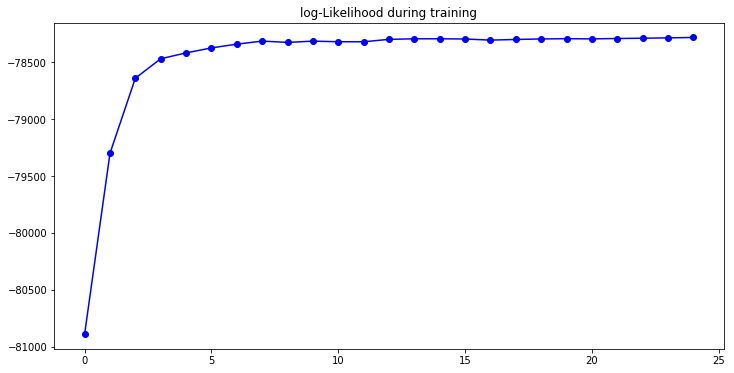

In [185]:
plt.figure(figsize=(12,6))
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.title("log-Likelihood during training")
plt.show()

In [146]:
### model over ground truth
model = clone_model(gMixture.get_basemodel())
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(Xstd_train, keras.utils.to_categorical(Z_train), batch_size=128,epochs=50)
from utils import calculate_f1_keras
print(calculate_f1_keras(model, Xstd_train, Z_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2700/2700 [==============================] - 1s 442us/step - loss: 0.7655
Epoch 2/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.7441
Epoch 3/50
2700/2700 [==============================] - 0s 34us/step - loss: 0.7239
Epoch 4/50
2700/2700 [==============================] - 0s 35us/step - loss: 0.7050
Epoch 5/50
2700/2700 [==============================] - 0s 31us/step - loss: 0.6872
Epoch 6/50
2700/2700 [==============================] - 0s 33us/step - loss: 0.6704
Epoch 7/50
2700/2700 [==============================] - 0s 38us/step - loss: 0.6546
Epoch 8/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.6397
Epo

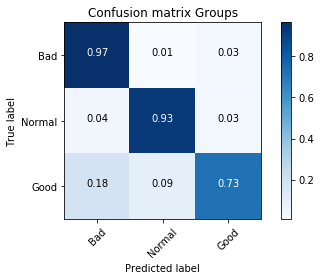

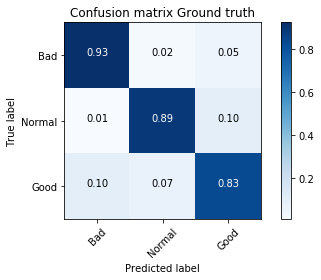

In [147]:
from utils import *
classes = ["Bad","Normal","Good"]
plot_confusion_keras(gMixture.base_model,Xstd_train,Z_train,classes,title='Confusion matrix Groups')
plot_confusion_keras(model,Xstd_train,Z_train,classes,title='Confusion matrix Ground truth')


<a id="condato"></a>
### Training module 2
---
Here we implement the iteration between **E** and **M** steps with bulks annotations $r_{itj}$.

In [ ]:
class GroupMixtureBulk(object):
    def __init__(self,input_dim,Kl=2,M=2,alpha_DD=True,epochs=1,optimizer='adam'): 
        
        
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        self.compile=False
        self.Keps = keras.backend.epsilon()
        self.priors=False #boolean of priors
        #params
        self.M = M #groups of annotators
        self.data_dependence = alpha_DD #for alpha = p(g|x) or p(g)
        self.epochs = epochs
        self.optimizer = optimizer
        
        self.seted_alphainit = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas
    def get_alpha(self):
        """Get alpha param, p(g|xi) for every data on trainig or globally p(g)"""
        return self.alphas
    def set_alpha(self,alphas_init):
        """set alpha param with a previosuly method"""
        self.alphas = alphas_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        return self.Qi_mgamma
        
    def define_model(self,tipo,*args):
        """Define the base model and other structures"""
        aux_info = None
        emb_info = None
        self.type = tipo.lower()
        if self.type =="cnn":
            info,aux_info =args
        elif self.type == "rnn":
            info,aux_info,emb_info = args            
        elif self.type == "ff" or self.type == "mlp": #classic feed forward
            start_units,deep,activation = args
            info = [start_units,deep,activation]
        elif self.type == "keras_shallow" or self.type=="keras_perceptron": 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl,self.optimizer)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        
        if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
            self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X,batch_size=None):
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=batch_size)
    
    def init_E(self,X,r):
        
        
        self.N = X.shape[0]
        #-------> init alpha
        if not self.seted_alphainit:
            self.alphas = np.random.dirichlet(np.ones(self.M),size=self.N) # random start that sum one
        
        #-------> init Majority voting
        mv_probs = majority_voting(r,repeats=True,probas=True)
        #majority voting by group...
        """
        mv_prob_groups = []
        r_sample = 0
        for l in range(self.M):
            aux_mv_probs = majority_voting(np.clip(r-r_sample,0,1e100),repeats=True,probas=True)
            r_sample = []
            for i in range(self.N):
                total_annotators = np.sum(r[i])
                ri_sample = np.random.multinomial(total_annotators/self.M, aux_mv_probs[i]) #asumming al groups have same number of annotators
                r_sample.append(ri_sample)
            r_sample = np.asarray(r_sample)
            mv_prob_groups.append(majority_voting(r_sample,repeats=True,probas=True) )
        """
        
        #-------> init q_i
        self.Qi_mgamma = np.random.rand(self.N,self.M,self.Kl) #random init
        #"""
        for i in range(self.N):            
            #for m in range(self.M):
            self.Qi_mgamma[i] = np.tensordot(self.alphas[i], mv_probs[i],axes=-1)  #a interestetnly E-step  
        
        #-------> init betas
        self.betas = np.random.rand(self.M,self.Kl,self.Kl)
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None]
        
        """
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(mv_probs[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])
            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
        """
        
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",mv_probs.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qi_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if len(priors.shape)==2:
            priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions,r): #r is data
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(predictions[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])

            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
                                                                                                                       
    def M_step(self,X,r): 
        #-------> base model
        #create the repeat "estimate"/"ground truth"
        Qi_gamma = np.sum(self.Qi_mgamma,axis=-2) #qi(gamma)
        #train to learn p(z|x)
        if "sklearn" in self.type:
            self.base_model.fit(X, np.argmax(Qi_gamma,axis=1) ) 
        else:
            history = self.base_model.fit(X,Qi_gamma,batch_size=self.batch_size,epochs=self.epochs,verbose=1) 
            
        #-------> alpha --maneja caso global y normal..
        Qi_m = np.sum(self.Qi_mgamma,axis=-1) #qi(m)
        if not self.data_dependence: #global alpha
            g_estimate = np.sum(Qi_m,axis=0)
            self.alphas[:] = g_estimate/np.sum(g_estimate,axis=-1) #p(g) 
        else:
            self.alphas = Qi_m #p(g|x)
        
        #-------> beta   # p(yo|g,z)
        for m in range(self.M):
            for j_z in range(self.Kl):
                for j_ob in range(self.Kl):
                    self.betas[m,j_z,j_ob] = np.tensordot(self.Qi_mgamma[:,m,j_z],r[:,j_ob], axes=[[0],[0]]) # ~p(yo|g,z)
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior function
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None] #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        
                                                
    def train(self,X_train,r_train,batch_size=32,iterations=250,tolerance=0.001,relative=False): #0.0001  
        
                                                  

gMixtureRaykar = GroupMixtureBulk(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=10)
###epochs=1 as Rodriges says. and batch size as default
gMixtureRaykar.Kl

In [ ]:
gMixtureRaykar = GroupMixtureBulk(X_train.shape[1:],Kl=r_obs.shape[1],M=100)

#gMixture.define_model("sklearn_logistic") #logistic necesita datos de todas la clases
gMixtureRaykar.define_model("keras_shallow")
gMixtureRaykar.set_alpha(alphas_init_Raykar)
#gMixtureRaykar.set_alpha((y_obs!=-1)*1)

#need priors!!!--lo hace mas estable
M = 100
gMixtureRaykar.define_priors(np.ones((M,r_obs.shape[1])))

logL_hist = gMixtureRaykar.train(Xstd_train,r_obs,batch_size=64,iterations=10,relative=False)